In [1]:
import matplotlib.pyplot as plt

In [2]:
import matplotlib.pyplot as plt
import numpy as np

In [3]:
%load_ext autoreload

%autoreload 2

from pathlib import Path
from bs_fdbck.util.BSOA_datamanip import ds2df_inc_preprocessing, ds2df_echam
from bs_fdbck.util.collocate.collocateLONLAToutput import CollocateLONLATout
from bs_fdbck.util.collocate.collocate_echam_salsa import CollocateModelEcham
import useful_scit.util.log as log
from bs_fdbck.util.plot.BSOA_plots import make_cool_grid, plot_scatter
log.ger.setLevel(log.log.INFO)
import time
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

/proj/bolinc/users/x_sarbl/analysis/BS-FDBCK/bs_fdbck/data_info/area_defs.csv
{'NCONC': ['NCONC01', 'NCONC02', 'NCONC04', 'NCONC05', 'NCONC06', 'NCONC07', 'NCONC08', 'NCONC09', 'NCONC10', 'NCONC12', 'NCONC14'], 'SIGMA': ['SIGMA01', 'SIGMA02', 'SIGMA04', 'SIGMA05', 'SIGMA06', 'SIGMA07', 'SIGMA08', 'SIGMA09', 'SIGMA10', 'SIGMA12', 'SIGMA14'], 'NMR': ['NMR01', 'NMR02', 'NMR04', 'NMR05', 'NMR06', 'NMR07', 'NMR08', 'NMR09', 'NMR10', 'NMR12', 'NMR14']}
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
import scienceplots
import scienceplots
plt.style.use([
    'default',
    # 'science',
    'acp',
    # 'sp-grid',
    'no-black',
    'no-latex',
    'illustrator-safe'
])


In [5]:
select_station = 'SMR'

In [6]:
plot_path = Path(f'Plots/Both_stations')

In [7]:
def make_fn_scat(case, v_x, v_y):
    _x = v_x.split('(')[0]
    _y = v_y.split('(')[0]
    f = f'scat_all_years_2stations_{case}_{_x}_{_y}.png'
    return plot_path /f

In [8]:
models = ['ECHAM-SALSA','NorESM', 'EC-Earth', 'UKESM']
mod2cases = {'ECHAM-SALSA' : ['SALSA_BSOA_feedback'],
             'NorESM' : ['OsloAero_intBVOC_f09_f09_mg17_fssp'],
             'EC-Earth' : ['ECE3_output_Sara'],
             'UKESM' : ['AEROCOMTRAJ'],
             'Observations':['Obs'],
            }
di_mod2cases = mod2cases.copy()

In [9]:
models_and_obs =  models + ['Observations'] 
models_and_obs

['ECHAM-SALSA', 'NorESM', 'EC-Earth', 'UKESM', 'Observations']

In [10]:
dic_season_nicename = {
    'JFM':'Jan-Mar',
    'FMA':'Feb-Apr',
    'FMAM':'Feb-May',
    'JFMAM':'Jan-May',
    'MAM':'Mar-May',
    'JA':'July-Aug',
}


## Read in data

### Data is produced in [02-01-relations_plots_TOANx_SMR.ipynb](02-01-relations_plots_TOANx_SMR.ipynb) and [02-02-relations_plots_TOANx_ATTO.ipynb](02-02-relations_plots_TOANx_ATTO.ipynb)

In [11]:
path_save_daily_medians_SMR = Path(f'Temp_data/SMR_daily_medians')
path_save_daily_medians_ATTO = Path(f'Temp_data/ATTO_daily_medians')

dic_df_med_SMR = dict()
dic_df_med_ATTO = dict()

for mo in di_mod2cases.keys():
    for ca in di_mod2cases[mo]:
        if len(di_mod2cases[mo])>1:
            use_name = f'{mo}_{ca}'
        else:
            use_name = mo
            
        
        fp_smr = path_save_daily_medians_SMR.parent / f'{path_save_daily_medians_SMR.name}_{use_name}.csv'
        fp_atto = path_save_daily_medians_ATTO.parent / f'{path_save_daily_medians_ATTO.name}_{use_name}.csv'
        
        dic_df_med_SMR[use_name] = pd.read_csv(fp_smr, index_col=0,)
        dic_df_med_SMR[use_name].index = pd.to_datetime(dic_df_med_SMR[use_name].index)
        dic_df_med_SMR[use_name]['month'] = dic_df_med_SMR[use_name].index.month
        dic_df_med_ATTO[use_name] = pd.read_csv(fp_atto, index_col=0)
        dic_df_med_ATTO[use_name].index = pd.to_datetime(dic_df_med_ATTO[use_name].index)
        dic_df_med_ATTO[use_name]['month'] = dic_df_med_ATTO[use_name].index.month
        
        


In [12]:
def make_plot2(v_x, v_y, xlims, ylims, season, 
              xlab=None, ylab=None, alpha_scat=.4,
             source_list = models_and_obs, fig=None, 
               axs=None,
              xscale='linear', yscale='linear',
               select_station= '',
              dic_df_med = None,
               divide_NorESM_by_factor=None,
               divide_UKESM_by_factor=None,
               markersize = 1,
             ):
    if xlab is None: 
        if xlab in label_dic:
            xlab = label_dic[v_x]
    if ylab is None: 
        if ylab in label_dic:
            ylab = label_dic[v_y]

    for mo, ax in zip(source_list, axs[:]):
        print(mo)
        df_s =  dic_df_med[mo]
    
        mask_months = select_months(df_s, season=season)
        df_s = df_s[mask_months].copy()
        
        if (mo =='NorESM') &  (divide_NorESM_by_factor is not None):
            df_s = df_s/divide_NorESM_by_factor
            title = f'{mo}/{divide_NorESM_by_factor}'
            print(title)
            ax.spines['bottom'].set_color('r')
            ax.spines['top'].set_color('r') 
            ax.spines['right'].set_color('red')
            ax.spines['left'].set_color('red')
            ax.set_title(title, c='r')
        elif (mo =='UKESM') &  (divide_UKESM_by_factor is not None):
            df_s = df_s/divide_UKESM_by_factor
            title = f'{mo}/{divide_UKESM_by_factor}'
            print(title)
            ax.spines['bottom'].set_color('m')
            ax.spines['top'].set_color('m') 
            ax.spines['right'].set_color('m')
            ax.spines['left'].set_color('m')
            ax.set_title(title, c='m')

        else:
            title = mo
            ax.set_title(title,)# y=.95)
            
        sns.scatterplot(x=v_x,y=v_y, 
                    data = df_s, 
                    color=cdic_model[mo], 
                    alpha=alpha_scatt+.1, 
                    label='__nolegend__',
                    ax = ax,
                    #facecolor='none',
                        edgecolor=cdic_model[mo],
                        marker='.',
                        s=markersize,
                        #rasterized = True,
                    
                   )
        #ax.set_title(mo, y=.95)
        
    ax.set_xlabel(xlab)
    ax.set_ylabel(ylab)
    fig.suptitle(f'{select_station}, {season} season, 2012-2018', y=.95)
    #xlim_dist = list(daxs['y'].get_xlim())
    for mo,ax in zip(source_list, axs):

        df_s =  dic_df_med[mo]

        mask_months = select_months(df_s, season=season)
        df_s = df_s[mask_months].copy()
        if xscale=='log':
            xbins = np.logspace(np.log10(xlims[0]),np.log10(xlims[1]),20)
        else:
            xbins = np.linspace(xlims[0],xlims[1],20)
            
        if yscale=='log':
            ybins = np.logspace(np.log10(ylims[0]),np.log10(ylims[1]),20)
        else:
            ybins = np.linspace(ylims[0],ylims[1],20)
            

        ax.set_ylim(ylims)
        ax.set_xlim(xlims)

        sns.despine(ax = ax)

    return

#### WET_mid

### Fit funcs

In [13]:
from bs_fdbck.util.BSOA_datamanip.fits import *
from bs_fdbck.util.BSOA_datamanip.atto import season2month

### season to monthseason2month

In [14]:
from sklearn.metrics import r2_score


In [15]:
def select_months(df, season = None, month_list=None):
    if season is not None: 
        month_list = season2month[season]
    

    df['month'] = df.index.month
    return df['month'].isin(month_list)

In [16]:
from bs_fdbck.util.BSOA_datamanip.fits import *

In [17]:
from bs_fdbck.util.plot.BSOA_plots import cdic_model, make_cool_grid5

In [18]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

In [19]:
def calc_table_se(di):
    di['a'] = di['popt'][0]
    di['b'] = di['popt'][1]
    if len(di['popt'])>2:
        di['c'] = di['popt'][2]
    di['SE_a'] = di['standard_error'][0]
    di['SE_b'] = di['standard_error'][1]
    if len(di['popt'])>2:
        di['SE_c'] = di['standard_error'][2]
    else:
        di['SE_c'] = np.nan
        
    for v in ['a','b','c']:
        if len(di['popt'])<=2 and v=='c':
            di[f'{v}_str'] = ''
            continue
        v_SE = f'SE_{v}'
        if np.abs(di[v])>10 and di[v_SE]>1:
            di[f'{v}_str'] = '%.1f $\pm$ %.1f' %(di[v], di[v_SE])
        elif np.abs(di[v])>.1 and di[v_SE]>.01:
            di[f'{v}_str'] = '%.2f $\pm$ %.2f' %(di[v], di[v_SE])
        else:
            di[f'{v}_str'] = '%.2E $\pm$ %.2E' %(di[v], di[v_SE])
            
            

    return di

In [20]:
def func_atto(df_s,v_x,v_y,):
    if v_y=='N50-500':
        return get_odr_fit_and_labs(df_s,v_x,v_y, fit_func='linear', return_func=True)
        #return get_least_square_fit_and_labs(df_s,v_x,v_y, fit_func='linear', return_func=True)

    elif v_y =='N100-500':

        return get_odr_fit_and_labs(df_s,v_x,v_y, fit_func='linear', return_func=True)
        #return get_least_square_fit_and_labs(df_s,v_x,v_y, fit_func='linear', return_func=True)

    elif v_y =='N200-500':
        return get_odr_fit_and_labs(df_s,v_x,v_y, fit_func='linear', return_func=True)
        #return get_least_square_fit_and_labs(df_s,v_x,v_y, fit_func='linear', return_func=True)
    
    else:
        print(f'did not recognice v_y:{v_y}')


In [21]:
def func_smr(df_s,v_x,v_y,):
    if v_y=='N50':
        return get_log_fit_abc(df_s,v_x,v_y, return_func=True)
    elif v_y =='N100':
        try:
            return get_log_fit_abc(df_s,v_x,v_y, return_func=True)
        except RuntimeError:
            return get_odr_fit_and_labs(df_s,v_x,v_y, fit_func='linear', return_func=True)
            #return get_least_square_fit_and_labs(df_s,v_x,v_y, fit_func='linear', return_func=True)
            
    elif v_y =='N200':
        return get_odr_fit_and_labs(df_s,v_x,v_y, fit_func='linear', return_func=True)
        #return get_least_square_fit_and_labs(df_s,v_x,v_y, fit_func='linear', return_func=True)
    
    else:
        print(f'did not recognice v_y:{v_y}')
def func_smr_lin(df_s,v_x,v_y,):
    if v_y=='N50':
        return get_odr_fit_and_labs(df_s,v_x,v_y, fit_func='linear', return_func=True)
        #return get_least_square_fit_and_labs(df_s,v_x,v_y, fit_func='linear', return_func=True)

    elif v_y =='N100':
        return get_odr_fit_and_labs(df_s,v_x,v_y, fit_func='linear', return_func=True)
        #return get_least_square_fit_and_labs(df_s,v_x,v_y, fit_func='linear', return_func=True)

    elif v_y =='N200':
        return get_odr_fit_and_labs(df_s,v_x,v_y, fit_func='linear', return_func=True)
        #return get_least_square_fit_and_labs(df_s,v_x,v_y, fit_func='linear', return_func=True)
    
    else:
        print(f'did not recognice v_y:{v_y}')


In [22]:
def get_r2(df_s,v_x,x_y, popt, func):
    
    _df = df_s[[v_x, v_y]].dropna()
    y_pred = func(_df[v_x].values, *popt)
    r2 =  r2_score(_df[v_y].values, y_pred)
    return r2



def get_corr(df_s,v_x,x_y):
    
    _df = df_s[[v_x, v_y]].dropna()
    return _df.corr().loc[v_x,v_y]


In [23]:
def make_pd_of_dic(dic_fits):
    columns = ['station','variable','data source','Fit','a','b','c','R2', 'corr']
    df_test = pd.DataFrame(columns=columns )
    df_list = []
    dic_labels = dict()
    for st in ['SMR','ATTO']:
        dic_labels[st] = dict()
        for v_y in dic_fits[st].keys():
            dic_labels[st][v_y] = dict()
            for mo in dic_fits[st][v_y].keys():
                dic_labels[st][v_y][mo] = dict()
                dic_labels[st][v_y][mo] = dic_fits[st][v_y][mo]['label'] 
                _d = dict()
                _d['station'] = st
                _d['variable'] =v_y
                _d['data source'] = mo
                _d['Fit'] = dic_fits[st][v_y][mo]['label']
                _d['a'] = dic_fits[st][v_y][mo]['a_str']
                _d['b'] = dic_fits[st][v_y][mo]['b_str']
                _d['c'] = dic_fits[st][v_y][mo]['c_str']
                _d['R$^2$'] = np.round(dic_fits[st][v_y][mo]['R2'] , decimals=2)
                _d['r$^2$'] = np.round(dic_fits[st][v_y][mo]['corr'] , decimals=2)
                #print(_d)
                d2 = {st:_d}
                df_list.append(pd.DataFrame(d2).T)
                

    df = pd.DataFrame(dic_labels['SMR']).T
    df['station'] = 'SMR'
    df2 = pd.DataFrame(dic_labels['ATTO']).T
    df2['station'] = 'ATTO'
    df2 = df2.reset_index().set_index(['station','index'])
    df1 = df.reset_index().set_index(['station','index'])
    df_out = pd.concat([df1,df2],)
    df_out = pd.concat(df_list, axis=0).reset_index()    
    df_out = df_out.drop('index', axis=1).set_index(['station','variable','data source'])
    return df_out

get_corr

<function __main__.get_corr(df_s, v_x, x_y)>

In [24]:
plot_path.mkdir(exist_ok=True)

In [25]:
left, width = .1, .5
bottom, height = .25, .5
right = left + width
top = bottom + height

#### Paper figure:

Observations
UKESM
EC-Earth
NorESM
ECHAM-SALSA
Observations
0.3260419965404727
UKESM
0.6953921000457486
EC-Earth
0.6890256492078259

/proj/bolinc/users/x_sarbl/analysis/BS-FDBCK/bs_fdbck/util/BSOA_datamanip/fits.py:528: RuntimeWarning: invalid value encountered in log
  return a + b * np.log(c + x)
/proj/bolinc/users/x_sarbl/analysis/BS-FDBCK/bs_fdbck/util/BSOA_datamanip/fits.py:528: RuntimeWarning: invalid value encountered in log
  return a + b * np.log(c + x)
/proj/bolinc/users/x_sarbl/analysis/BS-FDBCK/bs_fdbck/util/BSOA_datamanip/fits.py:528: RuntimeWarning: invalid value encountered in log
  return a + b * np.log(c + x)
/proj/bolinc/users/x_sarbl/analysis/BS-FDBCK/bs_fdbck/util/BSOA_datamanip/fits.py:528: RuntimeWarning: invalid value encountered in log
  return a + b * np.log(c + x)
/proj/bolinc/users/x_sarbl/analysis/BS-FDBCK/bs_fdbck/util/BSOA_datamanip/fits.py:528: RuntimeWarning: invalid value encountered in log
  return a + b * np.log(c + x)
/proj/bolinc/users/x_sarbl/analysis/BS-FDBCK/bs_fdbck/util/BSOA_datamanip/fits.py:528: RuntimeWarning: invalid value encountered in log
  return a + b * np.log(c + x


NorESM
0.8630133769912338
ECHAM-SALSA
0.43915906482691647
Observations
UKESM
EC-Earth
NorESM
ECHAM-SALSA
Observations
0.7654555486371468
UKESM
0.7594093618355633
EC-Earth
0.8520036195409988
NorESM


/proj/bolinc/users/x_sarbl/analysis/BS-FDBCK/bs_fdbck/util/BSOA_datamanip/fits.py:528: RuntimeWarning: invalid value encountered in log
  return a + b * np.log(c + x)
/proj/bolinc/users/x_sarbl/analysis/BS-FDBCK/bs_fdbck/util/BSOA_datamanip/fits.py:528: RuntimeWarning: invalid value encountered in log
  return a + b * np.log(c + x)
/proj/bolinc/users/x_sarbl/analysis/BS-FDBCK/bs_fdbck/util/BSOA_datamanip/fits.py:528: RuntimeWarning: invalid value encountered in log
  return a + b * np.log(c + x)
/proj/bolinc/users/x_sarbl/analysis/BS-FDBCK/bs_fdbck/util/BSOA_datamanip/fits.py:528: RuntimeWarning: invalid value encountered in log
  return a + b * np.log(c + x)
/proj/bolinc/users/x_sarbl/analysis/BS-FDBCK/bs_fdbck/util/BSOA_datamanip/fits.py:528: RuntimeWarning: invalid value encountered in log
  return a + b * np.log(c + x)


[302.68639399 -43.92947774]
Beta: [312.33767766 -62.4395137 ]
Beta Std Error: [ 5.03031372 12.1031752 ]
Beta Covariance: [[  812.17825969 -1557.66341263]
 [-1557.66341263  4701.75351939]]
Residual Variance: 0.03115579096414946
Inverse Condition #: 0.2163604767814529
Reason(s) for Halting:
  Sum of squares convergence
[312.33767766 -62.4395137 ]
reason for haltng
0.9381991850575244
ECHAM-SALSA
0.7815120149772352
Observations
UKESM
EC-Earth
NorESM
ECHAM-SALSA
Observations
[50.6632659 -2.9398395]
Beta: [ 53.56800661 -11.52806991]
Beta Std Error: [1.14970721 3.98628453]
Beta Covariance: [[ 24.17625158 -71.4801166 ]
 [-71.4801166  290.63709326]]
Residual Variance: 0.05467459151998026
Inverse Condition #: 0.008692473919387366
Reason(s) for Halting:
  Sum of squares convergence
[ 53.56800661 -11.52806991]
reason for haltng
0.8915472533421044
UKESM
[129.31996204  75.29379338]
Beta: [132.42005295  67.0025941 ]
Beta Std Error: [1.85664124 6.14214792]
Beta Covariance: [[ 146.03086198 -390.5598075

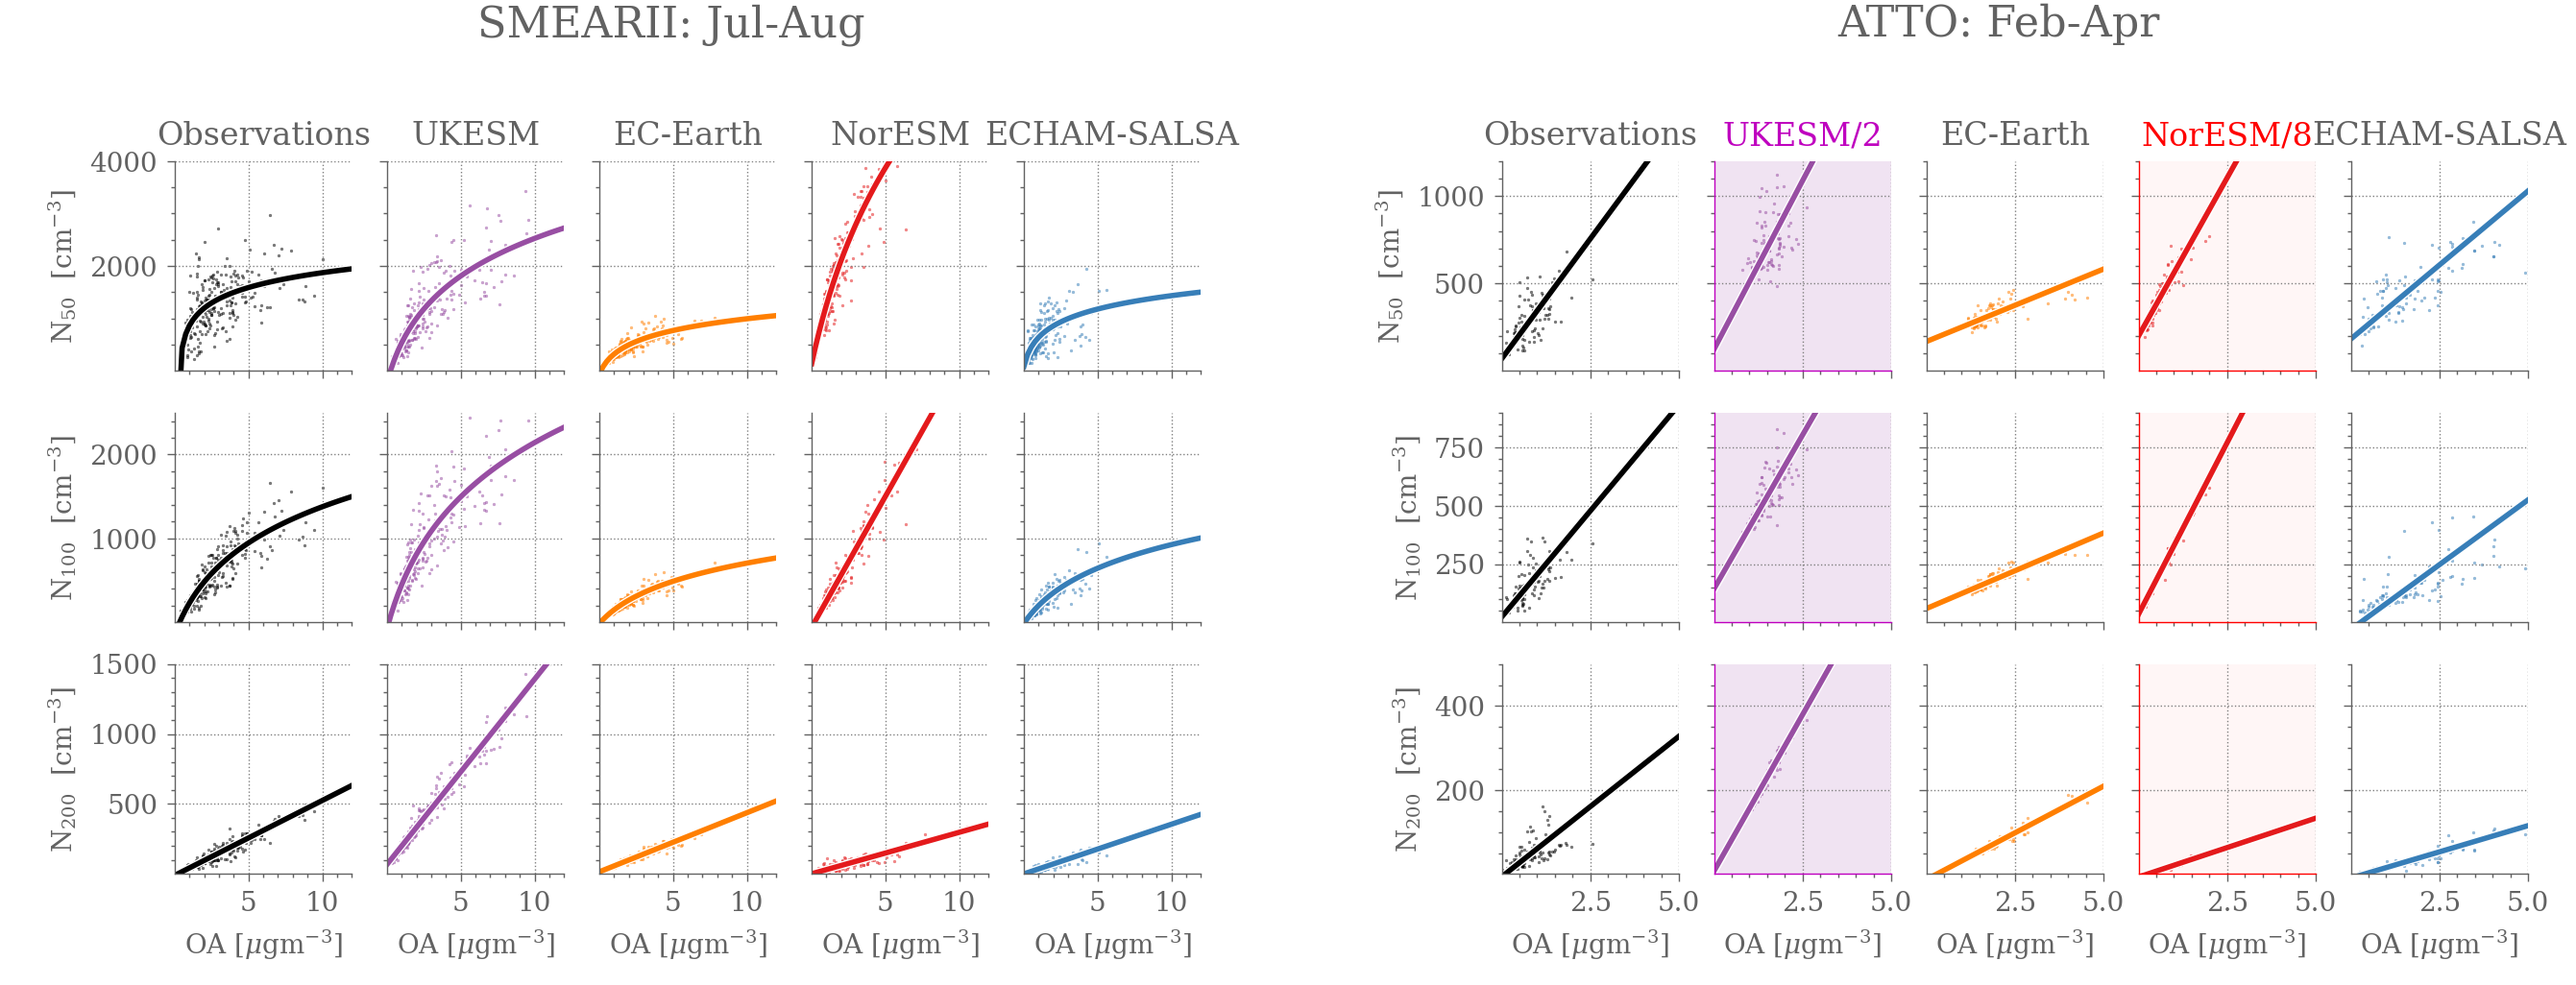

In [26]:
fx = .92
fig_main = plt.figure(#constrained_layout=True,
                  figsize=[15*fx,5.5*fx],
                      
                 )


spec2 = gridspec.GridSpec( nrows=2,ncols=3, 
                          width_ratios=[4,.01,4],
                          height_ratios=[1,20], 
                          figure=fig_main,
                         )


markersize = 4

subfig1 =  fig_main.add_subfigure(spec2[1, 0],frameon=True )
subfig2 =  fig_main.add_subfigure(spec2[1, 1])
subfig3 =  fig_main.add_subfigure(spec2[1, 2],frameon=True,)


axs_smr = subfig1.subplots(3,5, sharex='col', sharey='row')
#ax_fits = subfig2.subplots(3,1, sharex='col', sharey='row')
axs_atto =subfig3.subplots(3,5, sharex='col', sharey='row')
#subfig2.set_facecolor('#e9f2f9')##e5f8f8')
# subfig3.set_facecolor('#fff4ea')

dic_fits = {}
dic_fits['SMR'] =dict()
dic_fits['ATTO'] =dict()

#subfig1.suptitle('SMEARII, Jul & Aug')
#subfig3.suptitle('ATTO, JFM')
#subfig2.suptitle('Fits')
subfig_up =  fig_main.add_subfigure(spec2[0, 0])
subfig_up2 =  fig_main.add_subfigure(spec2[0, -1])

ax_dum = subfig_up.subplots(1)
ax_dum.axis('off')
ax_dum2 = subfig_up2.subplots(1)
ax_dum2.axis('off')


divide_NorESM_by_factor = 8 
divide_UKESM_by_factor = 2


varlistplot = ['N50','N100','N200']
xlab = r'OA [$\mu$gm$^{-3}$]'
alpha_scatt = 0.4
source_list = models_and_obs[::-1]
v_x = 'OA'

## Settings
dic_lims = {
    'N50': {'xlims':[.01,12], 'ylims':[1,4000]},
    'N100': {'xlims':[.01,12], 'ylims':[1,2500]},
    'N200': {'xlims':[.01,12], 'ylims':[1,1500]},
    'N50-500': {'xlims':[.01,5], 'ylims':[1,1200]},
    'N100-500': {'xlims':[.01,5], 'ylims':[1,900]},
    'N200-500': {'xlims':[.01,5], 'ylims':[1,500]},

}

dic_ylabels = {
    'N50' : r'N$_{50}$  [cm$^{-3}$]',
    'N100' : r'N$_{100}$  [cm$^{-3}$]',
    'N200' : r'N$_{200}$  [cm$^{-3}$]',
    'N50-500' : r'N$_{50}$  [cm$^{-3}$]',
    'N100-500' : r'N$_{100}$  [cm$^{-3}$]',
    'N200-500' : r'N$_{200}$  [cm$^{-3}$]',

}




select_station = 'SMR'
season = 'JA'


xscale='linear'
yscale='linear'


# OBS: 

dic_df_med = dic_df_med_SMR
axs_all = axs_smr
fig = subfig1


#fig, axs_all = plt.subplots(3,6,figsize=figsize, sharey='row', sharex='col')
## Settings
legends_smr = []
legends_atto = []
legs =[]

for i,v_y in enumerate(varlistplot):
    dic_fits[select_station][v_y] = dict()
    # Make plot
    ylab = dic_ylabels[v_y]
    ylims = dic_lims[v_y]['ylims']
    xlims = dic_lims[v_y]['xlims']
    
    axs_sub = axs_all[i,:]
    axs_sub[0].set_ylabel(ylab)
    make_plot2(v_x, v_y, xlims, ylims, season, 
              xlab=xlab, ylab=ylab, alpha_scat=alpha_scatt,
             source_list = source_list, fig=fig, 
               axs=axs_sub,
              xscale='linear', yscale='linear',
              dic_df_med = dic_df_med,
           select_station= select_station,
               markersize=markersize,
         )

    
    for mo, ax in zip(source_list, axs_sub):
        dic_fits[select_station][v_y][mo] = dict()

        df_s =  dic_df_med[mo]
        
        print(mo)
        mask_months = select_months(df_s, season=season)
        df_s = df_s[mask_months].copy()
        popt, pov, label, func = func_smr(df_s,v_x,v_y)
            
            
        legends_smr.append(label)

        plot_fit(func, popt, mo, xlims, yscale, xscale, ax, label,)
        #plot_fit(func, popt, mo, xlims, yscale, xscale,  ax_fits[i],label,extra_plot=True)

        dic_fits[select_station][v_y][mo]['label'] = label
        dic_fits[select_station][v_y][mo]['popt'] = popt
        dic_fits[select_station][v_y][mo]['pcov'] = pov
        dic_fits[select_station][v_y][mo]['standard_error'] = np.sqrt(np.diag(dic_fits[select_station][v_y][mo]['pcov']))
        
        dic_fits[select_station][v_y][mo]['func'] = func
        dic_fits[select_station][v_y][mo]['R2'] = get_r2(df_s,v_x,v_y, popt, func)
        dic_fits[select_station][v_y][mo]['corr'] = get_corr(df_s,v_x,v_y)
        print( get_r2(df_s,v_x,v_y, popt, func))
        dic_fits[select_station][v_y][mo] = calc_table_se(dic_fits[select_station][v_y][mo])   
        
        
        ax.set_yscale(yscale)
        ax.set_xscale(xscale)
    #leg = axs_sub[-1].legend(bbox_to_anchor=(1,1,), frameon=False)

    #legs.append(leg)


    
for ax in axs_sub:
    ax.set_xlabel(xlab)
sns.despine(fig) 








varlistplot = ['N50-500','N100-500','N200-500']

select_station = 'ATTO'
season = 'FMA'

xscale='linear'
yscale='linear'


# OBS: 

dic_df_med = dic_df_med_ATTO
axs_all = axs_atto
fig = subfig3
select_station = 'ATTO'


#fig, axs_all = plt.subplots(3,6,figsize=figsize, sharey='row', sharex='col')
## Settings

legs =[]

for i,v_y in enumerate(varlistplot):
    dic_fits[select_station][v_y] = dict()
    
    # Make plot
    ylab = dic_ylabels[v_y]
    ylims = dic_lims[v_y]['ylims']
    xlims = dic_lims[v_y]['xlims']
    axs_sub = axs_all[i,:]
    axs_sub[0].set_ylabel(ylab)

    make_plot2(v_x, v_y, xlims, ylims, season, 
              xlab=xlab, ylab=ylab, alpha_scat=alpha_scatt,
             source_list = source_list, fig=fig, 
               axs=axs_sub,
              xscale='linear', yscale='linear',
              dic_df_med = dic_df_med,
           select_station= select_station,
               divide_NorESM_by_factor=divide_NorESM_by_factor,
               divide_UKESM_by_factor = divide_UKESM_by_factor,
               markersize=markersize,     
         )


    for mo, ax in zip(source_list, axs_sub):
        dic_fits[select_station][v_y][mo] = dict()
        
        df_s =  dic_df_med[mo]
        print(mo)
        mask_months = select_months(df_s, season=season)
        df_s = df_s[mask_months].copy()
        if (mo =='NorESM') &  (divide_NorESM_by_factor is not None):
            df_s = df_s/divide_NorESM_by_factor
            ax.set_facecolor('#fff6f6')
        if (mo =='UKESM') &  (divide_UKESM_by_factor is not None):
            df_s = df_s/divide_UKESM_by_factor
            ax.set_facecolor('#f0e3f2')
        popt, pov, label, func = func_atto(df_s,v_x,v_y)
        legends_atto.append(label)
        
        plot_fit(func, popt, mo, xlims, yscale, xscale, ax,label)#, linestyle='dashed')
        #plot_fit(func, popt, mo, xlims, yscale, xscale,  ax_fits[i],label,  extra_plot=True,linestyle='dashed',)
        ax.set_xlim(xlims)
        
        dic_fits[select_station][v_y][mo]['label'] = label
        dic_fits[select_station][v_y][mo]['popt'] = popt
        dic_fits[select_station][v_y][mo]['pcov'] = pov
        dic_fits[select_station][v_y][mo]['standard_error'] = np.sqrt(np.diag(dic_fits[select_station][v_y][mo]['pcov']))
        
        #dic_fits[select_station][v_y][mo]['func'] = func
        dic_fits[select_station][v_y][mo]['R2'] = get_r2(df_s,v_x,v_y, popt, func)
        dic_fits[select_station][v_y][mo]['corr'] = get_corr(df_s,v_x,v_y)
        dic_fits[select_station][v_y][mo] = calc_table_se(dic_fits[select_station][v_y][mo])        

        _a = label.split('x')[0][1:]
        _b = label.split('x')[1][:-1]
        if _b[0]=='+':
            _b=_b[1:]
        #ax.text(left, top, f'a=${_a}$ \nb=${_b}$',
        #horizontalalignment='left',
        #verticalalignment='top',
        #transform=ax.transAxes)

        ax.set_yscale(yscale)
        ax.set_xscale(xscale)
        #ax.legend(frameon=False, fontsize=10)
    
    #leg = axs_sub[-1].legend(bbox_to_anchor=(1,1,), frameon=False)

    #legs.append(leg)


    
for ax in axs_sub:
    ax.set_xlabel(xlab)
sns.despine(fig) 




#for i, v_y in enumerate(varlistplot):
#    xlims = dic_lims[v_y]['xlims']
#    ax = ax_fits[i]
    
    #ax.set_xlim(xlims)
#    ax.set_ylim(dic_lims[v_y]['ylims'])
#    ax.set_yticklabels([])
#    ax.set_facecolor('#e9f2f9')##e5f8f8')
#    sns.despine(ax)
#ax.set_xlabel(xlab)
sns.despine(subfig2) 

subfig1.suptitle('SMEARII: Jul-Aug', size=16, y=1.05, zorder=100000)
subfig_up.suptitle('SMEARII: Jul-Aug', size=16, y=1., zorder=100000)
#subfig2.suptitle('F', size=16, y=1.05, c='w')
subfig3.suptitle(f'ATTO: {dic_season_nicename[season]}', size=16, y=1.05,zorder=100000)
subfig_up2.suptitle(f'ATTO: {dic_season_nicename[season]}', size=16, y=1.0,zorder=100000)

#axs_all = list(ax_fits.flatten())+list(axs_smr.flatten())+ list(axs_atto.flatten())
axs_all = list(list(axs_smr.flatten())+ list(axs_atto.flatten()))
for ax in axs_all:
    ax.grid(color = 'grey', linestyle = ':', linewidth = 0.5)



#for ax in axs_atto[:,0]:
#    ax.set_yticklabels([])
#    ax.set_ylabel('')

for ax in axs_atto[1:,:].flatten():
    ax.set_title('')


for ax in axs_smr[1:,:].flatten():
    ax.set_title('')

#ax_fits[0].set_title('.', color='w')
fn = make_fn_scat(f'together_{season}', v_x, 'Nx')
print(fn)
#plt.tight_layout()
plt.savefig(fn.with_suffix('.pdf'),bbox_inches='tight', )
plt.savefig(fn.with_suffix('.png'),bbox_inches='tight', dpi=200)

df = make_pd_of_dic(dic_fits)
df_log = df
df.to_csv(fn.with_suffix('.csv'))

plt.show()

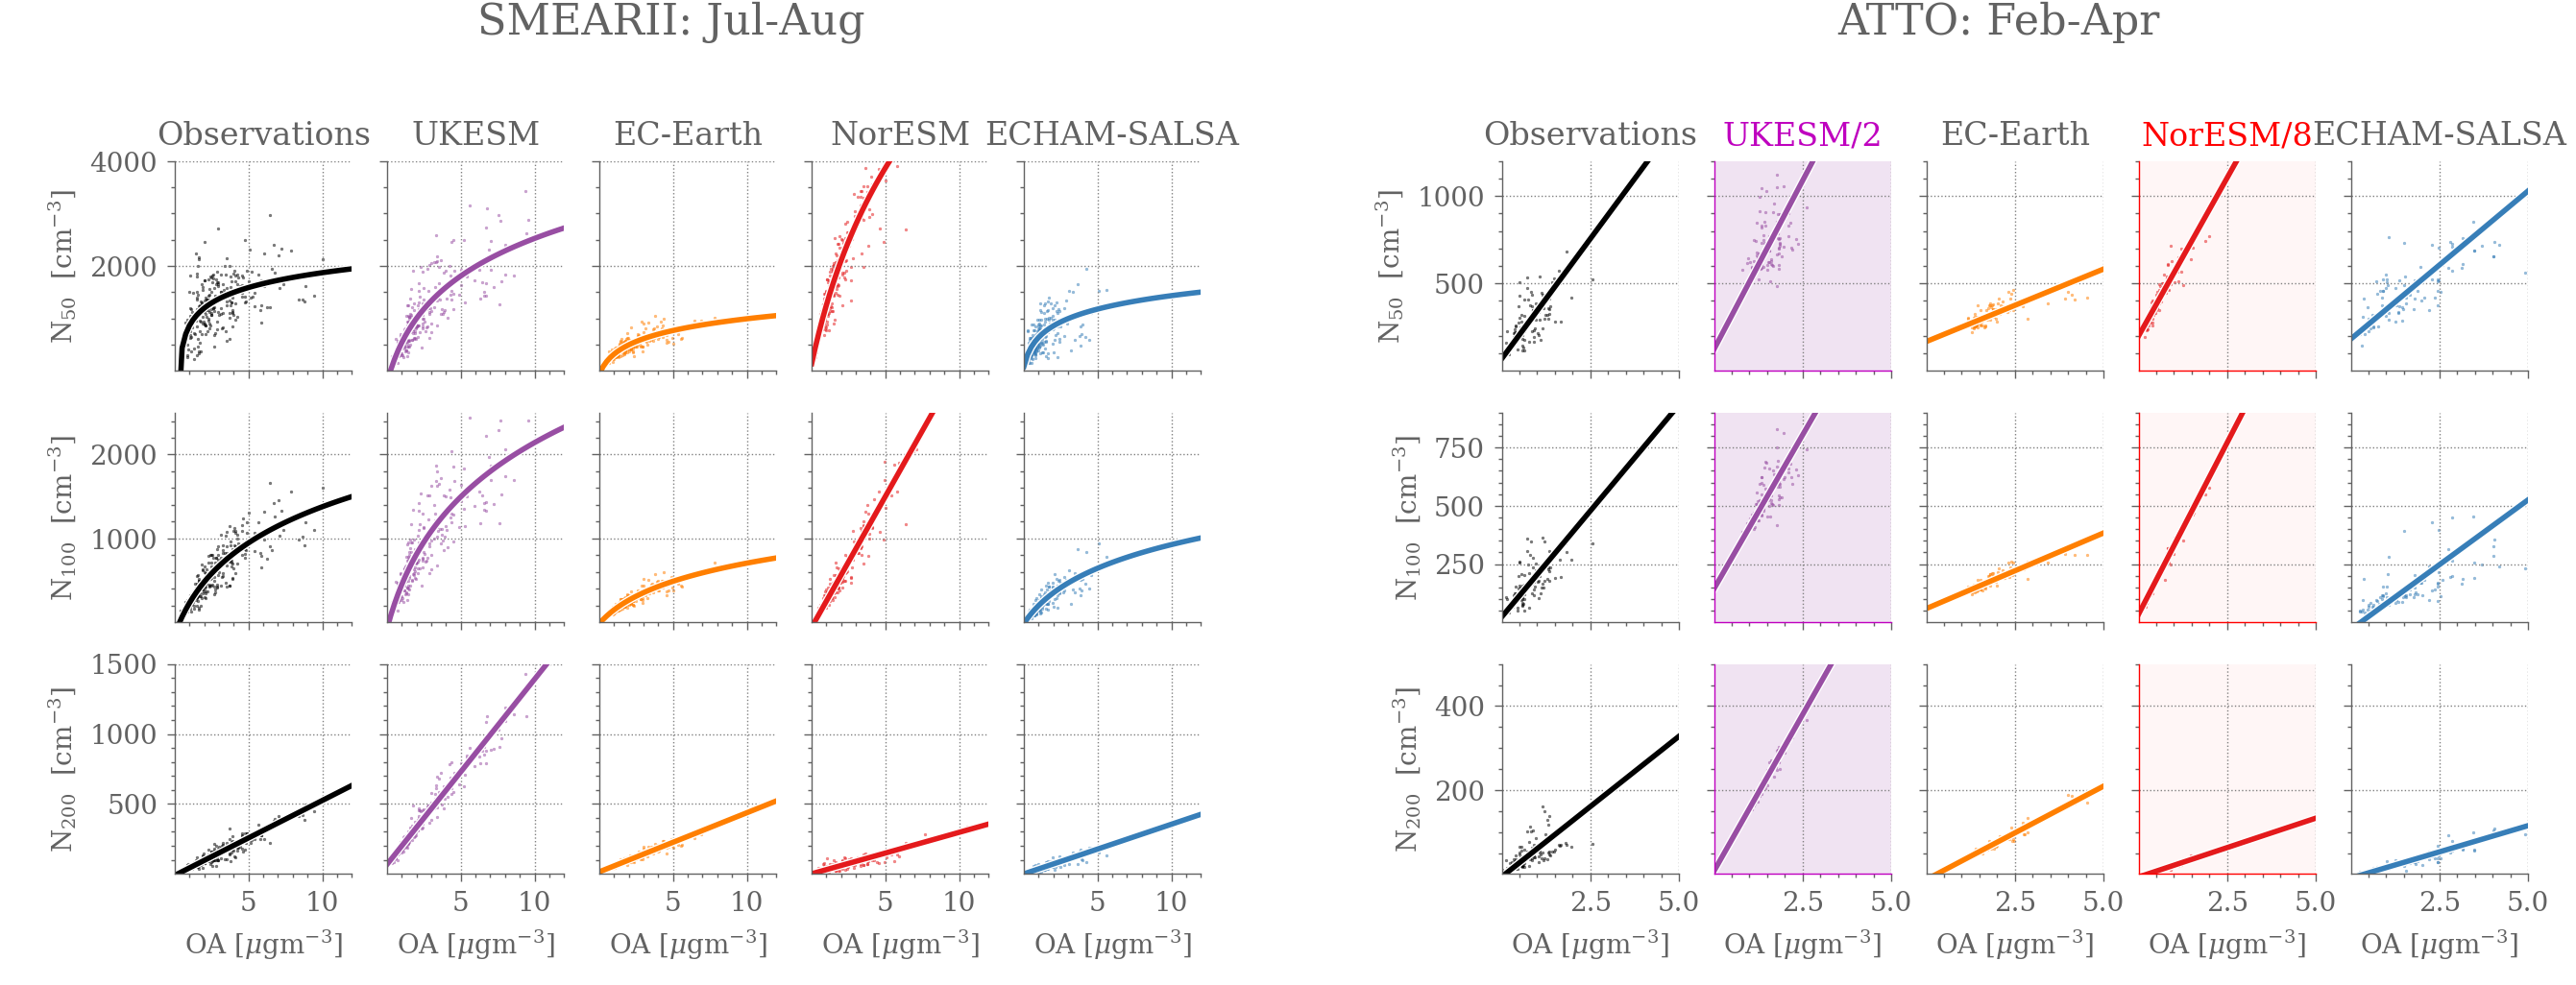

In [27]:
subfig1.suptitle('SMEARII: Jul-Aug', size=16, y=1.05, zorder=100000)
subfig_up.suptitle('SMEARII: Jul-Aug', size=16, y=1.05, zorder=100000)
#subfig2.suptitle('F', size=16, y=1.05, c='w')
subfig3.suptitle(f'')#ATTO: {dic_season_nicename[season]}', size=16, y=1.05,zorder=100000)
subfig_up2.suptitle(f'ATTO: {dic_season_nicename[season]}', size=16, y=1.05,zorder=100000)
fig_main

In [28]:
subfig1.set

<bound method Artist.set of <matplotlib.figure.SubFigure object at 0x7f7ff7919340>>

In [29]:
display(fn.with_suffix('.pdf'))

PosixPath('Plots/Both_stations/scat_all_years_2stations_together_FMA_OA_Nx.pdf')

#### Both linear

Observations
UKESM
EC-Earth
NorESM
ECHAM-SALSA
Observations
[138.89443511 863.47696168]
Beta: [274.7750737  461.72876929]
Beta Std Error: [20.24778873 68.00229717]
Beta Covariance: [[  822.16973863 -2430.84826639]
 [-2430.84826639  9273.70878692]]
Residual Variance: 0.4986475773600884
Inverse Condition #: 0.12288757076816213
Reason(s) for Halting:
  Sum of squares convergence
[274.7750737  461.72876929]
reason for haltng
0.010966302843978704
UKESM
[268.07441197 386.34931159]
Beta: [331.54580114 216.59494117]
Beta Std Error: [13.89769053 45.29446353]
Beta Covariance: [[ 1000.49079816 -2675.81440462]
 [-2675.81440462 10627.18070673]]
Residual Variance: 0.1930510530318399
Inverse Condition #: 0.15662512517644347
Reason(s) for Halting:
  Sum of squares convergence
[331.54580114 216.59494117]
reason for haltng
0.6170858060143964
EC-Earth
[113.70926947 234.88660619]
Beta: [141.20962611 176.72952346]
Beta Std Error: [ 6.18409531 15.09924399]
Beta Covariance: [[ 194.63722508 -411.61404379]
 [-

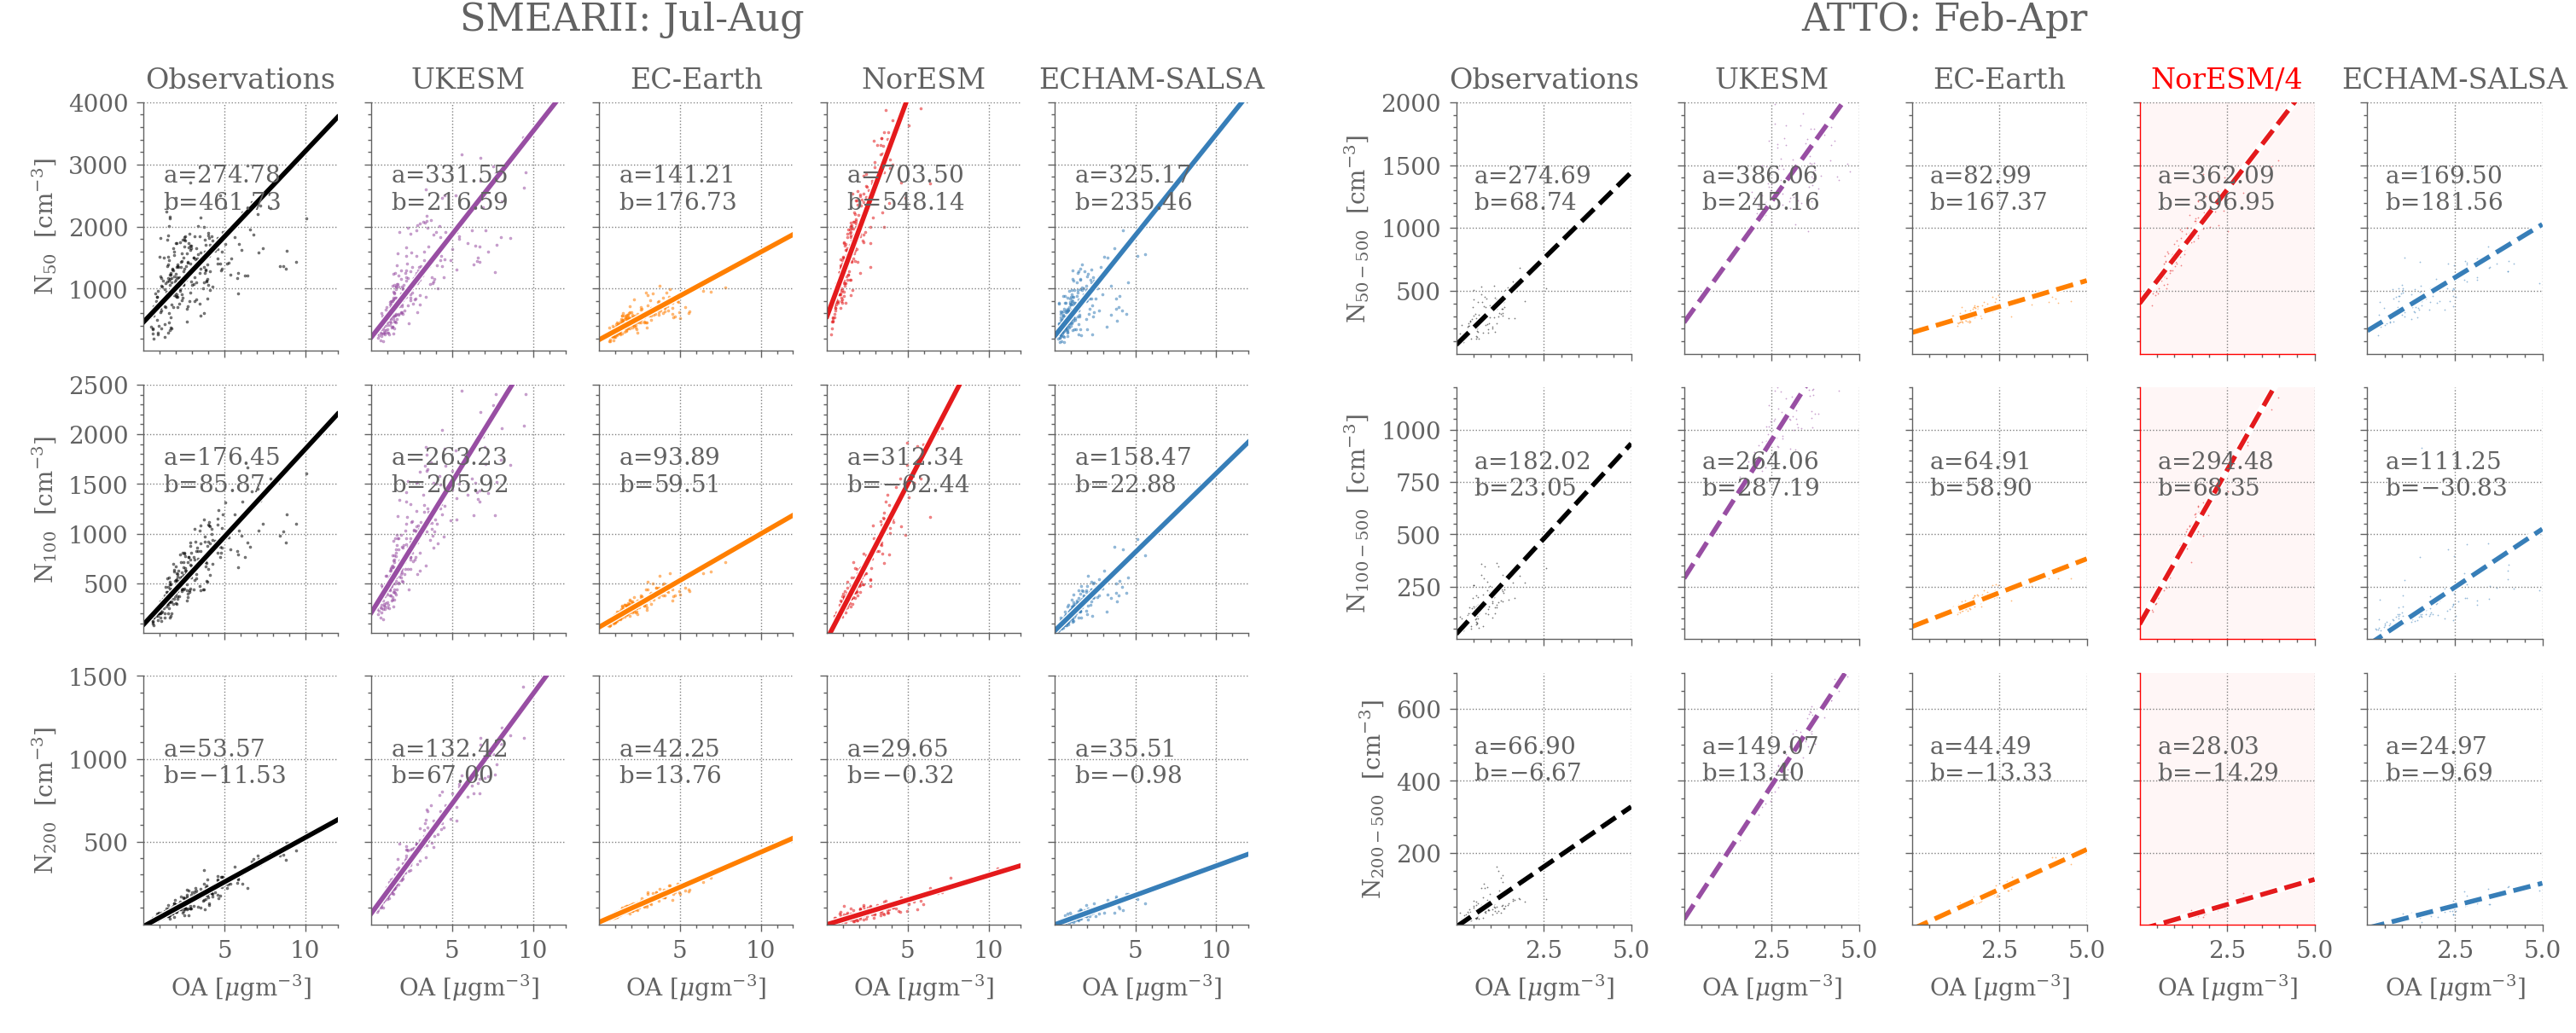

In [30]:
fig_main = plt.figure(constrained_layout=True,
                  figsize=[15,6],
                 )
spec2 = gridspec.GridSpec( nrows=2,ncols=3, 
                          width_ratios=[4,.1,4],
                          height_ratios=[1,20], 
                          figure=fig_main)

markersize = 5

subfig1 =  fig_main.add_subfigure(spec2[1, 0],frameon=True)
subfig2 =  fig_main.add_subfigure(spec2[1, 1])
subfig3 =  fig_main.add_subfigure(spec2[1, 2],frameon=True)
subfig_up =  fig_main.add_subfigure(spec2[0, 0])
subfig_up2 =  fig_main.add_subfigure(spec2[0, -1])

ax_dum = subfig_up.subplots(1)
ax_dum.axis('off')
ax_dum2 = subfig_up2.subplots(1)
ax_dum2.axis('off')


axs_smr = subfig1.subplots(3,5, sharex='col', sharey='row')
#ax_fits = subfig2.subplots(3,1, sharex='col', sharey='row')
axs_atto =subfig3.subplots(3,5, sharex='col', sharey='row')
#subfig2.set_facecolor('#e9f2f9')##e5f8f8')
# subfig3.set_facecolor('#fff4ea')

dic_fits = {}
dic_fits['SMR'] =dict()
dic_fits['ATTO'] =dict()

#subfig1.suptitle('SMEARII, Jul & Aug')
#subfig3.suptitle('ATTO, JFM')
#subfig2.suptitle('Fits')



divide_NorESM_by_factor = 4


varlistplot = ['N50','N100','N200']
xlab = r'OA [$\mu$gm$^{-3}$]'
alpha_scatt = 0.4
source_list = models_and_obs[::-1]
v_x = 'OA'

## Settings
dic_lims = {
    'N50': {'xlims':[.01,12], 'ylims':[1,4000]},
    'N100': {'xlims':[.01,12], 'ylims':[1,2500]},
    'N200': {'xlims':[.01,12], 'ylims':[1,1500]},
    'N50-500': {'xlims':[.01,5], 'ylims':[1,2000]},
    'N100-500': {'xlims':[.01,5], 'ylims':[1,1200]},
    'N200-500': {'xlims':[.01,5], 'ylims':[1,700]},

}

dic_ylabels = {
    'N50' : r'N$_{50}$  [cm$^{-3}$]',
    'N100' : r'N$_{100}$  [cm$^{-3}$]',
    'N200' : r'N$_{200}$  [cm$^{-3}$]',
    'N50-500' : r'N$_{50-500}$  [cm$^{-3}$]',
    'N100-500' : r'N$_{100-500}$  [cm$^{-3}$]',
    'N200-500' : r'N$_{200-500}$  [cm$^{-3}$]',

}




select_station = 'SMR'
season = 'JA'


xscale='linear'
yscale='linear'


# OBS: 

dic_df_med = dic_df_med_SMR
axs_all = axs_smr
fig = subfig1


#fig, axs_all = plt.subplots(3,6,figsize=figsize, sharey='row', sharex='col')
## Settings
legends_smr = []
legends_atto = []
legs =[]

for i,v_y in enumerate(varlistplot):
    dic_fits[select_station][v_y] = dict()
    # Make plot
    ylab = dic_ylabels[v_y]
    ylims = dic_lims[v_y]['ylims']
    xlims = dic_lims[v_y]['xlims']
    
    axs_sub = axs_all[i,:]
    axs_sub[0].set_ylabel(ylab)
    make_plot2(v_x, v_y, xlims, ylims, season, 
              xlab=xlab, ylab=ylab, alpha_scat=alpha_scatt,
             source_list = source_list, fig=fig, 
               axs=axs_sub,
              xscale='linear', yscale='linear',
              dic_df_med = dic_df_med,
           select_station= select_station,
               markersize=markersize,
         )

    
    for mo, ax in zip(source_list, axs_sub):
        dic_fits[select_station][v_y][mo] = dict()

        df_s =  dic_df_med[mo]
        
        print(mo)
        mask_months = select_months(df_s, season=season)
        df_s = df_s[mask_months].copy()
        popt, pov, label, func = func_smr_lin(df_s,v_x,v_y)
            
            
        legends_smr.append(label)

        plot_fit(func, popt, mo, xlims, yscale, xscale, ax, label,)
        #plot_fit(func, popt, mo, xlims, yscale, xscale,  ax_fits[i],label,extra_plot=True)

        dic_fits[select_station][v_y][mo]['label'] = label
        dic_fits[select_station][v_y][mo]['popt'] = popt
        dic_fits[select_station][v_y][mo]['pcov'] = pov
        dic_fits[select_station][v_y][mo]['standard_error'] = np.sqrt(np.diag(dic_fits[select_station][v_y][mo]['pcov']))
        
        dic_fits[select_station][v_y][mo]['func'] = func
        dic_fits[select_station][v_y][mo]['R2'] = get_r2(df_s,v_x,v_y, popt, func)
        dic_fits[select_station][v_y][mo]['corr'] = get_corr(df_s,v_x,v_y)
        print( get_r2(df_s,v_x,v_y, popt, func))
        dic_fits[select_station][v_y][mo] = calc_table_se(dic_fits[select_station][v_y][mo])   

        _a = label.split('x')[0][1:]
        _b = label.split('x')[1][:-1]
        if _b[0]=='+':
            _b=_b[1:]
        ax.text(left, top, f'a=${_a}$ \nb=${_b}$',
        horizontalalignment='left',
        verticalalignment='top',
        transform=ax.transAxes)
        
        
        ax.set_yscale(yscale)
        ax.set_xscale(xscale)
    #leg = axs_sub[-1].legend(bbox_to_anchor=(1,1,), frameon=False)

    #legs.append(leg)


    
for ax in axs_sub:
    ax.set_xlabel(xlab)
sns.despine(fig) 








varlistplot = ['N50-500','N100-500','N200-500']

select_station = 'ATTO'
season = 'FMA'

xscale='linear'
yscale='linear'


# OBS: 

dic_df_med = dic_df_med_ATTO
axs_all = axs_atto
fig = subfig3
select_station = 'ATTO'


#fig, axs_all = plt.subplots(3,6,figsize=figsize, sharey='row', sharex='col')
## Settings

legs =[]

for i,v_y in enumerate(varlistplot):
    dic_fits[select_station][v_y] = dict()
    
    # Make plot
    ylab = dic_ylabels[v_y]
    ylims = dic_lims[v_y]['ylims']
    xlims = dic_lims[v_y]['xlims']
    axs_sub = axs_all[i,:]
    axs_sub[0].set_ylabel(ylab)

    make_plot2(v_x, v_y, xlims, ylims, season, 
              xlab=xlab, ylab=ylab, alpha_scat=alpha_scatt,
             source_list = source_list, fig=fig, 
               axs=axs_sub,
              xscale='linear', yscale='linear',
              dic_df_med = dic_df_med,
           select_station= select_station,
               divide_NorESM_by_factor=divide_NorESM_by_factor,
         )


    for mo, ax in zip(source_list, axs_sub):
        dic_fits[select_station][v_y][mo] = dict()
        
        df_s =  dic_df_med[mo]
        print(mo)
        mask_months = select_months(df_s, season=season)
        df_s = df_s[mask_months].copy()
        if (mo =='NorESM') &  (divide_NorESM_by_factor is not None):
            df_s = df_s/divide_NorESM_by_factor
            ax.set_facecolor('#fff6f6')
    
        popt, pov, label, func = func_atto(df_s,v_x,v_y)
        legends_atto.append(label)
        
        plot_fit(func, popt, mo, xlims, yscale, xscale, ax,label, linestyle='dashed')
        #plot_fit(func, popt, mo, xlims, yscale, xscale,  ax_fits[i],label,  extra_plot=True,linestyle='dashed',)
        ax.set_xlim(xlims)
        #dic_fits['ATTO'][v_y][mo]['label'] = label
        #dic_fits['ATTO'][v_y][mo]['popt'] = popt
        #dic_fits['ATTO'][v_y][mo]['pov'] = pov 
        
        dic_fits[select_station][v_y][mo]['label'] = label
        dic_fits[select_station][v_y][mo]['popt'] = popt
        dic_fits[select_station][v_y][mo]['pcov'] = pov
        dic_fits[select_station][v_y][mo]['standard_error'] = np.sqrt(np.diag(dic_fits[select_station][v_y][mo]['pcov']))
        
        #dic_fits[select_station][v_y][mo]['func'] = func
        dic_fits[select_station][v_y][mo]['R2'] = get_r2(df_s,v_x,v_y, popt, func)
        dic_fits[select_station][v_y][mo]['corr'] = get_corr(df_s,v_x,v_y)
        dic_fits[select_station][v_y][mo] = calc_table_se(dic_fits[select_station][v_y][mo])        

        _a = label.split('x')[0][1:]
        _b = label.split('x')[1][:-1]
        if _b[0]=='+':
            _b=_b[1:]
        ax.text(left, top, f'a=${_a}$ \nb=${_b}$',
        horizontalalignment='left',
        verticalalignment='top',
        transform=ax.transAxes)

        ax.set_yscale(yscale)
        ax.set_xscale(xscale)
        #ax.legend(frameon=False, fontsize=10)
    
    #leg = axs_sub[-1].legend(bbox_to_anchor=(1,1,), frameon=False)

    #legs.append(leg)


    
for ax in axs_sub:
    ax.set_xlabel(xlab)
sns.despine(fig) 



sns.despine(subfig2) 
subfig1.suptitle('SMEARII: Jul-Aug', size=16, y=1.05, zorder=100000)
subfig_up.suptitle('SMEARII: Jul-Aug', size=16, y=1., zorder=100000)
#subfig2.suptitle('F', size=16, y=1.05, c='w')
subfig3.suptitle(f'ATTO: {dic_season_nicename[season]}', size=16, y=1.05,zorder=100000)
subfig_up2.suptitle(f'ATTO: {dic_season_nicename[season]}', size=16, y=1.0,zorder=100000)

#axs_all = list(ax_fits.flatten())+list(axs_smr.flatten())+ list(axs_atto.flatten())
axs_all = list(list(axs_smr.flatten())+ list(axs_atto.flatten()))
for ax in axs_all:
    ax.grid(color = 'grey', linestyle = ':', linewidth = 0.5)

for ax in axs_atto[1:,:].flatten():
    ax.set_title('')


for ax in axs_smr[1:,:].flatten():
    ax.set_title('')

#ax_fits[0].set_title('.', color='w')
fn = make_fn_scat(f'together_{season}_bothlin', v_x, 'Nx')
print(fn)
plt.savefig(fn.with_suffix('.pdf'),bbox_inches='tight', dpi=200)
plt.savefig(fn.with_suffix('.png'),bbox_inches='tight', dpi=200)

df = make_pd_of_dic(dic_fits)
df_linear = df.copy()
df.to_csv(fn.with_suffix('.csv'))

plt.show()

In [31]:
df

Fit R$^2$                 a  \
station variable data source                                               
SMR     N50      Observations  $274.78x+ 461.73$  0.01  274.8 $\pm$ 28.7   
                 UKESM         $331.55x+ 216.59$  0.62  331.5 $\pm$ 31.6   
                 EC-Earth      $141.21x+ 176.73$  0.61  141.2 $\pm$ 14.0   
                 NorESM        $703.50x+ 548.14$  0.82  703.5 $\pm$ 65.2   
                 ECHAM-SALSA   $325.17x+ 235.46$  0.24  325.2 $\pm$ 32.7   
        N100     Observations   $176.45x+ 85.87$  0.69  176.5 $\pm$ 16.6   
                 UKESM         $263.23x+ 205.92$  0.71  263.2 $\pm$ 24.8   
                 EC-Earth        $93.89x+ 59.51$  0.82    93.9 $\pm$ 9.0   
                 NorESM        $312.34x+ -62.44$  0.94  312.3 $\pm$ 28.5   
                 ECHAM-SALSA    $158.47x+ 22.88$  0.74  158.5 $\pm$ 14.8   
        N200     Observations   $53.57x+ -11.53$  0.89    53.6 $\pm$ 4.9   
                 UKESM          $132.42x+ 67.00$  0.95  132.4 $\pm$ 12.1   
                 EC-Earth        $42.25x+ 13.76$  0.91    42.3 $\pm$ 4.0   
                 NorESM          $29.65x+ -0.32$  0.79    29.6 $\pm$ 2.8   
                 ECHAM-SALSA     $35.51x+ -0.98$  0.81    35.5 $\pm$ 3.3   
ATTO    N50-500  Observations   $274.69x+ 68.74$  0.32  274.7 $\pm$ 43.8   
                 UKESM         $386.06x+ 245.16$ -0.27  386.1 $\pm$ 67.9   
                 EC-Earth       $82.99x+ 167.37$  0.46   83.0 $\pm$ 12.9   
                 NorESM        $362.09x+ 396.95$  0.81  362.1 $\pm$ 53.8   
                 ECHAM-SALSA   $169.50x+ 181.56$  0.26  169.5 $\pm$ 27.3   
        N100-500 Observations   $182.02x+ 23.05$  0.36  182.0 $\pm$ 28.8   
                 UKESM         $264.06x+ 287.19$  0.38  264.1 $\pm$ 41.7   
                 EC-Earth        $64.91x+ 58.90$  0.81    64.9 $\pm$ 9.7   
                 NorESM         $294.48x+ 68.35$  0.96  294.5 $\pm$ 42.9   
                 ECHAM-SALSA   $111.25x+ -30.83$  0.08  111.3 $\pm$ 18.4   
        N200-500 Observations    $66.90x+ -6.67$  0.06   66.9 $\pm$ 11.1   
                 UKESM          $149.07x+ 13.40$  0.95  149.1 $\pm$ 21.8   
                 EC-Earth       $44.49x+ -13.33$  0.94    44.5 $\pm$ 6.5   
                 NorESM         $28.03x+ -14.29$  0.93    28.0 $\pm$ 4.1   
                 ECHAM-SALSA     $24.97x+ -9.69$  0.88    25.0 $\pm$ 3.7   

                                               b c r$^2$  
station variable data source                              
SMR     N50      Observations   461.7 $\pm$ 96.3    0.51  
                 UKESM         216.6 $\pm$ 103.1    0.81  
                 EC-Earth       176.7 $\pm$ 34.1    0.81  
                 NorESM        548.1 $\pm$ 155.9    0.91  
                 ECHAM-SALSA    235.5 $\pm$ 49.9    0.62  
        N100     Observations    85.9 $\pm$ 57.2    0.85  
                 UKESM          205.9 $\pm$ 81.2    0.85  
                 EC-Earth        59.5 $\pm$ 22.2    0.91  
                 NorESM         -62.4 $\pm$ 68.6    0.97  
                 ECHAM-SALSA     22.9 $\pm$ 23.2    0.87  
        N200     Observations   -11.5 $\pm$ 17.0    0.95  
                 UKESM           67.0 $\pm$ 40.0    0.98  
                 EC-Earth         13.8 $\pm$ 9.9    0.96  
                 NorESM         -0.32 $\pm$ 6.59    0.89  
                 ECHAM-SALSA    -0.98 $\pm$ 5.17     0.9  
ATTO    N50-500  Observations    68.7 $\pm$ 40.9    0.66  
                 UKESM         245.2 $\pm$ 214.8    0.36  
                 EC-Earth       167.4 $\pm$ 26.4    0.73  
                 NorESM         396.9 $\pm$ 81.3    0.91  
                 ECHAM-SALSA    181.6 $\pm$ 55.3    0.63  
        N100-500 Observations    23.0 $\pm$ 27.0    0.68  
                 UKESM         287.2 $\pm$ 132.4    0.69  
                 EC-Earth        58.9 $\pm$ 19.8     0.9  
                 NorESM          68.4 $\pm$ 65.1    0.98  
                 ECHAM-SALSA    -30.8 $\pm$ 37.0    0.54  
        N200-500 Ob

### Residual SMR ln

ECHAM-SALSA
NorESM
EC-Earth
UKESM
Observations


/proj/bolinc/users/x_sarbl/analysis/BS-FDBCK/bs_fdbck/util/BSOA_datamanip/fits.py:528: RuntimeWarning: invalid value encountered in log
  return a + b * np.log(c + x)
/proj/bolinc/users/x_sarbl/analysis/BS-FDBCK/bs_fdbck/util/BSOA_datamanip/fits.py:528: RuntimeWarning: invalid value encountered in log
  return a + b * np.log(c + x)
/proj/bolinc/users/x_sarbl/analysis/BS-FDBCK/bs_fdbck/util/BSOA_datamanip/fits.py:528: RuntimeWarning: invalid value encountered in log
  return a + b * np.log(c + x)
/proj/bolinc/users/x_sarbl/analysis/BS-FDBCK/bs_fdbck/util/BSOA_datamanip/fits.py:528: RuntimeWarning: invalid value encountered in log
  return a + b * np.log(c + x)
/proj/bolinc/users/x_sarbl/analysis/BS-FDBCK/bs_fdbck/util/BSOA_datamanip/fits.py:528: RuntimeWarning: invalid value encountered in log
  return a + b * np.log(c + x)


Plots/Both_stations/scat_all_years_2stations_residual_ln_JA_SMR_OA_N50.png


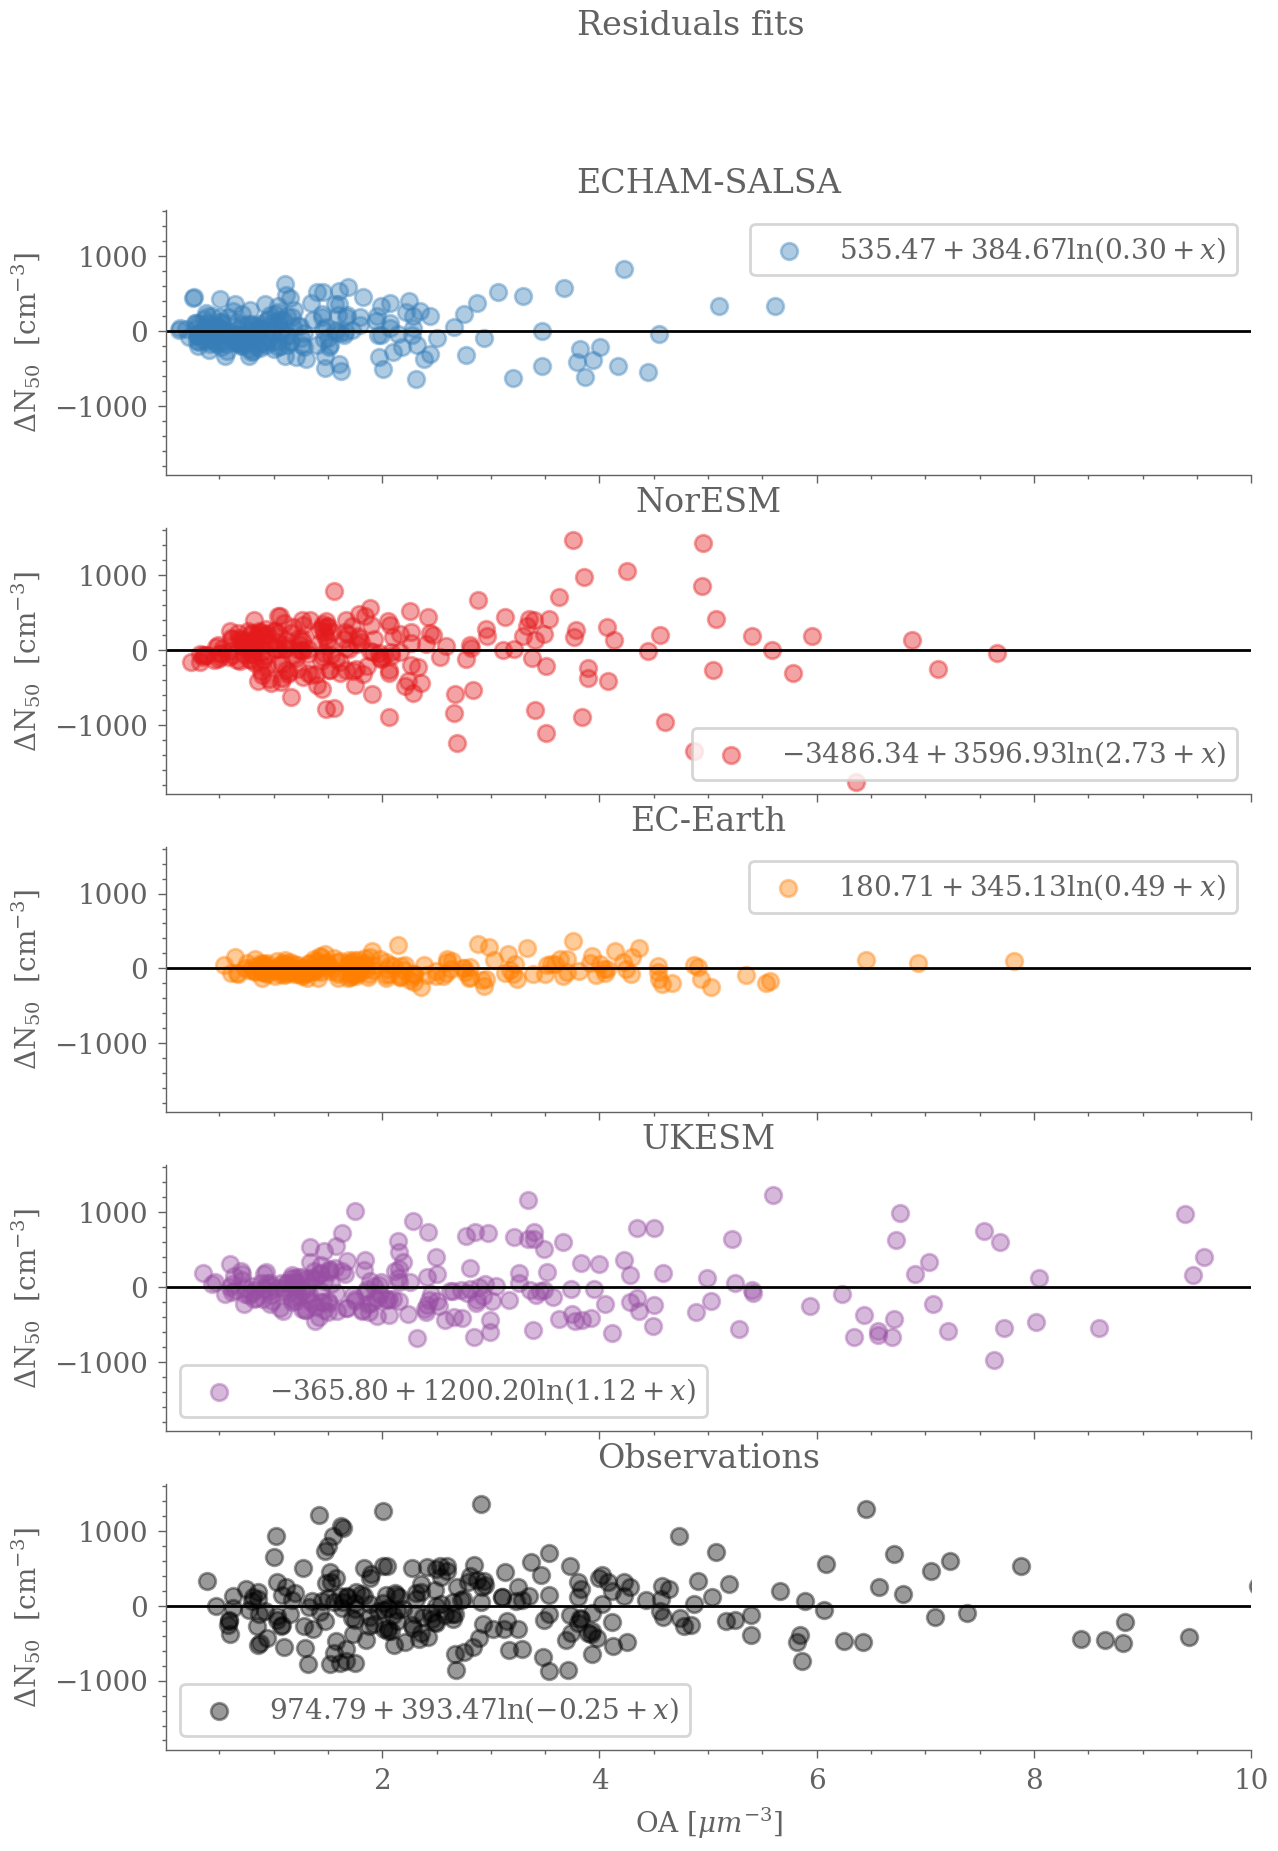

ECHAM-SALSA
NorESM
[302.68639399 -43.92947774]
Beta: [312.33767766 -62.4395137 ]
Beta Std Error: [ 5.03031372 12.1031752 ]
Beta Covariance: [[  812.17825969 -1557.66341263]
 [-1557.66341263  4701.75351939]]
Residual Variance: 0.03115579096414946
Inverse Condition #: 0.2163604767814529
Reason(s) for Halting:
  Sum of squares convergence
[312.33767766 -62.4395137 ]
reason for haltng
EC-Earth
UKESM
Observations


/proj/bolinc/users/x_sarbl/analysis/BS-FDBCK/bs_fdbck/util/BSOA_datamanip/fits.py:528: RuntimeWarning: invalid value encountered in log
  return a + b * np.log(c + x)
/proj/bolinc/users/x_sarbl/analysis/BS-FDBCK/bs_fdbck/util/BSOA_datamanip/fits.py:528: RuntimeWarning: invalid value encountered in log
  return a + b * np.log(c + x)
/proj/bolinc/users/x_sarbl/analysis/BS-FDBCK/bs_fdbck/util/BSOA_datamanip/fits.py:528: RuntimeWarning: invalid value encountered in log
  return a + b * np.log(c + x)
/proj/bolinc/users/x_sarbl/analysis/BS-FDBCK/bs_fdbck/util/BSOA_datamanip/fits.py:528: RuntimeWarning: invalid value encountered in log
  return a + b * np.log(c + x)
/proj/bolinc/users/x_sarbl/analysis/BS-FDBCK/bs_fdbck/util/BSOA_datamanip/fits.py:528: RuntimeWarning: invalid value encountered in log
  return a + b * np.log(c + x)


Plots/Both_stations/scat_all_years_2stations_residual_ln_JA_SMR_OA_N100.png


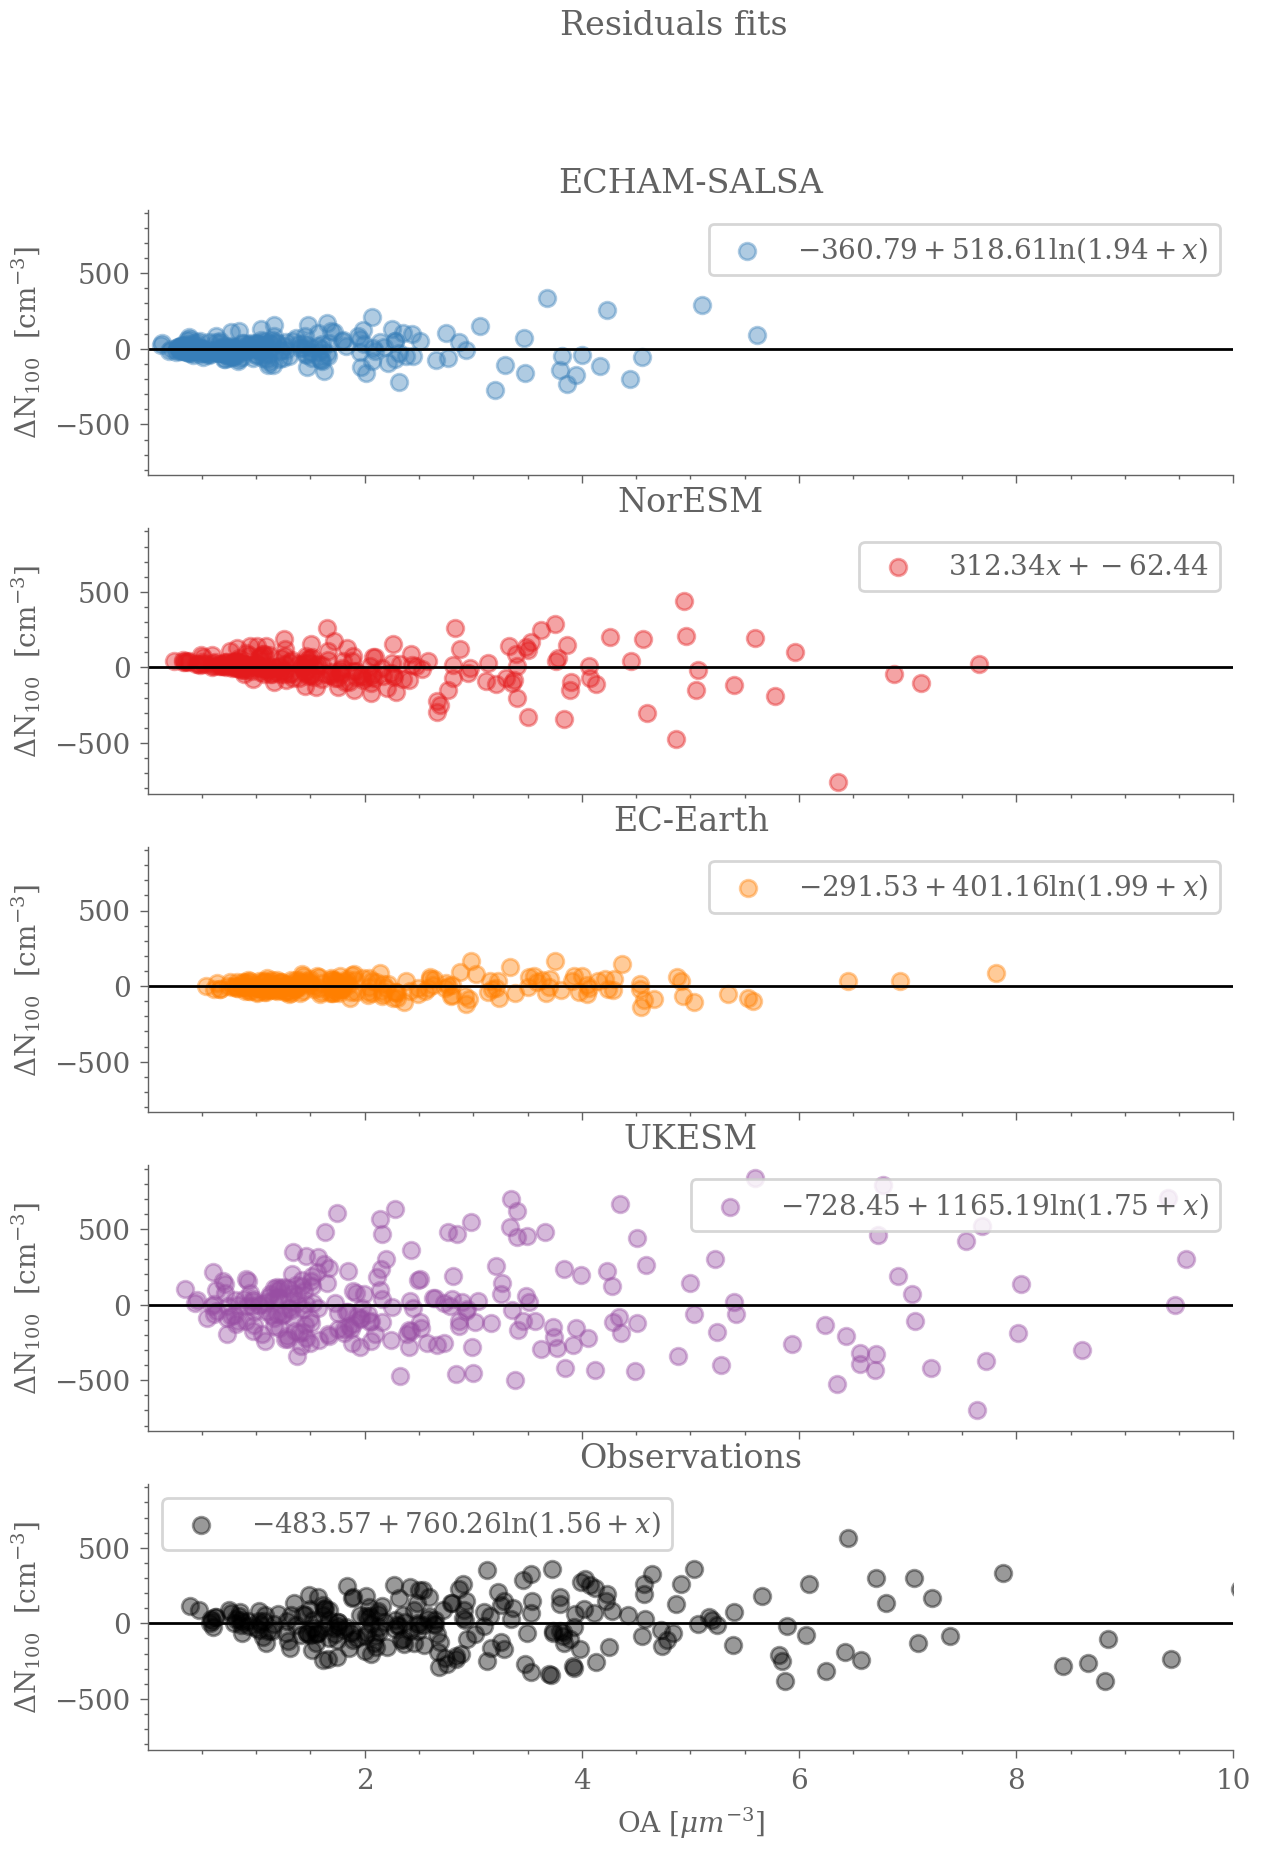

In [32]:
select_station = 'SMR'

figsize=[7,10]
## Settings
alpha_scatt = 0.5


divide_NorESM_by_factor = 2


varlistplot = ['N50','N100']
xlab = r'OA [$\mu m^{-3}$]'
alpha_scatt = 0.4
source_list = models_and_obs[::-1]
v_x = 'OA'

## Settings
dic_lims = {
    'N50': {'xlims':[.01,10], 'ylims':[1,5000]},
    'N100': {'xlims':[.01,10], 'ylims':[1,3000]},
    'N200': {'xlims':[.01,10], 'ylims':[1,200]},
    'N50-500': {'xlims':[.01,10], 'ylims':[1,5000]},
    'N100-500': {'xlims':[.01,10], 'ylims':[1,3000]},
    'N200-500': {'xlims':[.01,10], 'ylims':[1,200]},

}

dic_ylabels = {
    'N50' : r'$\Delta$N$_{50}$  [cm$^{-3}$]',
    'N100' : r'$\Delta$N$_{100}$  [cm$^{-3}$]',
    'N200' : r'$\Delta$N$_{200}$  [cm$^{-3}$]',
    'N50-500' : r'$\Delta$N$_{50-500}$  [cm$^{-3}$]',
    'N100-500' : r'$\Delta$N$_{100-500}$  [cm$^{-3}$]',
    'N200-500' : r'$\Delta$N$_{200-500}$  [cm$^{-3}$]',

}






xscale='linear'
yscale='linear'


if select_station=='SMR':
    varlistplot = ['N50','N100']
    
    dic_df_med = dic_df_med_SMR
    season = 'JA'
    func_station = func_smr
    divide_NorESM_by_factor = None
    
elif select_station=='ATTO':
    dic_df_med = dic_df_med_ATTO
    season = 'JFM'
    func_station = func_atto
    
    divide_NorESM_by_factor = 2
    varlistplot = ['N50-500','N100-500','N200-500']


for i,v_y in enumerate(varlistplot):
    #dic_fits[select_station][v_y] = dict()
    fig, axs = plt.subplots(len(models_and_obs), sharex=True, sharey= True, figsize=figsize)
    
    for mo, ax in zip(models_and_obs, axs):

        df_s =  dic_df_med[mo]
        print(mo)
        
        mask_months = select_months(df_s, season=season)
        df_s = df_s[mask_months].copy()
        
        if (mo =='NorESM') &  (divide_NorESM_by_factor is not None):
            df_s = df_s/divide_NorESM_by_factor
            ax.set_facecolor('#fff6f6')
            title = f'{mo}/{divide_NorESM_by_factor}'
            print(title)
            ax.spines['bottom'].set_color('r')
            ax.spines['top'].set_color('r') 
            ax.spines['right'].set_color('red')
            ax.spines['left'].set_color('red')
            ax.set_title(title, c='r')
        else:
            title=mo
            
            ax.set_title(title, )
    
        popt, pov, label, func = func_station(df_s,v_x,v_y)
        #legends_atto.append(label)


        _ma = df_s[v_x].max() 
        _mi = df_s[v_x].min() 
        ax.scatter(df_s[v_x],df_s[v_y]-func(df_s[v_x],*popt),
                                    color=cdic_model[mo], 
                #alpha=alpha_scatt, 
                #facecolor='none',
               alpha=alpha_scatt,
               
                edgecolor=cdic_model[mo],

                label=label
                   )
        #plt.show()
        xlims = dic_lims[v_y]['xlims']
        ax.set_yscale(yscale)
        ax.set_xscale(xscale)


        ax.hlines(0, xmin=xlims[0],xmax=xlims[1], color='k', linewidth=1)
        ax.legend(frameon=False)
        ylab = dic_ylabels[v_y]
        ax.set_ylabel(ylab)
        ax.set_xlim(xlims)
        ax.legend(frameon=True)

        
    #fig.suptitle('Observations')
    axs[-1].set_xlabel(xlab)
    fig.suptitle(r'Residuals fits')

    sns.despine(fig)    
    
    fn = make_fn_scat(f'residual_ln_{season}_{select_station}', v_x, v_y)
    fig.savefig(fn, dpi=150)
    fig.savefig(fn.with_suffix('.pdf'), dpi=150)
    print(fn)
    plt.show()

### Residual SMR linear

ECHAM-SALSA
[202.02578986 388.34369982]
Beta: [325.16913944 235.45785051]
Beta Std Error: [20.20516015 30.80934736]
Beta Covariance: [[ 1069.13128717 -1327.35590416]
 [-1327.35590416  2485.83009792]]
Residual Variance: 0.3818506685595091
Inverse Condition #: 0.2918381802224606
Reason(s) for Halting:
  Sum of squares convergence
[325.16913944 235.45785051]
reason for haltng
NorESM
[641.02356871 667.97212569]
Beta: [703.50350512 548.1428231 ]
Beta Std Error: [19.49825332 46.66156544]
Beta Covariance: [[ 4245.23055748 -8141.86033953]
 [-8141.86033953 24312.43594603]]
Residual Variance: 0.08955506121998956
Inverse Condition #: 0.21475407039471198
Reason(s) for Halting:
  Sum of squares convergence
[703.50350512 548.1428231 ]
reason for haltng
EC-Earth
[113.70926947 234.88660619]
Beta: [141.20962611 176.72952346]
Beta Std Error: [ 6.18409531 15.09924399]
Beta Covariance: [[ 194.63722508 -411.61404379]
 [-411.61404379 1160.33652164]]
Residual Variance: 0.1964836622310401
Inverse Condition #:

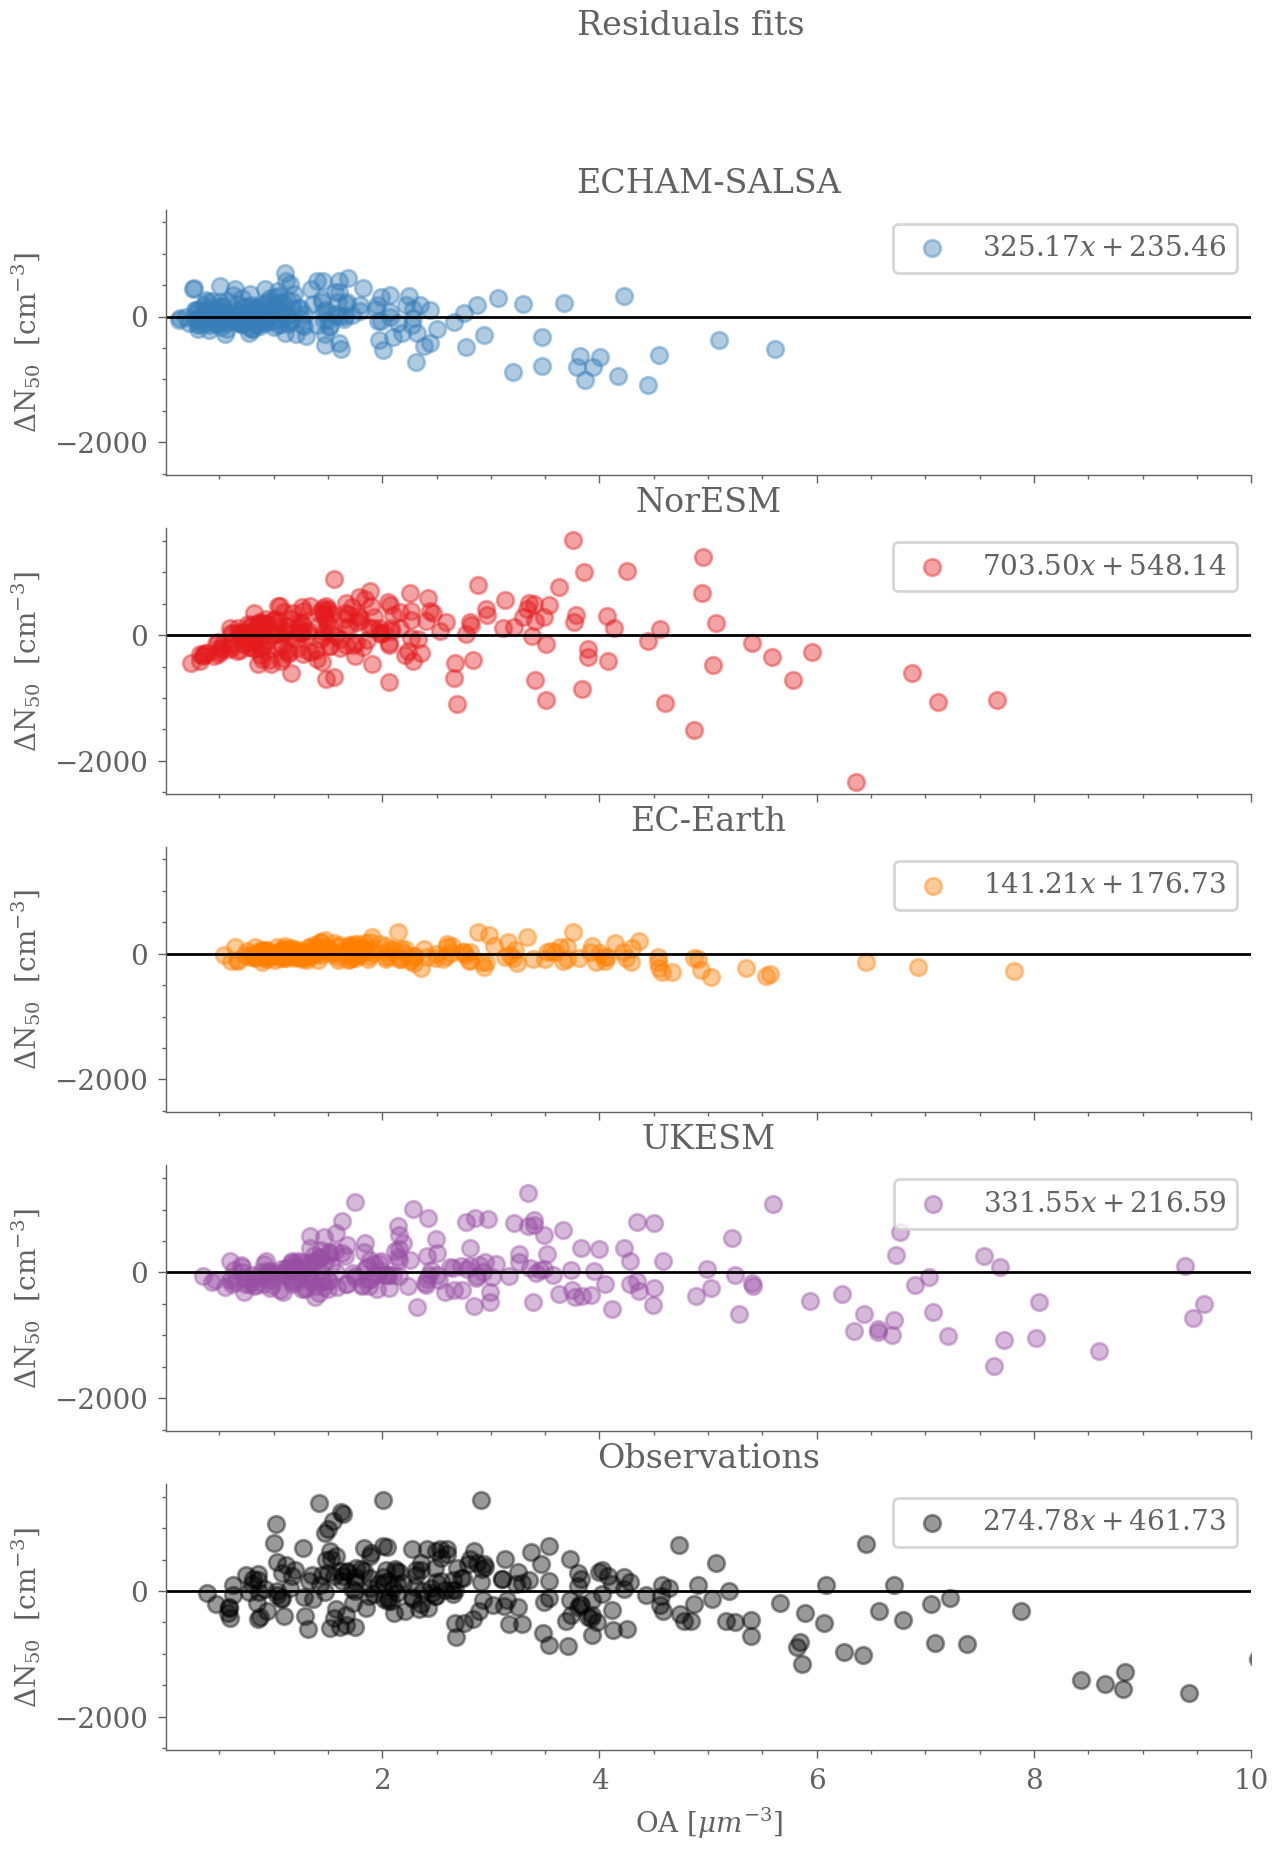

ECHAM-SALSA
[138.197521    48.04536519]
Beta: [158.46809548  22.87888004]
Beta Std Error: [5.32563625 8.3296595 ]
Beta Covariance: [[ 219.90211818 -273.0145604 ]
 [-273.0145604   537.94875925]]
Residual Variance: 0.1289773909924523
Inverse Condition #: 0.3042424801217555
Reason(s) for Halting:
  Sum of squares convergence
[158.46809548  22.87888004]
reason for haltng
NorESM
[302.68639399 -43.92947774]
Beta: [312.33767766 -62.4395137 ]
Beta Std Error: [ 5.03031372 12.1031752 ]
Beta Covariance: [[  812.17825969 -1557.66341263]
 [-1557.66341263  4701.75351939]]
Residual Variance: 0.03115579096414946
Inverse Condition #: 0.2163604767814529
Reason(s) for Halting:
  Sum of squares convergence
[312.33767766 -62.4395137 ]
reason for haltng
EC-Earth
[85.57791495 77.08271681]
Beta: [93.88929176 59.50602095]
Beta Std Error: [2.6941404  6.62625395]
Beta Covariance: [[  81.26416508 -171.8554668 ]
 [-171.8554668   491.5806529 ]]
Residual Variance: 0.0893184896315632
Inverse Condition #: 0.1733732867

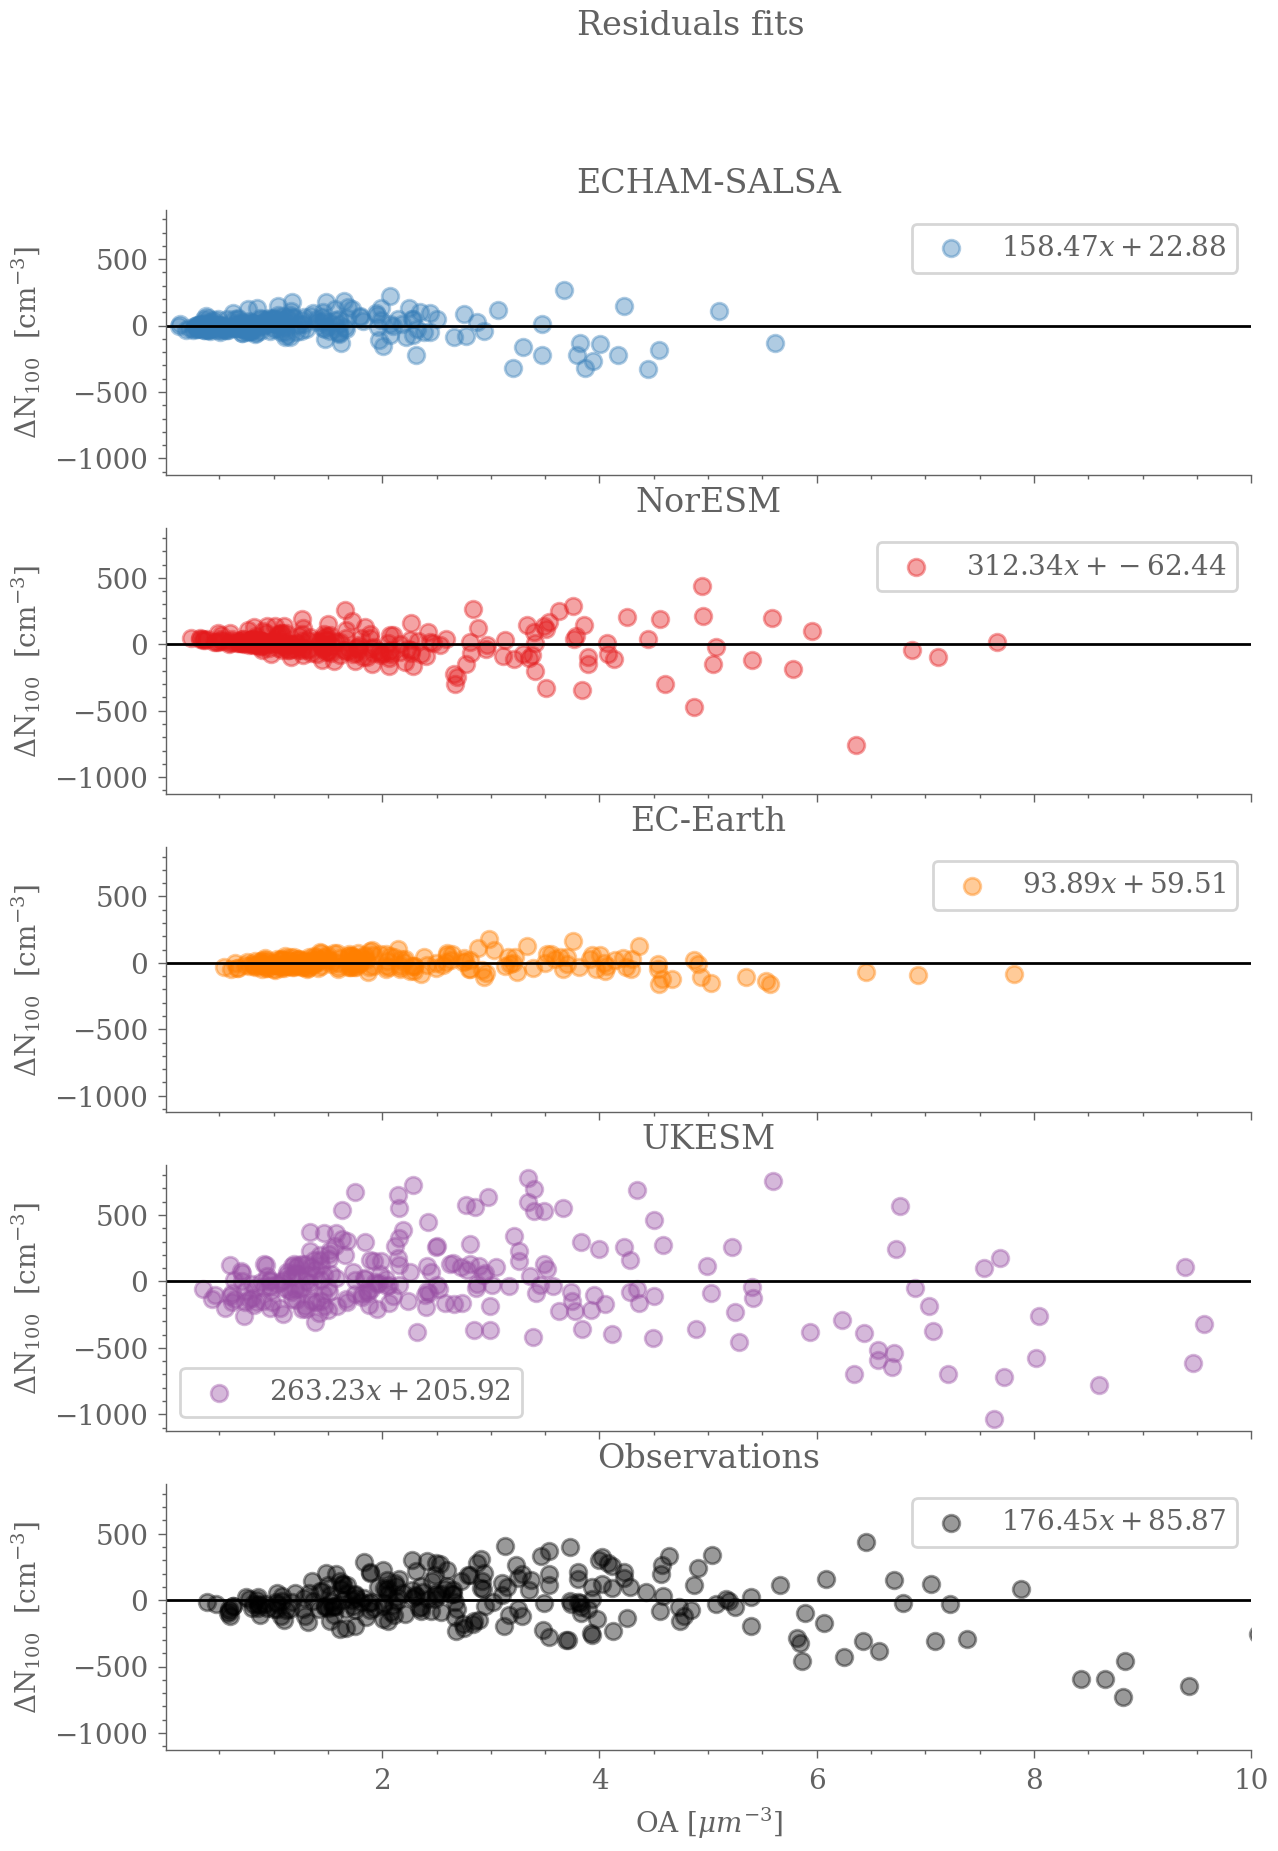

ECHAM-SALSA
[32.06152065  3.29858087]
Beta: [35.50844359 -0.98086904]
Beta Std Error: [1.0310883  1.61759544]
Beta Covariance: [[ 10.86206609 -13.48553664]
 [-13.48553664  26.73379123]]
Residual Variance: 0.0978766898075105
Inverse Condition #: 0.3056045355094191
Reason(s) for Halting:
  Sum of squares convergence
[35.50844359 -0.98086904]
reason for haltng
NorESM
[26.52874642  5.66334112]
Beta: [29.64958579 -0.3220885 ]
Beta Std Error: [0.89844835 2.14677789]
Beta Covariance: [[  7.60596659 -14.58734106]
 [-14.58734106  43.42525834]]
Residual Variance: 0.1061284484641519
Inverse Condition #: 0.21428414844388544
Reason(s) for Halting:
  Sum of squares convergence
[29.64958579 -0.3220885 ]
reason for haltng
EC-Earth
[40.35530872 17.77727258]
Beta: [42.25451546 13.76087584]
Beta Std Error: [0.85425383 2.10727492]
Beta Covariance: [[ 16.09243961 -34.0318978 ]
 [-34.0318978   97.92428642]]
Residual Variance: 0.04534735696441685
Inverse Condition #: 0.17467412056303702
Reason(s) for Halting

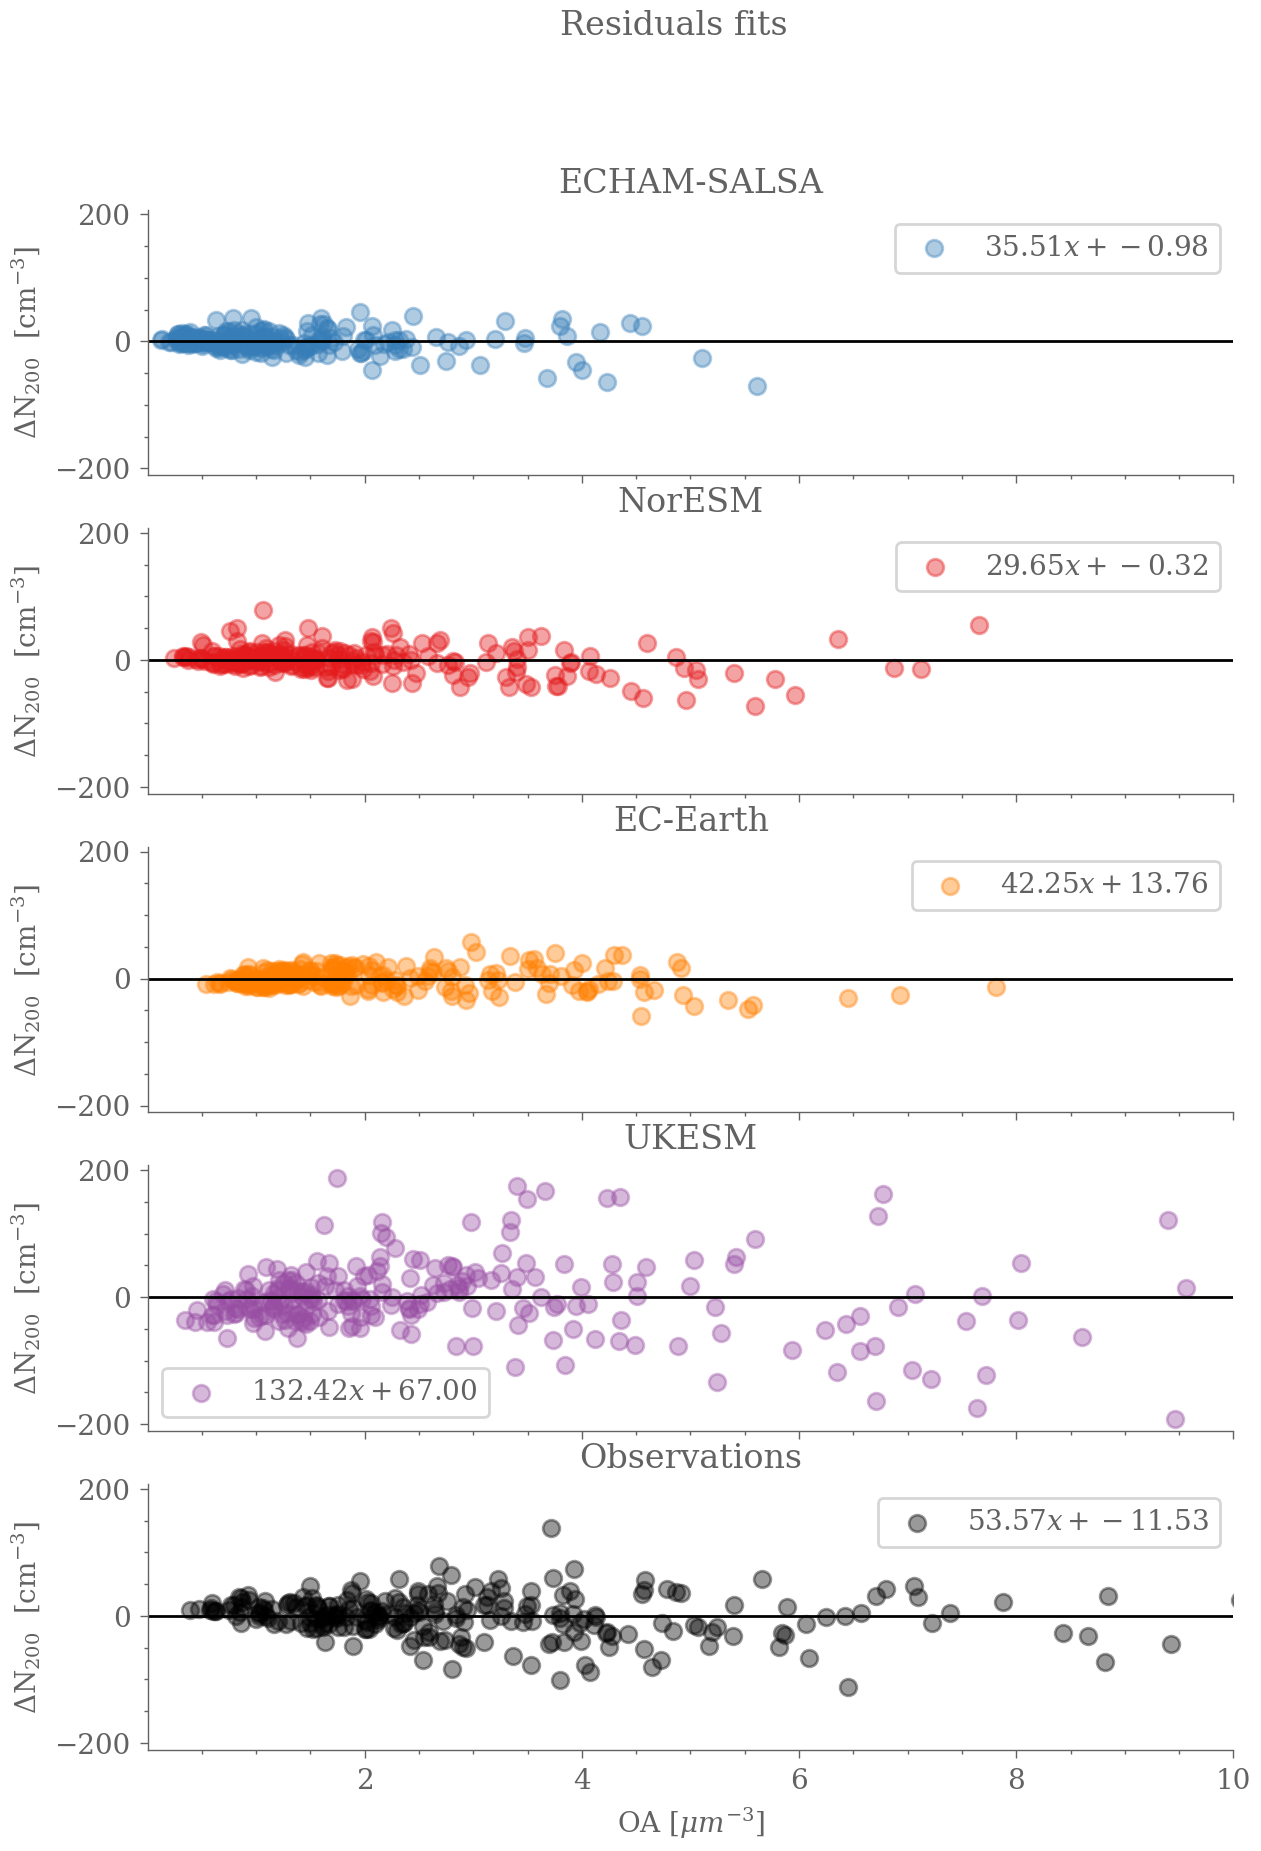

In [33]:
select_station = 'SMR'

## Settings
alpha_scatt = 0.5


divide_NorESM_by_factor = 2


varlistplot = ['N50','N100','N200']
xlab = r'OA [$\mu m^{-3}$]'
alpha_scatt = 0.4
source_list = models_and_obs[::-1]
v_x = 'OA'

## Settings
dic_lims = {
    'N50': {'xlims':[.01,10], 'ylims':[1,5000]},
    'N100': {'xlims':[.01,10], 'ylims':[1,3000]},
    'N200': {'xlims':[.01,10], 'ylims':[1,200]},
    'N50-500': {'xlims':[.01,10], 'ylims':[1,5000]},
    'N100-500': {'xlims':[.01,10], 'ylims':[1,3000]},
    'N200-500': {'xlims':[.01,10], 'ylims':[1,200]},

}

dic_ylabels = {
    'N50' : r'$\Delta$N$_{50}$  [cm$^{-3}$]',
    'N100' : r'$\Delta$N$_{100}$  [cm$^{-3}$]',
    'N200' : r'$\Delta$N$_{200}$  [cm$^{-3}$]',
    'N50-500' : r'$\Delta$N$_{50-500}$  [cm$^{-3}$]',
    'N100-500' : r'$\Delta$N$_{100-500}$  [cm$^{-3}$]',
    'N200-500' : r'$\Delta$N$_{200-500}$  [cm$^{-3}$]',

}






xscale='linear'
yscale='linear'


if select_station=='SMR':
    varlistplot = ['N50','N100','N200']
    
    dic_df_med = dic_df_med_SMR
    season = 'JA'
    func_station = func_smr
    divide_NorESM_by_factor = None
    
elif select_station=='ATTO':
    dic_df_med = dic_df_med_ATTO
    season = 'JFM'
    func_station = func_atto
    
    divide_NorESM_by_factor = 2
    varlistplot = ['N50-500','N100-500','N200-500']


for i,v_y in enumerate(varlistplot):
    #dic_fits[select_station][v_y] = dict()
    fig, axs = plt.subplots(len(models_and_obs), sharex=True, sharey= True, figsize=figsize)
    
    for mo, ax in zip(models_and_obs, axs):

        df_s =  dic_df_med[mo]
        print(mo)
        
        mask_months = select_months(df_s, season=season)
        df_s = df_s[mask_months].copy()
        
        if (mo =='NorESM') &  (divide_NorESM_by_factor is not None):
            df_s = df_s/divide_NorESM_by_factor
            ax.set_facecolor('#fff6f6')
            title = f'{mo}/{divide_NorESM_by_factor}'
            print(title)
            ax.spines['bottom'].set_color('r')
            ax.spines['top'].set_color('r') 
            ax.spines['right'].set_color('red')
            ax.spines['left'].set_color('red')
            ax.set_title(title, c='r')
        else:
            title=mo
            
            ax.set_title(title, )
    
        #popt, pov, label, func = func_station(df_s,v_x,v_y)
        #legends_atto.append(label)
        popt, pov, label, func = get_odr_fit_and_labs(df_s,v_x,v_y, fit_func='linear', return_func=True)
        


        _ma = df_s[v_x].max() 
        _mi = df_s[v_x].min() 
        ax.scatter(df_s[v_x],df_s[v_y]-func(df_s[v_x],*popt),
                                    color=cdic_model[mo], 
                #alpha=alpha_scatt, 
                #facecolor='none',
               alpha=alpha_scatt,
               
                edgecolor=cdic_model[mo],

                label=label
                   )
        #plt.show()
        xlims = dic_lims[v_y]['xlims']
        ax.set_yscale(yscale)
        ax.set_xscale(xscale)


        ax.hlines(0, xmin=xlims[0],xmax=xlims[1], color='k', linewidth=1)
        ax.legend(frameon=False)
        ylab = dic_ylabels[v_y]
        ax.set_ylabel(ylab)
        ax.set_xlim(xlims)
        ax.legend(frameon=True)

        
    #fig.suptitle('Observations')
    axs[-1].set_xlabel(xlab)
    fig.suptitle(r'Residuals fits')

    sns.despine(fig)    
    
    fn = make_fn_scat(f'residual_linear_{season}_{select_station}', v_x, v_y)
    fig.savefig(fn, dpi=150)
    fig.savefig(fn.with_suffix('.pdf'), dpi=150)
    print(fn)
    plt.show()

### Residual ATTO linear

ECHAM-SALSA
[106.60121343 292.52723749]
Beta: [169.49980892 181.55651735]
Beta Std Error: [16.77925502 34.0196151 ]
Beta Covariance: [[  742.65406821 -1310.24960793]
 [-1310.24960793  3052.81161943]]
Residual Variance: 0.37910436527228725
Inverse Condition #: 0.1933667747760285
Reason(s) for Halting:
  Sum of squares convergence
[169.49980892 181.55651735]
reason for haltng
NorESM
NorESM/4
[327.90679396 443.06787134]
Beta: [362.09485366 396.94681598]
Beta Std Error: [16.7166531  25.25131131]
Beta Covariance: [[ 2897.04845529 -3908.23374646]
 [-3908.23374646  6610.35785444]]
Residual Variance: 0.09645903244494503
Inverse Condition #: 0.21468782023721789
Reason(s) for Halting:
  Sum of squares convergence
[362.09485366 396.94681598]
reason for haltng
EC-Earth
[ 60.69115754 210.50340055]
Beta: [ 82.99022239 167.36874162]
Beta Std Error: [ 6.78074653 13.8137401 ]
Beta Covariance: [[ 167.50272058 -324.01235854]
 [-324.01235854  695.16741215]]
Residual Variance: 0.2744941896240799
Inverse Co

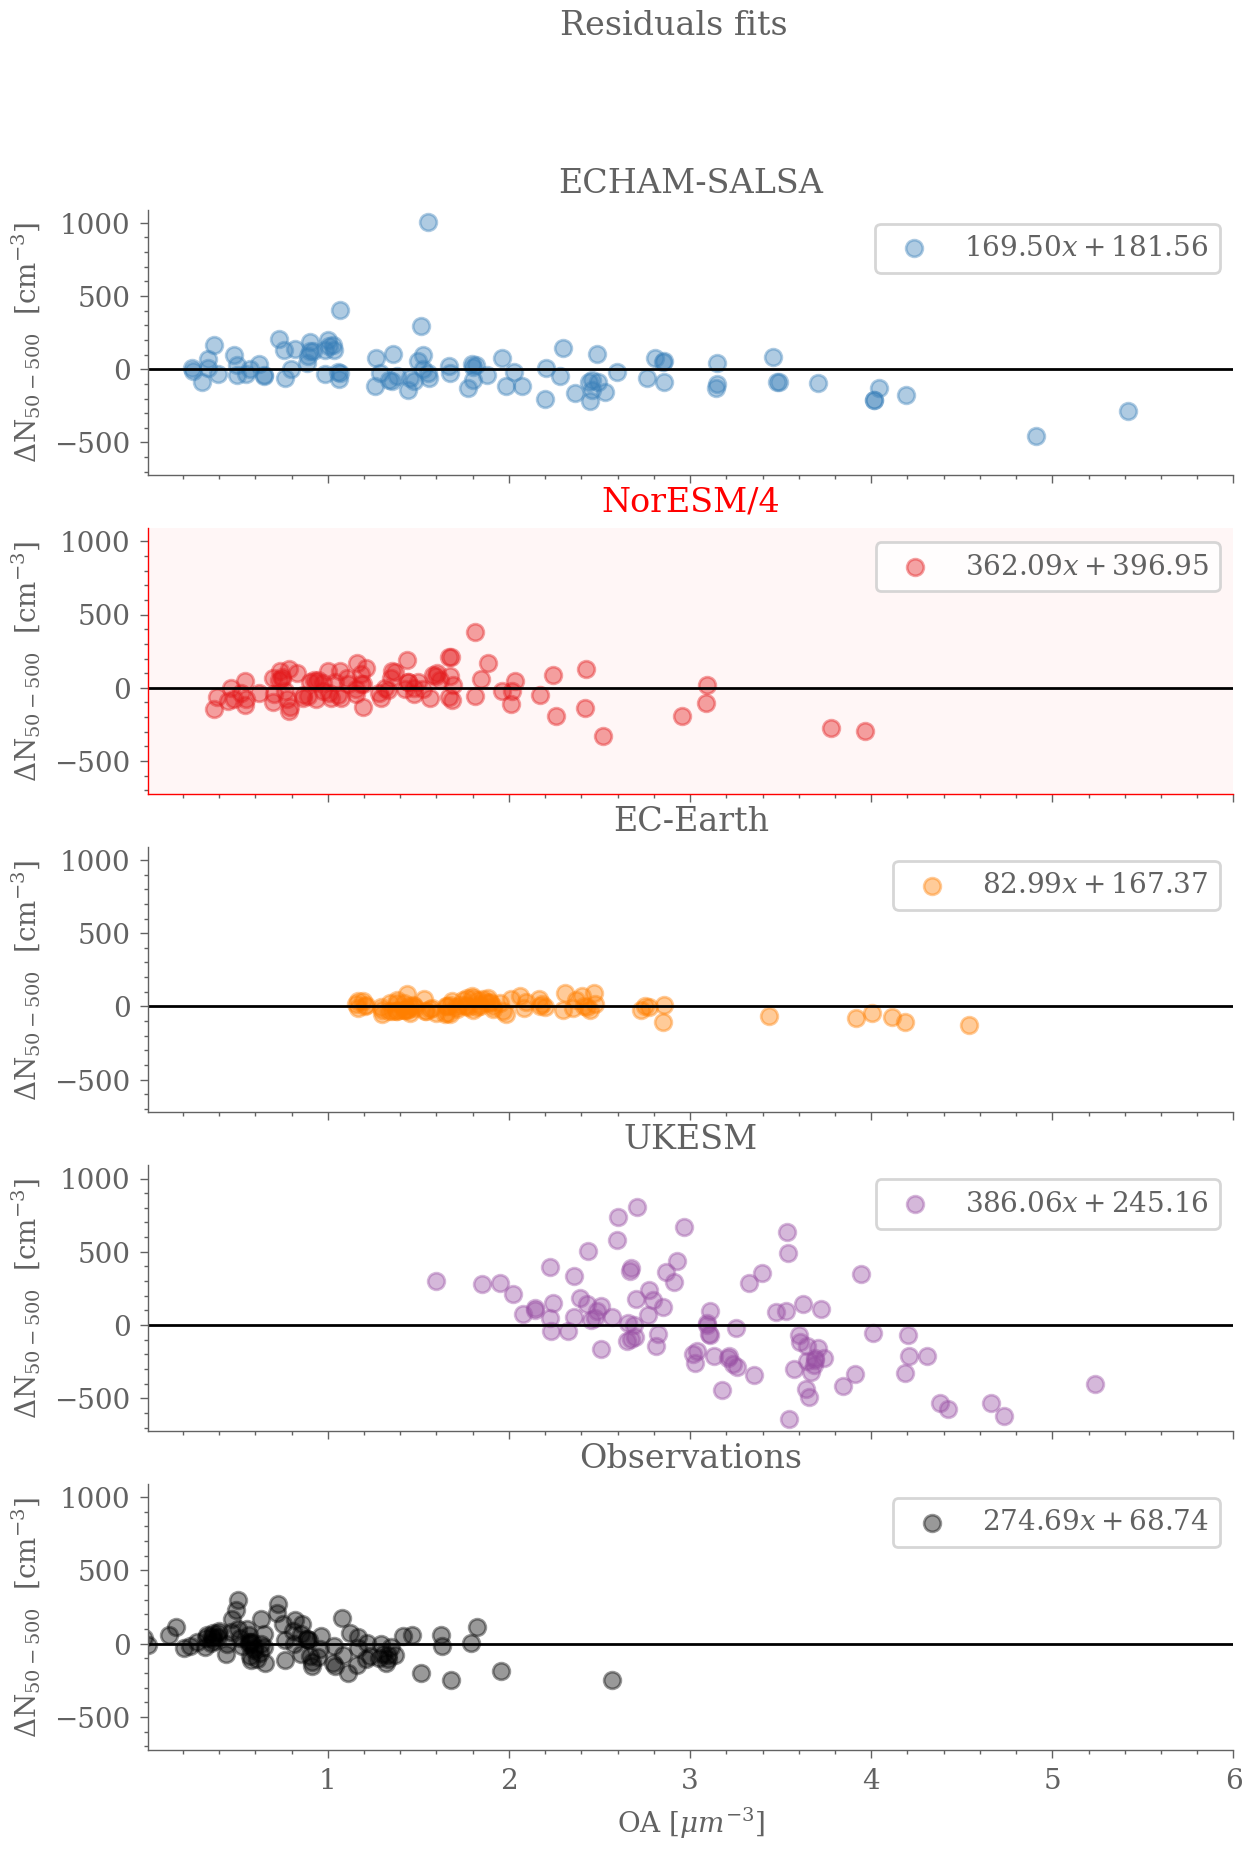

ECHAM-SALSA
[60.16785284 59.29038297]
Beta: [111.25056233 -30.8338204 ]
Beta Std Error: [12.59548201 25.36888586]
Beta Covariance: [[ 338.21476349 -596.70536307]
 [-596.70536307 1372.03681987]]
Residual Variance: 0.4690693139805619
Inverse Condition #: 0.18949573315109758
Reason(s) for Halting:
  Sum of squares convergence
[111.25056233 -30.8338204 ]
reason for haltng
NorESM
NorESM/4
[289.24845226  75.41036413]
Beta: [294.47985411  68.3529944 ]
Beta Std Error: [5.78182776 8.76920626]
Beta Covariance: [[ 1842.0129745  -2484.94854589]
 [-2484.94854589  4237.23893742]]
Residual Variance: 0.01814836960704317
Inverse Condition #: 0.2181346841011208
Reason(s) for Halting:
  Sum of squares convergence
[294.47985411  68.3529944 ]
reason for haltng
EC-Earth
[58.60627788 71.08474969]
Beta: [64.90783308 58.89520614]
Beta Std Error: [3.04056267 6.22436698]
Beta Covariance: [[  93.2205192  -180.32305278]
 [-180.32305278  390.65553073]]
Residual Variance: 0.0991736739935437
Inverse Condition #: 0.11

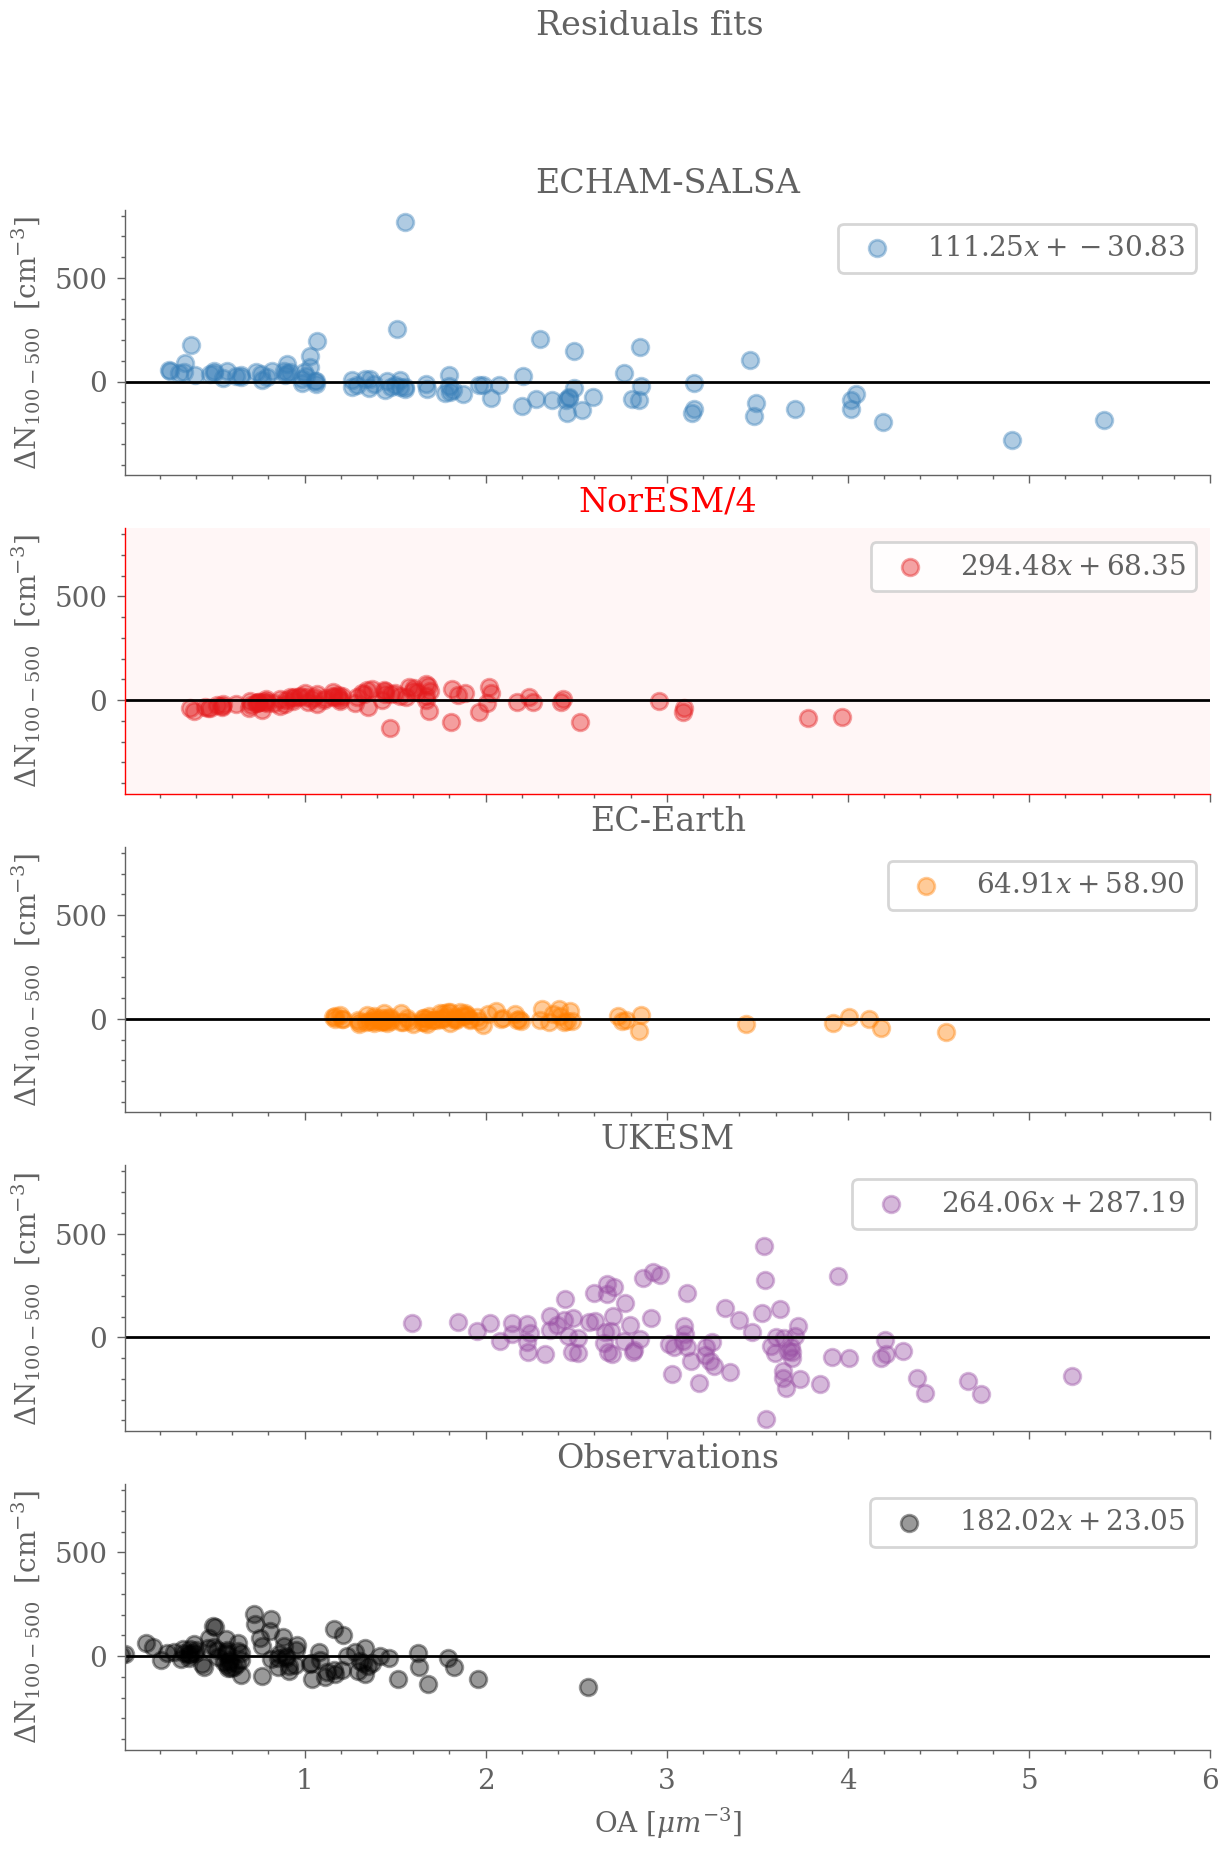

ECHAM-SALSA
[23.43907927 -6.98331194]
Beta: [24.97116042 -9.686332  ]
Beta Std Error: [0.92131105 1.91055925]
Beta Covariance: [[ 13.54302458 -23.89368405]
 [-23.89368405  58.24037025]]
Residual Variance: 0.06267536797123648
Inverse Condition #: 0.20536061737915828
Reason(s) for Halting:
  Sum of squares convergence
[24.97116042 -9.686332  ]
reason for haltng
NorESM
NorESM/4
[ 27.02107452 -12.93619659]
Beta: [ 28.02687744 -14.29306501]
Beta Std Error: [0.78569045 1.19050614]
Beta Covariance: [[ 16.83911978 -22.71664315]
 [-22.71664315  38.66159008]]
Residual Variance: 0.036659249080045364
Inverse Condition #: 0.21733060156127518
Reason(s) for Halting:
  Sum of squares convergence
[ 28.02687744 -14.29306501]
reason for haltng
EC-Earth
[ 43.09838126 -10.63226256]
Beta: [ 44.49260486 -13.32920808]
Beta Std Error: [1.16416512 2.38758038]
Beta Covariance: [[ 42.33902085 -81.89937809]
 [-81.89937809 178.08512526]]
Residual Variance: 0.0320101976459729
Inverse Condition #: 0.1217918416037918


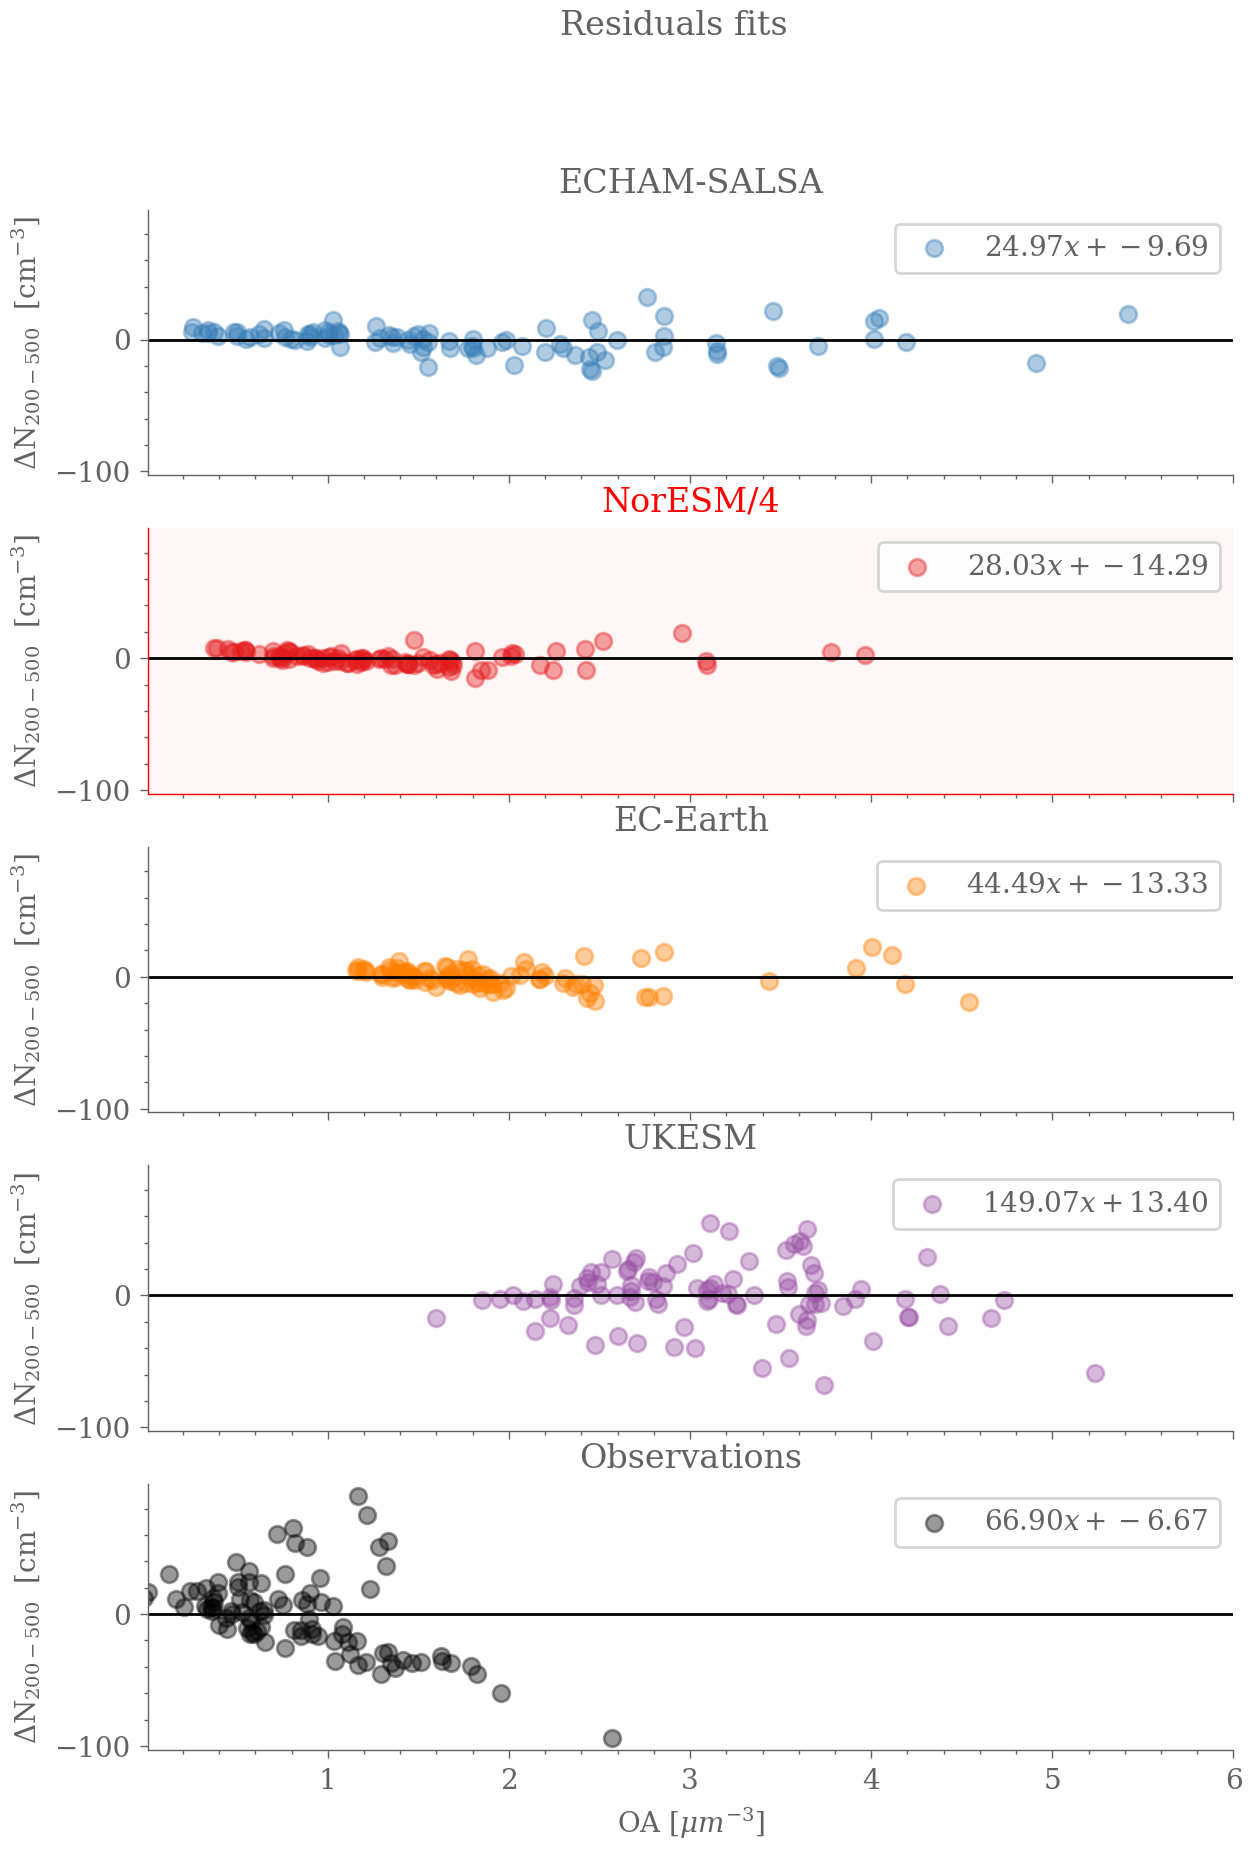

In [34]:
select_station = 'ATTO'

## Settings
alpha_scatt = 0.5


divide_NorESM_by_factor = 4


xlab = r'OA [$\mu m^{-3}$]'
alpha_scatt = 0.4
source_list = models_and_obs[::-1]
v_x = 'OA'

## Settings
dic_lims = {
    'N50': {'xlims':[.01,10], 'ylims':[1,5000]},
    'N100': {'xlims':[.01,10], 'ylims':[1,3000]},
    'N200': {'xlims':[.01,10], 'ylims':[1,200]},
    'N50-500': {'xlims':[.01,6], 'ylims':[1,5000]},
    'N100-500': {'xlims':[.01,6], 'ylims':[1,3000]},
    'N200-500': {'xlims':[.01,6], 'ylims':[1,200]},

}

dic_ylabels = {
    'N50' : r'$\Delta$N$_{50}$  [cm$^{-3}$]',
    'N100' : r'$\Delta$N$_{100}$  [cm$^{-3}$]',
    'N200' : r'$\Delta$N$_{200}$  [cm$^{-3}$]',
    'N50-500' : r'$\Delta$N$_{50-500}$  [cm$^{-3}$]',
    'N100-500' : r'$\Delta$N$_{100-500}$  [cm$^{-3}$]',
    'N200-500' : r'$\Delta$N$_{200-500}$  [cm$^{-3}$]',

}



xscale='linear'
yscale='linear'


# OBS: 
if select_station=='SMR':
    varlistplot = ['N50','N100','N200']
    
    dic_df_med = dic_df_med_SMR
    season = 'JA'
    func_station = func_smr
    divide_NorESM_by_factor = None
    
elif select_station=='ATTO':
    dic_df_med = dic_df_med_ATTO
    season = 'FMA'
    func_station = func_atto
    
    divide_NorESM_by_factor = 4
    varlistplot = ['N50-500','N100-500','N200-500']



for i,v_y in enumerate(varlistplot):
    #dic_fits[select_station][v_y] = dict()
    fig, axs = plt.subplots(len(models_and_obs), sharex=True, sharey= True, figsize=figsize)
    
    for mo, ax in zip(models_and_obs, axs):

        df_s =  dic_df_med[mo]
        print(mo)
        
        mask_months = select_months(df_s, season=season)
        df_s = df_s[mask_months].copy()
        
        if (mo =='NorESM') &  (divide_NorESM_by_factor is not None):
            df_s = df_s/divide_NorESM_by_factor
            ax.set_facecolor('#fff6f6')
            title = f'{mo}/{divide_NorESM_by_factor}'
            print(title)
            ax.spines['bottom'].set_color('r')
            ax.spines['top'].set_color('r') 
            ax.spines['right'].set_color('red')
            ax.spines['left'].set_color('red')
            ax.set_title(title, c='r')
        else:
            title=mo
            
            ax.set_title(title, )
    
        popt, pov, label, func = func_station(df_s,v_x,v_y)
        #legends_atto.append(label)


        _ma = df_s[v_x].max() 
        _mi = df_s[v_x].min() 
        ax.scatter(df_s[v_x],df_s[v_y]-func(df_s[v_x],*popt),
                                    color=cdic_model[mo], 
                #alpha=alpha_scatt, 
                #facecolor='none',
               alpha=alpha_scatt,
               
                edgecolor=cdic_model[mo],

                label=label
                   )
        #plt.show()
        xlims = dic_lims[v_y]['xlims']
        ax.set_yscale(yscale)
        ax.set_xscale(xscale)


        ax.hlines(0, xmin=xlims[0],xmax=xlims[1], color='k', linewidth=1)
        ax.legend(frameon=False)
        ylab = dic_ylabels[v_y]
        ax.set_ylabel(ylab)
        ax.set_xlim(xlims)
        ax.legend(frameon=True)

        
    #fig.suptitle('Observations')
    axs[-1].set_xlabel(xlab)
    fig.suptitle(r'Residuals fits')

    sns.despine(fig)    
    
    fn = make_fn_scat(f'residual_ln_{season}_{select_station}', v_x, v_y)
    fig.savefig(fn, dpi=150)
    fig.savefig(fn.with_suffix('.pdf'), dpi=150)
    print(fn)
    plt.show()

### Other seasons

#### JFMAM

Observations
UKESM
EC-Earth
NorESM
ECHAM-SALSA
Observations
0.3260419965404727
UKESM
0.6953921000457486
EC-Earth
0.6890256492078259
NorESM
0.8630133769912338
ECHAM-SALSA
0.43915906482691647
Observations


/proj/bolinc/users/x_sarbl/analysis/BS-FDBCK/bs_fdbck/util/BSOA_datamanip/fits.py:528: RuntimeWarning: invalid value encountered in log
  return a + b * np.log(c + x)
/proj/bolinc/users/x_sarbl/analysis/BS-FDBCK/bs_fdbck/util/BSOA_datamanip/fits.py:528: RuntimeWarning: invalid value encountered in log
  return a + b * np.log(c + x)
/proj/bolinc/users/x_sarbl/analysis/BS-FDBCK/bs_fdbck/util/BSOA_datamanip/fits.py:528: RuntimeWarning: invalid value encountered in log
  return a + b * np.log(c + x)
/proj/bolinc/users/x_sarbl/analysis/BS-FDBCK/bs_fdbck/util/BSOA_datamanip/fits.py:528: RuntimeWarning: invalid value encountered in log
  return a + b * np.log(c + x)
/proj/bolinc/users/x_sarbl/analysis/BS-FDBCK/bs_fdbck/util/BSOA_datamanip/fits.py:528: RuntimeWarning: invalid value encountered in log
  return a + b * np.log(c + x)
/proj/bolinc/users/x_sarbl/analysis/BS-FDBCK/bs_fdbck/util/BSOA_datamanip/fits.py:528: RuntimeWarning: invalid value encountered in log
  return a + b * np.log(c + x

UKESM
EC-Earth
NorESM
ECHAM-SALSA
Observations
0.7654555486371468
UKESM
0.7594093618355633
EC-Earth
0.8520036195409988
NorESM


/proj/bolinc/users/x_sarbl/analysis/BS-FDBCK/bs_fdbck/util/BSOA_datamanip/fits.py:528: RuntimeWarning: invalid value encountered in log
  return a + b * np.log(c + x)
/proj/bolinc/users/x_sarbl/analysis/BS-FDBCK/bs_fdbck/util/BSOA_datamanip/fits.py:528: RuntimeWarning: invalid value encountered in log
  return a + b * np.log(c + x)
/proj/bolinc/users/x_sarbl/analysis/BS-FDBCK/bs_fdbck/util/BSOA_datamanip/fits.py:528: RuntimeWarning: invalid value encountered in log
  return a + b * np.log(c + x)


[302.68639399 -43.92947774]
Beta: [312.33767766 -62.4395137 ]
Beta Std Error: [ 5.03031372 12.1031752 ]
Beta Covariance: [[  812.17825969 -1557.66341263]
 [-1557.66341263  4701.75351939]]
Residual Variance: 0.03115579096414946
Inverse Condition #: 0.2163604767814529
Reason(s) for Halting:
  Sum of squares convergence
[312.33767766 -62.4395137 ]
reason for haltng
0.9381991850575244
ECHAM-SALSA
0.7815120149772352
Observations
UKESM
EC-Earth
NorESM
ECHAM-SALSA
Observations
[50.6632659 -2.9398395]
Beta: [ 53.56800661 -11.52806991]
Beta Std Error: [1.14970721 3.98628453]
Beta Covariance: [[ 24.17625158 -71.4801166 ]
 [-71.4801166  290.63709326]]
Residual Variance: 0.05467459151998026
Inverse Condition #: 0.008692473919387366
Reason(s) for Halting:
  Sum of squares convergence
[ 53.56800661 -11.52806991]
reason for haltng
0.8915472533421044
UKESM
[129.31996204  75.29379338]
Beta: [132.42005295  67.0025941 ]
Beta Std Error: [1.85664124 6.14214792]
Beta Covariance: [[ 146.03086198 -390.5598075

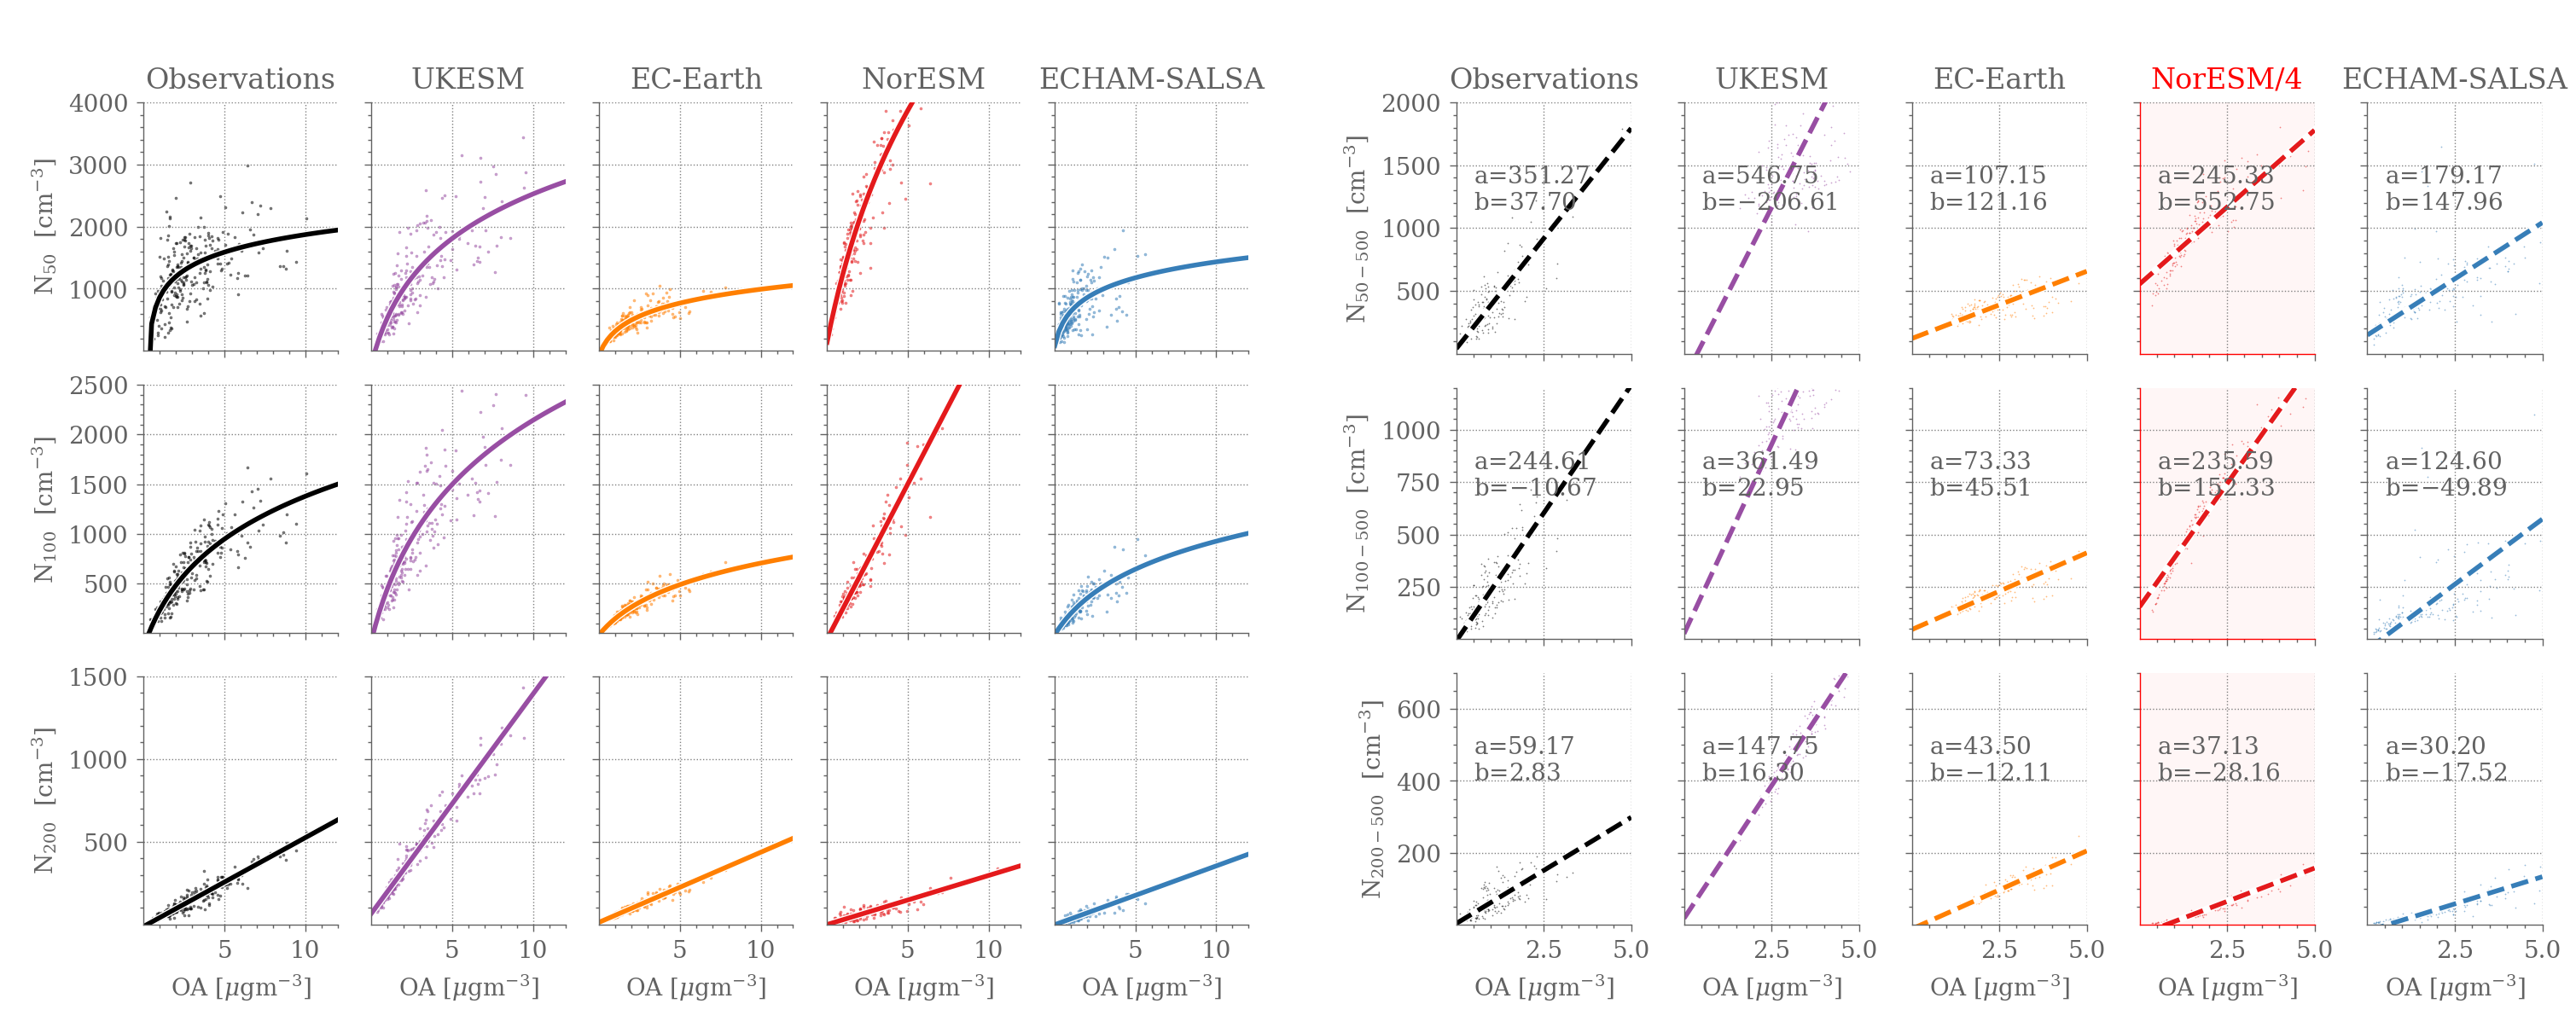

In [35]:
fig_main = plt.figure(constrained_layout=True,
                  figsize=[15,6],
                 )
spec2 = gridspec.GridSpec( nrows=2,ncols=3, 
                          width_ratios=[4,.1,4],
                          height_ratios=[1,20], 
                          figure=fig_main)

markersize = 5

subfig1 =  fig_main.add_subfigure(spec2[1, 0],frameon=True)
subfig2 =  fig_main.add_subfigure(spec2[1, 1])
subfig3 =  fig_main.add_subfigure(spec2[1, 2],frameon=True)
subfig_up =  fig_main.add_subfigure(spec2[0, :])


axs_smr = subfig1.subplots(3,5, sharex='col', sharey='row')
#ax_fits = subfig2.subplots(3,1, sharex='col', sharey='row')
axs_atto =subfig3.subplots(3,5, sharex='col', sharey='row')
#subfig2.set_facecolor('#e9f2f9')##e5f8f8')
# subfig3.set_facecolor('#fff4ea')

dic_fits = {}
dic_fits['SMR'] =dict()
dic_fits['ATTO'] =dict()

#subfig1.suptitle('SMEARII, Jul & Aug')
#subfig3.suptitle('ATTO, JFM')
#subfig2.suptitle('Fits')

ax_dum = subfig_up.subplots(1)
ax_dum.axis('off')


divide_NorESM_by_factor = 4


varlistplot = ['N50','N100','N200']
xlab = r'OA [$\mu$gm$^{-3}$]'
alpha_scatt = 0.4
source_list = models_and_obs[::-1]
v_x = 'OA'

## Settings
dic_lims = {
    'N50': {'xlims':[.01,12], 'ylims':[1,4000]},
    'N100': {'xlims':[.01,12], 'ylims':[1,2500]},
    'N200': {'xlims':[.01,12], 'ylims':[1,1500]},
    'N50-500': {'xlims':[.01,5], 'ylims':[1,2000]},
    'N100-500': {'xlims':[.01,5], 'ylims':[1,1200]},
    'N200-500': {'xlims':[.01,5], 'ylims':[1,700]},

}

dic_ylabels = {
    'N50' : r'N$_{50}$  [cm$^{-3}$]',
    'N100' : r'N$_{100}$  [cm$^{-3}$]',
    'N200' : r'N$_{200}$  [cm$^{-3}$]',
    'N50-500' : r'N$_{50-500}$  [cm$^{-3}$]',
    'N100-500' : r'N$_{100-500}$  [cm$^{-3}$]',
    'N200-500' : r'N$_{200-500}$  [cm$^{-3}$]',

}




select_station = 'SMR'
season = 'JA'


xscale='linear'
yscale='linear'


# OBS: 

dic_df_med = dic_df_med_SMR
axs_all = axs_smr
fig = subfig1


#fig, axs_all = plt.subplots(3,6,figsize=figsize, sharey='row', sharex='col')
## Settings
legends_smr = []
legends_atto = []
legs =[]

for i,v_y in enumerate(varlistplot):
    dic_fits[select_station][v_y] = dict()
    # Make plot
    ylab = dic_ylabels[v_y]
    ylims = dic_lims[v_y]['ylims']
    xlims = dic_lims[v_y]['xlims']
    
    axs_sub = axs_all[i,:]
    axs_sub[0].set_ylabel(ylab)
    make_plot2(v_x, v_y, xlims, ylims, season, 
              xlab=xlab, ylab=ylab, alpha_scat=alpha_scatt,
             source_list = source_list, fig=fig, 
               axs=axs_sub,
              xscale='linear', yscale='linear',
              dic_df_med = dic_df_med,
           select_station= select_station,
               markersize=markersize,
         )

    
    for mo, ax in zip(source_list, axs_sub):
        dic_fits[select_station][v_y][mo] = dict()

        df_s =  dic_df_med[mo]
        
        print(mo)
        mask_months = select_months(df_s, season=season)
        df_s = df_s[mask_months].copy()
        popt, pov, label, func = func_smr(df_s,v_x,v_y)
            
            
        legends_smr.append(label)

        plot_fit(func, popt, mo, xlims, yscale, xscale, ax, label,)
        #plot_fit(func, popt, mo, xlims, yscale, xscale,  ax_fits[i],label,extra_plot=True)

        dic_fits[select_station][v_y][mo]['label'] = label
        dic_fits[select_station][v_y][mo]['popt'] = popt
        dic_fits[select_station][v_y][mo]['pcov'] = pov
        dic_fits[select_station][v_y][mo]['standard_error'] = np.sqrt(np.diag(dic_fits[select_station][v_y][mo]['pcov']))
        
        dic_fits[select_station][v_y][mo]['func'] = func
        dic_fits[select_station][v_y][mo]['R2'] = get_r2(df_s,v_x,v_y, popt, func)
        dic_fits[select_station][v_y][mo]['corr'] = get_corr(df_s,v_x,v_y)
        print( get_r2(df_s,v_x,v_y, popt, func))
        dic_fits[select_station][v_y][mo] = calc_table_se(dic_fits[select_station][v_y][mo])   
        
        
        ax.set_yscale(yscale)
        ax.set_xscale(xscale)
    #leg = axs_sub[-1].legend(bbox_to_anchor=(1,1,), frameon=False)

    #legs.append(leg)


    
for ax in axs_sub:
    ax.set_xlabel(xlab)
sns.despine(fig) 








varlistplot = ['N50-500','N100-500','N200-500']

select_station = 'ATTO'
season = 'JFMAM'

xscale='linear'
yscale='linear'


# OBS: 

dic_df_med = dic_df_med_ATTO
axs_all = axs_atto
fig = subfig3
select_station = 'ATTO'


#fig, axs_all = plt.subplots(3,6,figsize=figsize, sharey='row', sharex='col')
## Settings

legs =[]

for i,v_y in enumerate(varlistplot):
    dic_fits[select_station][v_y] = dict()
    
    # Make plot
    ylab = dic_ylabels[v_y]
    ylims = dic_lims[v_y]['ylims']
    xlims = dic_lims[v_y]['xlims']
    axs_sub = axs_all[i,:]
    axs_sub[0].set_ylabel(ylab)

    make_plot2(v_x, v_y, xlims, ylims, season, 
              xlab=xlab, ylab=ylab, alpha_scat=alpha_scatt,
             source_list = source_list, fig=fig, 
               axs=axs_sub,
              xscale='linear', yscale='linear',
              dic_df_med = dic_df_med,
           select_station= select_station,
               divide_NorESM_by_factor=divide_NorESM_by_factor,
         )


    for mo, ax in zip(source_list, axs_sub):
        dic_fits[select_station][v_y][mo] = dict()
        
        df_s =  dic_df_med[mo]
        print(mo)
        mask_months = select_months(df_s, season=season)
        df_s = df_s[mask_months].copy()
        if (mo =='NorESM') &  (divide_NorESM_by_factor is not None):
            df_s = df_s/divide_NorESM_by_factor
            ax.set_facecolor('#fff6f6')
    
        popt, pov, label, func = func_atto(df_s,v_x,v_y)
        legends_atto.append(label)
        
        plot_fit(func, popt, mo, xlims, yscale, xscale, ax,label, linestyle='dashed')
        #plot_fit(func, popt, mo, xlims, yscale, xscale,  ax_fits[i],label,  extra_plot=True,linestyle='dashed',)
        ax.set_xlim(xlims)
        #dic_fits['ATTO'][v_y][mo]['label'] = label
        #dic_fits['ATTO'][v_y][mo]['popt'] = popt
        #dic_fits['ATTO'][v_y][mo]['pov'] = pov 
        
        dic_fits[select_station][v_y][mo]['label'] = label
        dic_fits[select_station][v_y][mo]['popt'] = popt
        dic_fits[select_station][v_y][mo]['pcov'] = pov
        dic_fits[select_station][v_y][mo]['standard_error'] = np.sqrt(np.diag(dic_fits[select_station][v_y][mo]['pcov']))
        
        #dic_fits[select_station][v_y][mo]['func'] = func
        dic_fits[select_station][v_y][mo]['R2'] = get_r2(df_s,v_x,v_y, popt, func)
        dic_fits[select_station][v_y][mo]['corr'] = get_corr(df_s,v_x,v_y)
        dic_fits[select_station][v_y][mo] = calc_table_se(dic_fits[select_station][v_y][mo])        

        _a = label.split('x')[0][1:]
        _b = label.split('x')[1][:-1]
        if _b[0]=='+':
            _b=_b[1:]
        ax.text(left, top, f'a=${_a}$ \nb=${_b}$',
        horizontalalignment='left',
        verticalalignment='top',
        transform=ax.transAxes)

        ax.set_yscale(yscale)
        ax.set_xscale(xscale)
        #ax.legend(frameon=False, fontsize=10)
    
    #leg = axs_sub[-1].legend(bbox_to_anchor=(1,1,), frameon=False)

    #legs.append(leg)


    
for ax in axs_sub:
    ax.set_xlabel(xlab)
sns.despine(fig) 




#for i, v_y in enumerate(varlistplot):
#    xlims = dic_lims[v_y]['xlims']
#    ax = ax_fits[i]
    
    #ax.set_xlim(xlims)
#    ax.set_ylim(dic_lims[v_y]['ylims'])
#    ax.set_yticklabels([])
#    ax.set_facecolor('#e9f2f9')##e5f8f8')
#    sns.despine(ax)
#ax.set_xlabel(xlab)
sns.despine(subfig2) 

subfig1.suptitle('SMEARII: Jul,Aug', size=16, y=1.05)
subfig2.suptitle('Fits', size=16, y=1.05, c='w')
subfig3.suptitle(f'ATTO: {dic_season_nicename[season]}', size=16, y=1.05)

#axs_all = list(ax_fits.flatten())+list(axs_smr.flatten())+ list(axs_atto.flatten())
axs_all = list(list(axs_smr.flatten())+ list(axs_atto.flatten()))
for ax in axs_all:
    ax.grid(color = 'grey', linestyle = ':', linewidth = 0.5)



#for ax in axs_atto[:,0]:
#    ax.set_yticklabels([])
#    ax.set_ylabel('')

for ax in axs_atto[1:,:].flatten():
    ax.set_title('')


for ax in axs_smr[1:,:].flatten():
    ax.set_title('')

#ax_fits[0].set_title('.', color='w')
fn = make_fn_scat(f'together_{season}', v_x, 'Nx')
print(fn)
plt.savefig(fn.with_suffix('.pdf'),bbox_inches='tight', dpi=200)
plt.savefig(fn.with_suffix('.png'),bbox_inches='tight', dpi=200)

df = make_pd_of_dic(dic_fits)
df.to_csv(fn.with_suffix('.csv'))

plt.show()

#### JFM

Observations
UKESM
EC-Earth
NorESM
ECHAM-SALSA
Observations
0.3260419965404727
UKESM
0.6953921000457486
EC-Earth
0.6890256492078259
NorESM
0.8630133769912338
ECHAM-SALSA
0.43915906482691647
Observations
UKESM


/proj/bolinc/users/x_sarbl/analysis/BS-FDBCK/bs_fdbck/util/BSOA_datamanip/fits.py:528: RuntimeWarning: invalid value encountered in log
  return a + b * np.log(c + x)
/proj/bolinc/users/x_sarbl/analysis/BS-FDBCK/bs_fdbck/util/BSOA_datamanip/fits.py:528: RuntimeWarning: invalid value encountered in log
  return a + b * np.log(c + x)
/proj/bolinc/users/x_sarbl/analysis/BS-FDBCK/bs_fdbck/util/BSOA_datamanip/fits.py:528: RuntimeWarning: invalid value encountered in log
  return a + b * np.log(c + x)
/proj/bolinc/users/x_sarbl/analysis/BS-FDBCK/bs_fdbck/util/BSOA_datamanip/fits.py:528: RuntimeWarning: invalid value encountered in log
  return a + b * np.log(c + x)
/proj/bolinc/users/x_sarbl/analysis/BS-FDBCK/bs_fdbck/util/BSOA_datamanip/fits.py:528: RuntimeWarning: invalid value encountered in log
  return a + b * np.log(c + x)
/proj/bolinc/users/x_sarbl/analysis/BS-FDBCK/bs_fdbck/util/BSOA_datamanip/fits.py:528: RuntimeWarning: invalid value encountered in log
  return a + b * np.log(c + x

EC-Earth
NorESM
ECHAM-SALSA
Observations
0.7654555486371468
UKESM
0.7594093618355633
EC-Earth
0.8520036195409988
NorESM


/proj/bolinc/users/x_sarbl/analysis/BS-FDBCK/bs_fdbck/util/BSOA_datamanip/fits.py:528: RuntimeWarning: invalid value encountered in log
  return a + b * np.log(c + x)
/proj/bolinc/users/x_sarbl/analysis/BS-FDBCK/bs_fdbck/util/BSOA_datamanip/fits.py:528: RuntimeWarning: invalid value encountered in log
  return a + b * np.log(c + x)
/proj/bolinc/users/x_sarbl/analysis/BS-FDBCK/bs_fdbck/util/BSOA_datamanip/fits.py:528: RuntimeWarning: invalid value encountered in log
  return a + b * np.log(c + x)


[302.68639399 -43.92947774]
Beta: [312.33767766 -62.4395137 ]
Beta Std Error: [ 5.03031372 12.1031752 ]
Beta Covariance: [[  812.17825969 -1557.66341263]
 [-1557.66341263  4701.75351939]]
Residual Variance: 0.03115579096414946
Inverse Condition #: 0.2163604767814529
Reason(s) for Halting:
  Sum of squares convergence
[312.33767766 -62.4395137 ]
reason for haltng
0.9381991850575244
ECHAM-SALSA
0.7815120149772352
Observations
UKESM
EC-Earth
NorESM
ECHAM-SALSA
Observations
[50.6632659 -2.9398395]
Beta: [ 53.56800661 -11.52806991]
Beta Std Error: [1.14970721 3.98628453]
Beta Covariance: [[ 24.17625158 -71.4801166 ]
 [-71.4801166  290.63709326]]
Residual Variance: 0.05467459151998026
Inverse Condition #: 0.008692473919387366
Reason(s) for Halting:
  Sum of squares convergence
[ 53.56800661 -11.52806991]
reason for haltng
0.8915472533421044
UKESM
[129.31996204  75.29379338]
Beta: [132.42005295  67.0025941 ]
Beta Std Error: [1.85664124 6.14214792]
Beta Covariance: [[ 146.03086198 -390.5598075

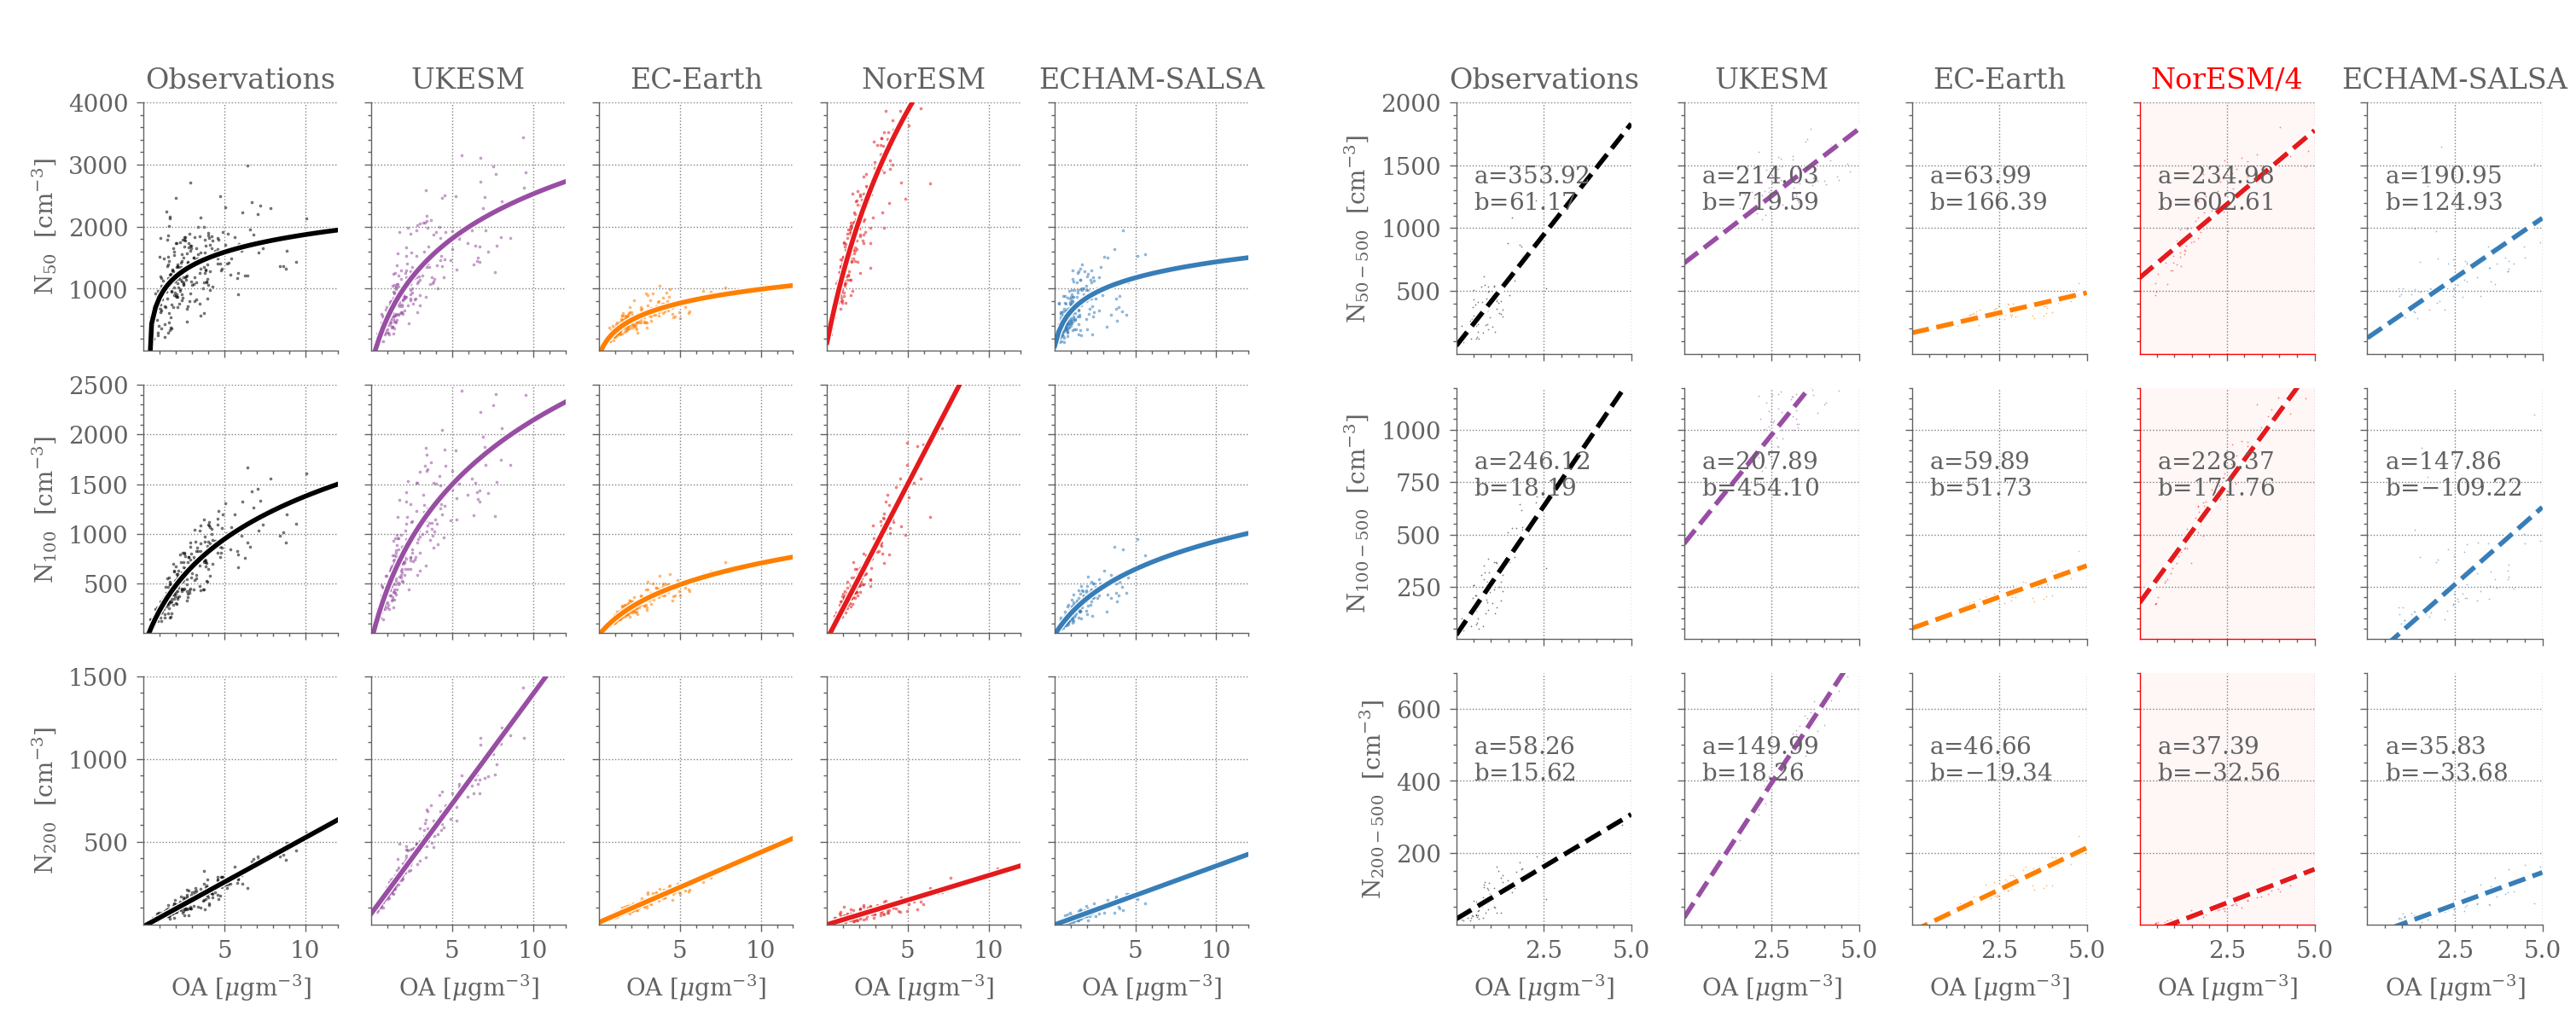

In [36]:
fig_main = plt.figure(constrained_layout=True,
                  figsize=[15,6],
                 )
spec2 = gridspec.GridSpec( nrows=2,ncols=3, 
                          width_ratios=[4,.1,4],
                          height_ratios=[1,20], 
                          figure=fig_main)

markersize = 5

subfig1 =  fig_main.add_subfigure(spec2[1, 0],frameon=True)
subfig2 =  fig_main.add_subfigure(spec2[1, 1])
subfig3 =  fig_main.add_subfigure(spec2[1, 2],frameon=True)
subfig_up =  fig_main.add_subfigure(spec2[0, :])


axs_smr = subfig1.subplots(3,5, sharex='col', sharey='row')
#ax_fits = subfig2.subplots(3,1, sharex='col', sharey='row')
axs_atto =subfig3.subplots(3,5, sharex='col', sharey='row')
#subfig2.set_facecolor('#e9f2f9')##e5f8f8')
# subfig3.set_facecolor('#fff4ea')

dic_fits = {}
dic_fits['SMR'] =dict()
dic_fits['ATTO'] =dict()

#subfig1.suptitle('SMEARII, Jul & Aug')
#subfig3.suptitle('ATTO, JFM')
#subfig2.suptitle('Fits')

ax_dum = subfig_up.subplots(1)
ax_dum.axis('off')


divide_NorESM_by_factor = 4


varlistplot = ['N50','N100','N200']
xlab = r'OA [$\mu$gm$^{-3}$]'
alpha_scatt = 0.4
source_list = models_and_obs[::-1]
v_x = 'OA'

## Settings
dic_lims = {
    'N50': {'xlims':[.01,12], 'ylims':[1,4000]},
    'N100': {'xlims':[.01,12], 'ylims':[1,2500]},
    'N200': {'xlims':[.01,12], 'ylims':[1,1500]},
    'N50-500': {'xlims':[.01,5], 'ylims':[1,2000]},
    'N100-500': {'xlims':[.01,5], 'ylims':[1,1200]},
    'N200-500': {'xlims':[.01,5], 'ylims':[1,700]},

}

dic_ylabels = {
    'N50' : r'N$_{50}$  [cm$^{-3}$]',
    'N100' : r'N$_{100}$  [cm$^{-3}$]',
    'N200' : r'N$_{200}$  [cm$^{-3}$]',
    'N50-500' : r'N$_{50-500}$  [cm$^{-3}$]',
    'N100-500' : r'N$_{100-500}$  [cm$^{-3}$]',
    'N200-500' : r'N$_{200-500}$  [cm$^{-3}$]',

}




select_station = 'SMR'
season = 'JA'


xscale='linear'
yscale='linear'


# OBS: 

dic_df_med = dic_df_med_SMR
axs_all = axs_smr
fig = subfig1


#fig, axs_all = plt.subplots(3,6,figsize=figsize, sharey='row', sharex='col')
## Settings
legends_smr = []
legends_atto = []
legs =[]

for i,v_y in enumerate(varlistplot):
    dic_fits[select_station][v_y] = dict()
    # Make plot
    ylab = dic_ylabels[v_y]
    ylims = dic_lims[v_y]['ylims']
    xlims = dic_lims[v_y]['xlims']
    
    axs_sub = axs_all[i,:]
    axs_sub[0].set_ylabel(ylab)
    make_plot2(v_x, v_y, xlims, ylims, season, 
              xlab=xlab, ylab=ylab, alpha_scat=alpha_scatt,
             source_list = source_list, fig=fig, 
               axs=axs_sub,
              xscale='linear', yscale='linear',
              dic_df_med = dic_df_med,
           select_station= select_station,
               markersize=markersize,
         )

    
    for mo, ax in zip(source_list, axs_sub):
        dic_fits[select_station][v_y][mo] = dict()

        df_s =  dic_df_med[mo]
        
        print(mo)
        mask_months = select_months(df_s, season=season)
        df_s = df_s[mask_months].copy()
        popt, pov, label, func = func_smr(df_s,v_x,v_y)
            
            
        legends_smr.append(label)

        plot_fit(func, popt, mo, xlims, yscale, xscale, ax, label,)
        #plot_fit(func, popt, mo, xlims, yscale, xscale,  ax_fits[i],label,extra_plot=True)

        dic_fits[select_station][v_y][mo]['label'] = label
        dic_fits[select_station][v_y][mo]['popt'] = popt
        dic_fits[select_station][v_y][mo]['pcov'] = pov
        dic_fits[select_station][v_y][mo]['standard_error'] = np.sqrt(np.diag(dic_fits[select_station][v_y][mo]['pcov']))
        
        dic_fits[select_station][v_y][mo]['func'] = func
        dic_fits[select_station][v_y][mo]['R2'] = get_r2(df_s,v_x,v_y, popt, func)
        dic_fits[select_station][v_y][mo]['corr'] = get_corr(df_s,v_x,v_y)
        print( get_r2(df_s,v_x,v_y, popt, func))
        dic_fits[select_station][v_y][mo] = calc_table_se(dic_fits[select_station][v_y][mo])   
        
        
        ax.set_yscale(yscale)
        ax.set_xscale(xscale)
    #leg = axs_sub[-1].legend(bbox_to_anchor=(1,1,), frameon=False)

    #legs.append(leg)


    
for ax in axs_sub:
    ax.set_xlabel(xlab)
sns.despine(fig) 








varlistplot = ['N50-500','N100-500','N200-500']

select_station = 'ATTO'
season = 'JFM'

xscale='linear'
yscale='linear'


# OBS: 

dic_df_med = dic_df_med_ATTO
axs_all = axs_atto
fig = subfig3
select_station = 'ATTO'


#fig, axs_all = plt.subplots(3,6,figsize=figsize, sharey='row', sharex='col')
## Settings

legs =[]

for i,v_y in enumerate(varlistplot):
    dic_fits[select_station][v_y] = dict()
    
    # Make plot
    ylab = dic_ylabels[v_y]
    ylims = dic_lims[v_y]['ylims']
    xlims = dic_lims[v_y]['xlims']
    axs_sub = axs_all[i,:]
    axs_sub[0].set_ylabel(ylab)

    make_plot2(v_x, v_y, xlims, ylims, season, 
              xlab=xlab, ylab=ylab, alpha_scat=alpha_scatt,
             source_list = source_list, fig=fig, 
               axs=axs_sub,
              xscale='linear', yscale='linear',
              dic_df_med = dic_df_med,
           select_station= select_station,
               divide_NorESM_by_factor=divide_NorESM_by_factor,
         )


    for mo, ax in zip(source_list, axs_sub):
        dic_fits[select_station][v_y][mo] = dict()
        
        df_s =  dic_df_med[mo]
        print(mo)
        mask_months = select_months(df_s, season=season)
        df_s = df_s[mask_months].copy()
        if (mo =='NorESM') &  (divide_NorESM_by_factor is not None):
            df_s = df_s/divide_NorESM_by_factor
            ax.set_facecolor('#fff6f6')
    
        popt, pov, label, func = func_atto(df_s,v_x,v_y)
        legends_atto.append(label)
        
        plot_fit(func, popt, mo, xlims, yscale, xscale, ax,label, linestyle='dashed')
        #plot_fit(func, popt, mo, xlims, yscale, xscale,  ax_fits[i],label,  extra_plot=True,linestyle='dashed',)
        ax.set_xlim(xlims)
        #dic_fits['ATTO'][v_y][mo]['label'] = label
        #dic_fits['ATTO'][v_y][mo]['popt'] = popt
        #dic_fits['ATTO'][v_y][mo]['pov'] = pov 
        
        dic_fits[select_station][v_y][mo]['label'] = label
        dic_fits[select_station][v_y][mo]['popt'] = popt
        dic_fits[select_station][v_y][mo]['pcov'] = pov
        dic_fits[select_station][v_y][mo]['standard_error'] = np.sqrt(np.diag(dic_fits[select_station][v_y][mo]['pcov']))
        
        #dic_fits[select_station][v_y][mo]['func'] = func
        dic_fits[select_station][v_y][mo]['R2'] = get_r2(df_s,v_x,v_y, popt, func)
        dic_fits[select_station][v_y][mo]['corr'] = get_corr(df_s,v_x,v_y)
        dic_fits[select_station][v_y][mo] = calc_table_se(dic_fits[select_station][v_y][mo])        

        _a = label.split('x')[0][1:]
        _b = label.split('x')[1][:-1]
        if _b[0]=='+':
            _b=_b[1:]
        ax.text(left, top, f'a=${_a}$ \nb=${_b}$',
        horizontalalignment='left',
        verticalalignment='top',
        transform=ax.transAxes)

        ax.set_yscale(yscale)
        ax.set_xscale(xscale)
        #ax.legend(frameon=False, fontsize=10)
    
    #leg = axs_sub[-1].legend(bbox_to_anchor=(1,1,), frameon=False)

    #legs.append(leg)


    
for ax in axs_sub:
    ax.set_xlabel(xlab)
sns.despine(fig) 




#for i, v_y in enumerate(varlistplot):
#    xlims = dic_lims[v_y]['xlims']
#    ax = ax_fits[i]
    
    #ax.set_xlim(xlims)
#    ax.set_ylim(dic_lims[v_y]['ylims'])
#    ax.set_yticklabels([])
#    ax.set_facecolor('#e9f2f9')##e5f8f8')
#    sns.despine(ax)
#ax.set_xlabel(xlab)
sns.despine(subfig2) 

subfig1.suptitle('SMEARII: Jul,Aug', size=16, y=1.05)
subfig2.suptitle('Fits', size=16, y=1.05, c='w')
subfig3.suptitle(f'ATTO: {dic_season_nicename[season]}', size=16, y=1.05)

#axs_all = list(ax_fits.flatten())+list(axs_smr.flatten())+ list(axs_atto.flatten())
axs_all = list(list(axs_smr.flatten())+ list(axs_atto.flatten()))
for ax in axs_all:
    ax.grid(color = 'grey', linestyle = ':', linewidth = 0.5)



#for ax in axs_atto[:,0]:
#    ax.set_yticklabels([])
#    ax.set_ylabel('')

for ax in axs_atto[1:,:].flatten():
    ax.set_title('')


for ax in axs_smr[1:,:].flatten():
    ax.set_title('')

#ax_fits[0].set_title('.', color='w')
fn = make_fn_scat(f'together_{season}', v_x, 'Nx')
print(fn)
plt.savefig(fn.with_suffix('.pdf'),bbox_inches='tight', dpi=200)
plt.savefig(fn.with_suffix('.png'),bbox_inches='tight', dpi=200)

df = make_pd_of_dic(dic_fits)
df.to_csv(fn.with_suffix('.csv'))

plt.show()

#### MAM

Observations
UKESM
EC-Earth
NorESM
ECHAM-SALSA
Observations
0.3260419965404727
UKESM
0.6953921000457486
EC-Earth
0.6890256492078259
NorESM
0.8630133769912338
ECHAM-SALSA
0.43915906482691647
Observations
UKESM


/proj/bolinc/users/x_sarbl/analysis/BS-FDBCK/bs_fdbck/util/BSOA_datamanip/fits.py:528: RuntimeWarning: invalid value encountered in log
  return a + b * np.log(c + x)
/proj/bolinc/users/x_sarbl/analysis/BS-FDBCK/bs_fdbck/util/BSOA_datamanip/fits.py:528: RuntimeWarning: invalid value encountered in log
  return a + b * np.log(c + x)
/proj/bolinc/users/x_sarbl/analysis/BS-FDBCK/bs_fdbck/util/BSOA_datamanip/fits.py:528: RuntimeWarning: invalid value encountered in log
  return a + b * np.log(c + x)
/proj/bolinc/users/x_sarbl/analysis/BS-FDBCK/bs_fdbck/util/BSOA_datamanip/fits.py:528: RuntimeWarning: invalid value encountered in log
  return a + b * np.log(c + x)
/proj/bolinc/users/x_sarbl/analysis/BS-FDBCK/bs_fdbck/util/BSOA_datamanip/fits.py:528: RuntimeWarning: invalid value encountered in log
  return a + b * np.log(c + x)
/proj/bolinc/users/x_sarbl/analysis/BS-FDBCK/bs_fdbck/util/BSOA_datamanip/fits.py:528: RuntimeWarning: invalid value encountered in log
  return a + b * np.log(c + x

EC-Earth
NorESM
ECHAM-SALSA
Observations
0.7654555486371468
UKESM
0.7594093618355633
EC-Earth
0.8520036195409988
NorESM


/proj/bolinc/users/x_sarbl/analysis/BS-FDBCK/bs_fdbck/util/BSOA_datamanip/fits.py:528: RuntimeWarning: invalid value encountered in log
  return a + b * np.log(c + x)
/proj/bolinc/users/x_sarbl/analysis/BS-FDBCK/bs_fdbck/util/BSOA_datamanip/fits.py:528: RuntimeWarning: invalid value encountered in log
  return a + b * np.log(c + x)


[302.68639399 -43.92947774]
Beta: [312.33767766 -62.4395137 ]
Beta Std Error: [ 5.03031372 12.1031752 ]
Beta Covariance: [[  812.17825969 -1557.66341263]
 [-1557.66341263  4701.75351939]]
Residual Variance: 0.03115579096414946
Inverse Condition #: 0.2163604767814529
Reason(s) for Halting:
  Sum of squares convergence
[312.33767766 -62.4395137 ]
reason for haltng
0.9381991850575244
ECHAM-SALSA
0.7815120149772352
Observations
UKESM
EC-Earth
NorESM
ECHAM-SALSA
Observations
[50.6632659 -2.9398395]
Beta: [ 53.56800661 -11.52806991]
Beta Std Error: [1.14970721 3.98628453]
Beta Covariance: [[ 24.17625158 -71.4801166 ]
 [-71.4801166  290.63709326]]
Residual Variance: 0.05467459151998026
Inverse Condition #: 0.008692473919387366
Reason(s) for Halting:
  Sum of squares convergence
[ 53.56800661 -11.52806991]
reason for haltng
0.8915472533421044
UKESM
[129.31996204  75.29379338]
Beta: [132.42005295  67.0025941 ]
Beta Std Error: [1.85664124 6.14214792]
Beta Covariance: [[ 146.03086198 -390.5598075

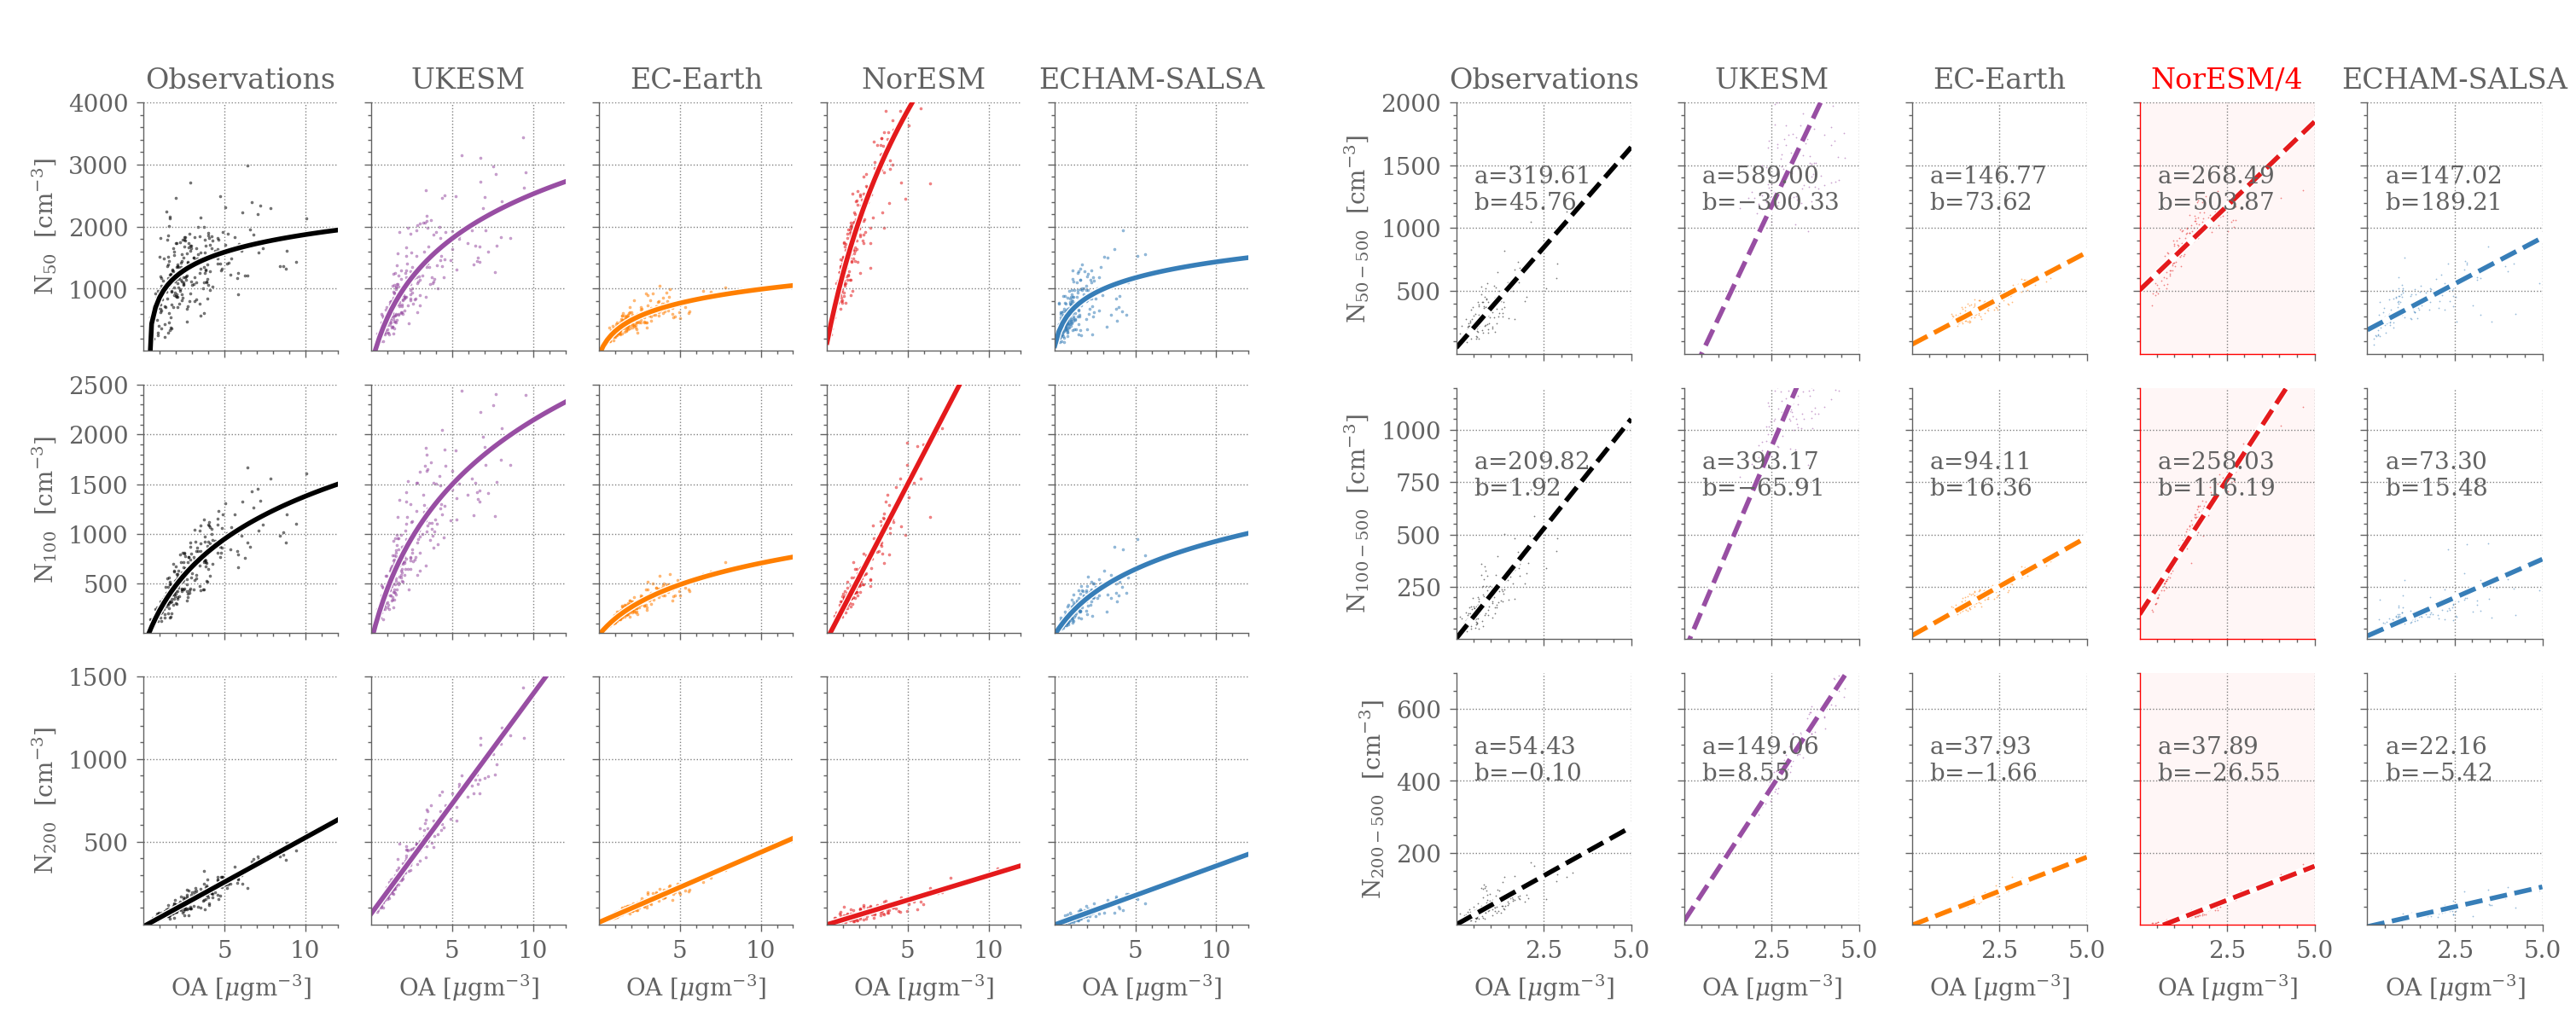

In [37]:
fig_main = plt.figure(constrained_layout=True,
                  figsize=[15,6],
                 )
spec2 = gridspec.GridSpec( nrows=2,ncols=3, 
                          width_ratios=[4,.1,4],
                          height_ratios=[1,20], 
                          figure=fig_main)

markersize = 5

subfig1 =  fig_main.add_subfigure(spec2[1, 0],frameon=True)
subfig2 =  fig_main.add_subfigure(spec2[1, 1])
subfig3 =  fig_main.add_subfigure(spec2[1, 2],frameon=True)
subfig_up =  fig_main.add_subfigure(spec2[0, :])


axs_smr = subfig1.subplots(3,5, sharex='col', sharey='row')
#ax_fits = subfig2.subplots(3,1, sharex='col', sharey='row')
axs_atto =subfig3.subplots(3,5, sharex='col', sharey='row')
#subfig2.set_facecolor('#e9f2f9')##e5f8f8')
# subfig3.set_facecolor('#fff4ea')

dic_fits = {}
dic_fits['SMR'] =dict()
dic_fits['ATTO'] =dict()

#subfig1.suptitle('SMEARII, Jul & Aug')
#subfig3.suptitle('ATTO, JFM')
#subfig2.suptitle('Fits')

ax_dum = subfig_up.subplots(1)
ax_dum.axis('off')


divide_NorESM_by_factor = 4


varlistplot = ['N50','N100','N200']
xlab = r'OA [$\mu$gm$^{-3}$]'
alpha_scatt = 0.4
source_list = models_and_obs[::-1]
v_x = 'OA'

## Settings
dic_lims = {
    'N50': {'xlims':[.01,12], 'ylims':[1,4000]},
    'N100': {'xlims':[.01,12], 'ylims':[1,2500]},
    'N200': {'xlims':[.01,12], 'ylims':[1,1500]},
    'N50-500': {'xlims':[.01,5], 'ylims':[1,2000]},
    'N100-500': {'xlims':[.01,5], 'ylims':[1,1200]},
    'N200-500': {'xlims':[.01,5], 'ylims':[1,700]},

}

dic_ylabels = {
    'N50' : r'N$_{50}$  [cm$^{-3}$]',
    'N100' : r'N$_{100}$  [cm$^{-3}$]',
    'N200' : r'N$_{200}$  [cm$^{-3}$]',
    'N50-500' : r'N$_{50-500}$  [cm$^{-3}$]',
    'N100-500' : r'N$_{100-500}$  [cm$^{-3}$]',
    'N200-500' : r'N$_{200-500}$  [cm$^{-3}$]',

}




select_station = 'SMR'
season = 'JA'


xscale='linear'
yscale='linear'


# OBS: 

dic_df_med = dic_df_med_SMR
axs_all = axs_smr
fig = subfig1


#fig, axs_all = plt.subplots(3,6,figsize=figsize, sharey='row', sharex='col')
## Settings
legends_smr = []
legends_atto = []
legs =[]

for i,v_y in enumerate(varlistplot):
    dic_fits[select_station][v_y] = dict()
    # Make plot
    ylab = dic_ylabels[v_y]
    ylims = dic_lims[v_y]['ylims']
    xlims = dic_lims[v_y]['xlims']
    
    axs_sub = axs_all[i,:]
    axs_sub[0].set_ylabel(ylab)
    make_plot2(v_x, v_y, xlims, ylims, season, 
              xlab=xlab, ylab=ylab, alpha_scat=alpha_scatt,
             source_list = source_list, fig=fig, 
               axs=axs_sub,
              xscale='linear', yscale='linear',
              dic_df_med = dic_df_med,
           select_station= select_station,
               markersize=markersize,
         )

    
    for mo, ax in zip(source_list, axs_sub):
        dic_fits[select_station][v_y][mo] = dict()

        df_s =  dic_df_med[mo]
        
        print(mo)
        mask_months = select_months(df_s, season=season)
        df_s = df_s[mask_months].copy()
        popt, pov, label, func = func_smr(df_s,v_x,v_y)
            
            
        legends_smr.append(label)

        plot_fit(func, popt, mo, xlims, yscale, xscale, ax, label,)
        #plot_fit(func, popt, mo, xlims, yscale, xscale,  ax_fits[i],label,extra_plot=True)

        dic_fits[select_station][v_y][mo]['label'] = label
        dic_fits[select_station][v_y][mo]['popt'] = popt
        dic_fits[select_station][v_y][mo]['pcov'] = pov
        dic_fits[select_station][v_y][mo]['standard_error'] = np.sqrt(np.diag(dic_fits[select_station][v_y][mo]['pcov']))
        
        dic_fits[select_station][v_y][mo]['func'] = func
        dic_fits[select_station][v_y][mo]['R2'] = get_r2(df_s,v_x,v_y, popt, func)
        dic_fits[select_station][v_y][mo]['corr'] = get_corr(df_s,v_x,v_y)
        print( get_r2(df_s,v_x,v_y, popt, func))
        dic_fits[select_station][v_y][mo] = calc_table_se(dic_fits[select_station][v_y][mo])   
        
        
        ax.set_yscale(yscale)
        ax.set_xscale(xscale)
    #leg = axs_sub[-1].legend(bbox_to_anchor=(1,1,), frameon=False)

    #legs.append(leg)


    
for ax in axs_sub:
    ax.set_xlabel(xlab)
sns.despine(fig) 








varlistplot = ['N50-500','N100-500','N200-500']

select_station = 'ATTO'
season = 'MAM'

xscale='linear'
yscale='linear'


# OBS: 

dic_df_med = dic_df_med_ATTO
axs_all = axs_atto
fig = subfig3
select_station = 'ATTO'


#fig, axs_all = plt.subplots(3,6,figsize=figsize, sharey='row', sharex='col')
## Settings

legs =[]

for i,v_y in enumerate(varlistplot):
    dic_fits[select_station][v_y] = dict()
    
    # Make plot
    ylab = dic_ylabels[v_y]
    ylims = dic_lims[v_y]['ylims']
    xlims = dic_lims[v_y]['xlims']
    axs_sub = axs_all[i,:]
    axs_sub[0].set_ylabel(ylab)

    make_plot2(v_x, v_y, xlims, ylims, season, 
              xlab=xlab, ylab=ylab, alpha_scat=alpha_scatt,
             source_list = source_list, fig=fig, 
               axs=axs_sub,
              xscale='linear', yscale='linear',
              dic_df_med = dic_df_med,
           select_station= select_station,
               divide_NorESM_by_factor=divide_NorESM_by_factor,
         )


    for mo, ax in zip(source_list, axs_sub):
        dic_fits[select_station][v_y][mo] = dict()
        
        df_s =  dic_df_med[mo]
        print(mo)
        mask_months = select_months(df_s, season=season)
        df_s = df_s[mask_months].copy()
        if (mo =='NorESM') &  (divide_NorESM_by_factor is not None):
            df_s = df_s/divide_NorESM_by_factor
            ax.set_facecolor('#fff6f6')
    
        popt, pov, label, func = func_atto(df_s,v_x,v_y)
        legends_atto.append(label)
        
        plot_fit(func, popt, mo, xlims, yscale, xscale, ax,label, linestyle='dashed')
        #plot_fit(func, popt, mo, xlims, yscale, xscale,  ax_fits[i],label,  extra_plot=True,linestyle='dashed',)
        ax.set_xlim(xlims)
        #dic_fits['ATTO'][v_y][mo]['label'] = label
        #dic_fits['ATTO'][v_y][mo]['popt'] = popt
        #dic_fits['ATTO'][v_y][mo]['pov'] = pov 
        
        dic_fits[select_station][v_y][mo]['label'] = label
        dic_fits[select_station][v_y][mo]['popt'] = popt
        dic_fits[select_station][v_y][mo]['pcov'] = pov
        dic_fits[select_station][v_y][mo]['standard_error'] = np.sqrt(np.diag(dic_fits[select_station][v_y][mo]['pcov']))
        
        #dic_fits[select_station][v_y][mo]['func'] = func
        dic_fits[select_station][v_y][mo]['R2'] = get_r2(df_s,v_x,v_y, popt, func)
        dic_fits[select_station][v_y][mo]['corr'] = get_corr(df_s,v_x,v_y)
        dic_fits[select_station][v_y][mo] = calc_table_se(dic_fits[select_station][v_y][mo])        

        _a = label.split('x')[0][1:]
        _b = label.split('x')[1][:-1]
        if _b[0]=='+':
            _b=_b[1:]
        ax.text(left, top, f'a=${_a}$ \nb=${_b}$',
        horizontalalignment='left',
        verticalalignment='top',
        transform=ax.transAxes)

        ax.set_yscale(yscale)
        ax.set_xscale(xscale)
        #ax.legend(frameon=False, fontsize=10)
    
    #leg = axs_sub[-1].legend(bbox_to_anchor=(1,1,), frameon=False)

    #legs.append(leg)


    
for ax in axs_sub:
    ax.set_xlabel(xlab)
sns.despine(fig) 




#for i, v_y in enumerate(varlistplot):
#    xlims = dic_lims[v_y]['xlims']
#    ax = ax_fits[i]
    
    #ax.set_xlim(xlims)
#    ax.set_ylim(dic_lims[v_y]['ylims'])
#    ax.set_yticklabels([])
#    ax.set_facecolor('#e9f2f9')##e5f8f8')
#    sns.despine(ax)
#ax.set_xlabel(xlab)
sns.despine(subfig2) 

subfig1.suptitle('SMEARII: Jul,Aug', size=16, y=1.05)
subfig2.suptitle('Fits', size=16, y=1.05, c='w')
subfig3.suptitle(f'ATTO: {dic_season_nicename[season]}', size=16, y=1.05)

#axs_all = list(ax_fits.flatten())+list(axs_smr.flatten())+ list(axs_atto.flatten())
axs_all = list(list(axs_smr.flatten())+ list(axs_atto.flatten()))
for ax in axs_all:
    ax.grid(color = 'grey', linestyle = ':', linewidth = 0.5)



#for ax in axs_atto[:,0]:
#    ax.set_yticklabels([])
#    ax.set_ylabel('')

for ax in axs_atto[1:,:].flatten():
    ax.set_title('')


for ax in axs_smr[1:,:].flatten():
    ax.set_title('')

#ax_fits[0].set_title('.', color='w')
fn = make_fn_scat(f'together_{season}', v_x, 'Nx')
print(fn)
plt.savefig(fn.with_suffix('.pdf'),bbox_inches='tight', dpi=200)
plt.savefig(fn.with_suffix('.png'),bbox_inches='tight', dpi=200)

df = make_pd_of_dic(dic_fits)

df.to_csv(fn.with_suffix('.csv'))

plt.show()

## Make plot for T to OA

In [60]:
def make_plot(v_x, v_y, xlims, ylims, season, 
              xlab=None, ylab=None, alpha_scat=.3,
             source_list = models_and_obs, fig=None, ax=None, daxs=None, axs_extra=None,
              xscale='linear', yscale='linear',
              dic_df_med = dic_df_med,
              markersize=1,
              marker='.',

             ):
    if fig is None: 
        fig, ax, daxs, axs_extra = make_cool_grid3(ncols_extra=2, nrows_extra=3,)# w_ratio_sideplot=.5)

    if xlab is None: 
        if xlab in label_dic:
            xlab = label_dic[v_x]
    if ylab is None: 
        if ylab in label_dic:
            ylab = label_dic[v_y]

    make_scatter_plot(v_x, v_y, xlims, ylims, season, 
              xlab=xlab, ylab=ylab, alpha_scat=alpha_scat,
             source_list = source_list, fig=fig, ax=ax, daxs=daxs, axs_extra=axs_extra,
              xscale=xscale, yscale=yscale,
              dic_df_med = dic_df_med,
              markersize=markersize,
              marker=marker,)
        
    ax.set_xlabel(xlab)
    ax.set_ylabel(ylab)
    fig.suptitle(f'ATTO, {season} season, 2012-2018', y=.95)
    xlim_dist = list(daxs['y'].get_xlim())
    for mo in source_list:

        df_s =  dic_df_med[mo]

        mask_months = select_months(df_s, season=season)
        df_s = df_s[mask_months].copy()
        if xscale=='log':
            xbins = np.logspace(np.log10(xlims[0]),np.log10(xlims[1]),20)
        else:
            xbins = np.linspace(xlims[0],xlims[1],20)
            
        if yscale=='log':
            ybins = np.logspace(np.log10(ylims[0]),np.log10(ylims[1]),20)
        else:
            ybins = np.linspace(ylims[0],ylims[1],20)
            

        sns.histplot(#x=v_x,
                    x= df_s[v_x], 
            edgecolor=cdic_model[mo],
            #log_scale=(xscale=='log'),
            color=cdic_model[mo], 
            element="step",
            label=mo,
            linewidth=1,
            #log_scale=(xscale=='log',False,),

            alpha=.1,
            bins=xbins,
            ax = daxs['x'],
                    
                   )
        print(daxs['x'].get_ylim())
        _fi, ax_test = plt.subplots();
        ax_test = sns.histplot(#x=v_x,
            y=df_s[v_y],
            color=cdic_model[mo], 
            element="step",
            label=mo,
            ax = ax_test,
            #ax = daxs['y'],
            linewidth=2,
            
            #edgecolor=None,
            #log_scale=(False,yscale=='log'),
            alpha=.1,
            bins=ybins,
        );
        
        sns.histplot(#x=v_x,
            y=df_s[v_y],
            color=cdic_model[mo], 
            element="step",
            label=mo,
            ax = daxs['y'],
            linewidth=1,
            
            #edgecolor=None,
            #log_scale=(xscale=='log',yscale=='log'),
            #log_scale=(False,yscale=='log'),
            
            alpha=.1,
            bins=ybins,
            )
        xlim_dist_n = list(ax_test.get_xlim())
        _fi.clf()
        #if xlim_dist_n[1]>xlim_dist_n[1]:
        xlim_dist[1] = max(xlim_dist_n[1],xlim_dist[1])
        #daxs['y'].set_xlim([0,xlim_dist[1]])
        
        #plt.show()

    ax.set_ylim(ylims)
    ax.set_xlim(xlims)


    for ax_e in axs_extra:
        ax_e.set_xlabel('')
        ax_e.set_ylabel('')
        ax_e.set_ylim(ax.get_ylim())
        ax_e.set_xlim(ax.get_xlim())
        ax_e.axes.xaxis.set_ticklabels([])
        ax_e.axes.yaxis.set_ticklabels([])

        sns.despine(ax = ax_e)

    return

def make_scatter_plot(v_x, v_y, xlims, ylims, season, 
              xlab=None, ylab=None, alpha_scat=.3,
             source_list = models_and_obs, fig=None, ax=None, daxs=None, axs_extra=None,
              xscale='linear', yscale='linear',
              dic_df_med = dic_df_med,
              markersize=1,
              marker='.',):
    
    for mo, ax_ex in zip(source_list, axs_extra[:]):
        df_s =  dic_df_med[mo]

        mask_months = select_months(df_s, season=season)
        df_s = df_s[mask_months].copy()


        sns.scatterplot(x=v_x,y=v_y, 
                    data = df_s, 
                    color=cdic_model[mo], 
                    alpha=alpha_scatt*.7, 
                    label='__nolegend__',
                    ax = ax,
                    #facecolor='none',
                    edgecolor=cdic_model[mo],
                        marker=marker,
                        s=markersize,

                   )
        sns.scatterplot(x=v_x,y=v_y, 
                    data = df_s, 
                    color=cdic_model[mo], 
                    alpha=alpha_scatt+.1, 
                    label='__nolegend__',
                    ax = ax_ex,
                    #facecolor='none',
                    edgecolor=cdic_model[mo],
                        marker=marker,
                        s=markersize,
                    
                   )
        ax_ex.set_title(mo, y=.95)
    return
#### WET_mid

[8.25, 8.25]


(<Figure size 825x825 with 14 Axes>,
 <AxesSubplot:>,
 {'x': <AxesSubplot:>, 'y': <AxesSubplot:>},
 array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:>], dtype=object))

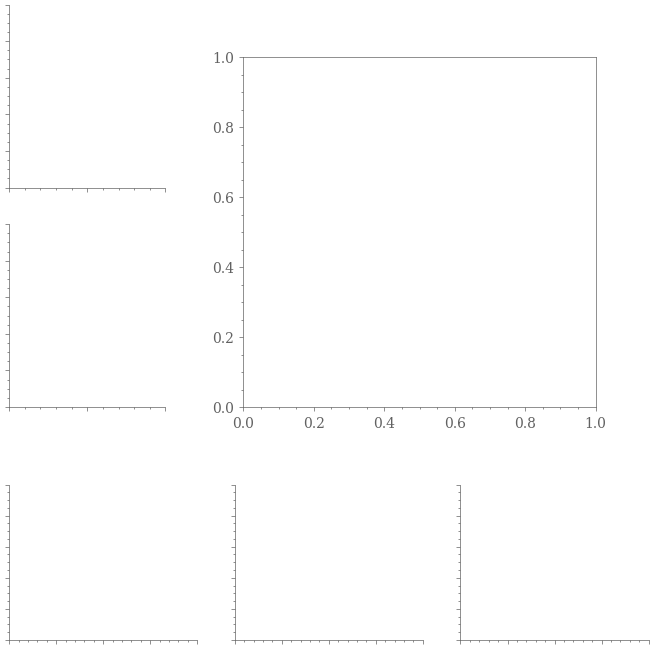

In [61]:
def make_cool_grid6(
    figsize=None,
    fig = None, 
    width_ratios=None,
    ncols=1,
    nrows=1,
    num_subplots_per_big_plot=2,
    size_big_plot=5,
    add_gs_kw=None,
    sharex='col',
    sharey='row',

    w_plot = 5.,
    w_cbar = 1,
    w_ratio_sideplot = 0.6,
    frac_dist_axis_from_big = .15
):
    width_small_plot = size_big_plot/(num_subplots_per_big_plot)
    width_dist_ax = size_big_plot*frac_dist_axis_from_big

    if figsize is None:
        figsize = [size_big_plot + width_small_plot+ width_dist_ax,
                   size_big_plot + width_small_plot+ width_dist_ax,
                   ]
        print(figsize)
    #width_ratios = None
    add_gs_kw = None

    #if width_ratios is None:
    #    width_ratios = [1] * ncols + [w_cbar / w_plot] #+ [1]* ncols_extra
    if add_gs_kw is None:
        add_gs_kw = dict()


    if 'hspace' not in add_gs_kw.keys():
        add_gs_kw['hspace'] = 0
    if 'wspace' not in add_gs_kw.keys():
        add_gs_kw['wspace'] = 0
    if fig is None:
        fig = plt.figure(figsize=figsize,
                     dpi=100)

    w_r1 = [size_big_plot,size_big_plot*frac_dist_axis_from_big]
    h_r1 = [frac_dist_axis_from_big,1, ]
    
    width_ratio_big_small = [size_big_plot+width_dist_ax,width_small_plot][::-1]
    height_ratio_big_small = [size_big_plot+width_dist_ax,width_small_plot]
    
    gs0 = gridspec.GridSpec(2, 2, figure=fig, height_ratios=height_ratio_big_small ,
                            width_ratios = width_ratio_big_small)
    # Big plot:
    gs00 = gridspec.GridSpecFromSubplotSpec(nrows+1, ncols+1, width_ratios=w_r1, height_ratios=h_r1, subplot_spec=gs0[0,1], **add_gs_kw)
    # for the small plots:
    gs01 = gridspec.GridSpecFromSubplotSpec(num_subplots_per_big_plot,2,width_ratios =[40,1], subplot_spec=gs0[:-1,0])#, **add_gs_kw)
    gs03 = gridspec.GridSpecFromSubplotSpec(2,num_subplots_per_big_plot+1, height_ratios =[1,40], subplot_spec=gs0[1,:])#, **add_gs_kw)
    # Axs for big plot and distribution axis:
    axs = gs00.subplots(sharex=sharex, sharey=sharey, )
    # Axes 
    axs_extra_sup = gs01.subplots(sharex=sharex, sharey=sharey, )
    axs_extra2_sup = gs03.subplots(sharex=sharex, sharey=sharey, )
    axs_extra = axs_extra_sup[:,0]
    axs_extra2 = axs_extra2_sup[1,:]
    for _ax in (list(axs_extra_sup[:,1].flatten())+list(axs_extra2_sup[0,:].flatten())) :
        _ax.axis("off")
        
    axs_extra = np.concatenate((axs_extra, axs_extra2[::-1],))
    
    axs[0,1].clear()
    axs[0,1].axis("off")
    daxs = dict(x=axs[0,0],y=axs[1,1])
    # distribution axis
    for a in daxs:
        _ax = daxs[a]
        sns.despine(bottom=False, left=False, ax=_ax)
        _ax.axis("off")
    # big plot!
    ax = axs[1,0]

    for ax_e in axs_extra:
        ax_e.set_xlabel('')
        ax_e.set_ylabel('')
        ax_e.set_ylim(ax.get_ylim())
        ax_e.set_xlim(ax.get_xlim())
        ax_e.axes.xaxis.set_ticklabels([])
        ax_e.axes.yaxis.set_ticklabels([])

        sns.despine(ax = ax_e)


    return fig, ax, daxs, axs_extra
make_cool_grid6()

In [62]:
from bs_fdbck.util.BSOA_datamanip.fits import get_least_square_fit_and_labs

In [63]:
def get_lin_log_fit(df_s, v_x, v_y, fit_func = 'exp', return_func=True, beta0=[0.01,.12]):
    v_log_y = f'ln({v_y})'
    df_s[v_log_y] = np.log(df_s[v_y])
    popt, pov, label, func_lin = get_odr_fit_and_labs(df_s, v_x, v_log_y, fit_func = 'linear', return_func=True, beta0=beta0)
    print('****ignore****')
    _, _, _, func = get_odr_fit_and_labs(df_s, v_x, v_log_y, fit_func = 'exp', return_func=True, beta0=beta0, pprint=False)
    print('****stop ignore****')
    popt_lin = popt
    a = np.exp(popt[-1])
    b = popt[0]
    
    if np.abs(a)< 0.009:
        #a_lab = ((str("%.2e" % a)).replace("e", ' \\cdot 10^{ ')).replace("+0", ") + ' } ')
        label = '($%.1E) \cdot e^{%5.2fx}$' %(a,b,)
    else:
        label = '$%5.2f e^{%5.2fx}$' %(a,b,)
    popt = [a,b]

    return popt, pov, label, func, func_lin, popt_lin

In [64]:
def get_r2_logy(df_s,v_x,x_y, popt, func):
    """
    Calculating the r2 value for a log scale fitting. 
    """
    v_log_y = f'ln({v_y})'
    df_s[v_log_y] = np.log(df_s[v_y])
    _df = df_s[[v_x, v_log_y]].dropna().copy()
    y_pred = func(_df[v_x].values, *popt)
    r2 =  r2_score(_df[v_log_y].values, y_pred)
    return r2

## FMA

(0.0, 47.25)
(0.0, 47.25)
(0.0, 52.5)
(0.0, 54.6)
(0.0, 54.6)
******ECHAM-SALSA*********
ECHAM-SALSA
[0.01, 0.12]
Beta: [ 0.23021082 -4.06577112]
Beta Std Error: [0.01074978 0.190172  ]
Beta Covariance: [[ 0.00049171 -0.00857277]
 [-0.00857277  0.15388659]]
Residual Variance: 0.23501326238205122
Inverse Condition #: 0.07332355188875521
Reason(s) for Halting:
  Sum of squares convergence
[ 0.23021082 -4.06577112]
reason for haltng
****ignore****
[0.01, 0.12]
[1.94392899e-14 1.44598381e+00]
reason for haltng
****stop ignore****
R2*****
0.5338331691640609
0.7094029490128918
******NorESM*********
NorESM
[0.01, 0.12]
Beta: [ 0.17659758 -2.41094499]
Beta Std Error: [0.00778226 0.12775732]
Beta Covariance: [[ 0.00028566 -0.00457295]
 [-0.00457295  0.0769862 ]]
Residual Variance: 0.21201113823218823
Inverse Condition #: 0.10261305394009396
Reason(s) for Halting:
  Sum of squares convergence
[ 0.17659758 -2.41094499]
reason for haltng
****ignore****
[0.01, 0.12]
[0.00109535 0.33992869]
reason f

/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


R2*****
0.1592974204107227
0.5912129696906706
******EC-Earth********
EC-Earth
[0.01, 0.12]
Beta: [ 0.23677754 -5.27140142]
Beta Std Error: [0.02775874 0.68045928]
Beta Covariance: [[ 0.0027052  -0.06625886]
 [-0.06625886  1.62556668]]
Residual Variance: 0.28483902967602404
Inverse Condition #: 0.013525727854872095
Reason(s) for Halting:
  Sum of squares convergence
[ 0.23677754 -5.27140142]
reason for haltng
****ignore****
[0.01, 0.12]
[1.82939169e-05 4.16003779e-01]
reason for haltng
****stop ignore****
R2*****
0.45407403431146887
0.7294018498169768
******UKESM********
UKESM
[0.01, 0.12]
Beta: [-0.25017304  8.40612547]
Beta Std Error: [0.06959192 2.03211878]
Beta Covariance: [[ 0.0049284  -0.14386683]
 [-0.14386683  4.2022977 ]]
Residual Variance: 0.9826782919361108
Inverse Condition #: 0.0073377621570734795
Reason(s) for Halting:
  Sum of squares convergence
[-0.25017304  8.40612547]
reason for haltng
****ignore****
[0.01, 0.12]
[81.33598609 -0.14758507]
reason for haltng
****stop ig

/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


/tmp/ipykernel_37332/1838988103.py:310: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  fig_main.savefig(fn.with_suffix('.pdf'), dpi=200)
/tmp/ipykernel_37332/1838988103.py:311: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  fig_main.savefig(fn.with_suffix('.png'), dpi=200)
/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/IPython/core/pylabtools.py:151: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  fig.canvas.print_figure(bytes_io, **kw)


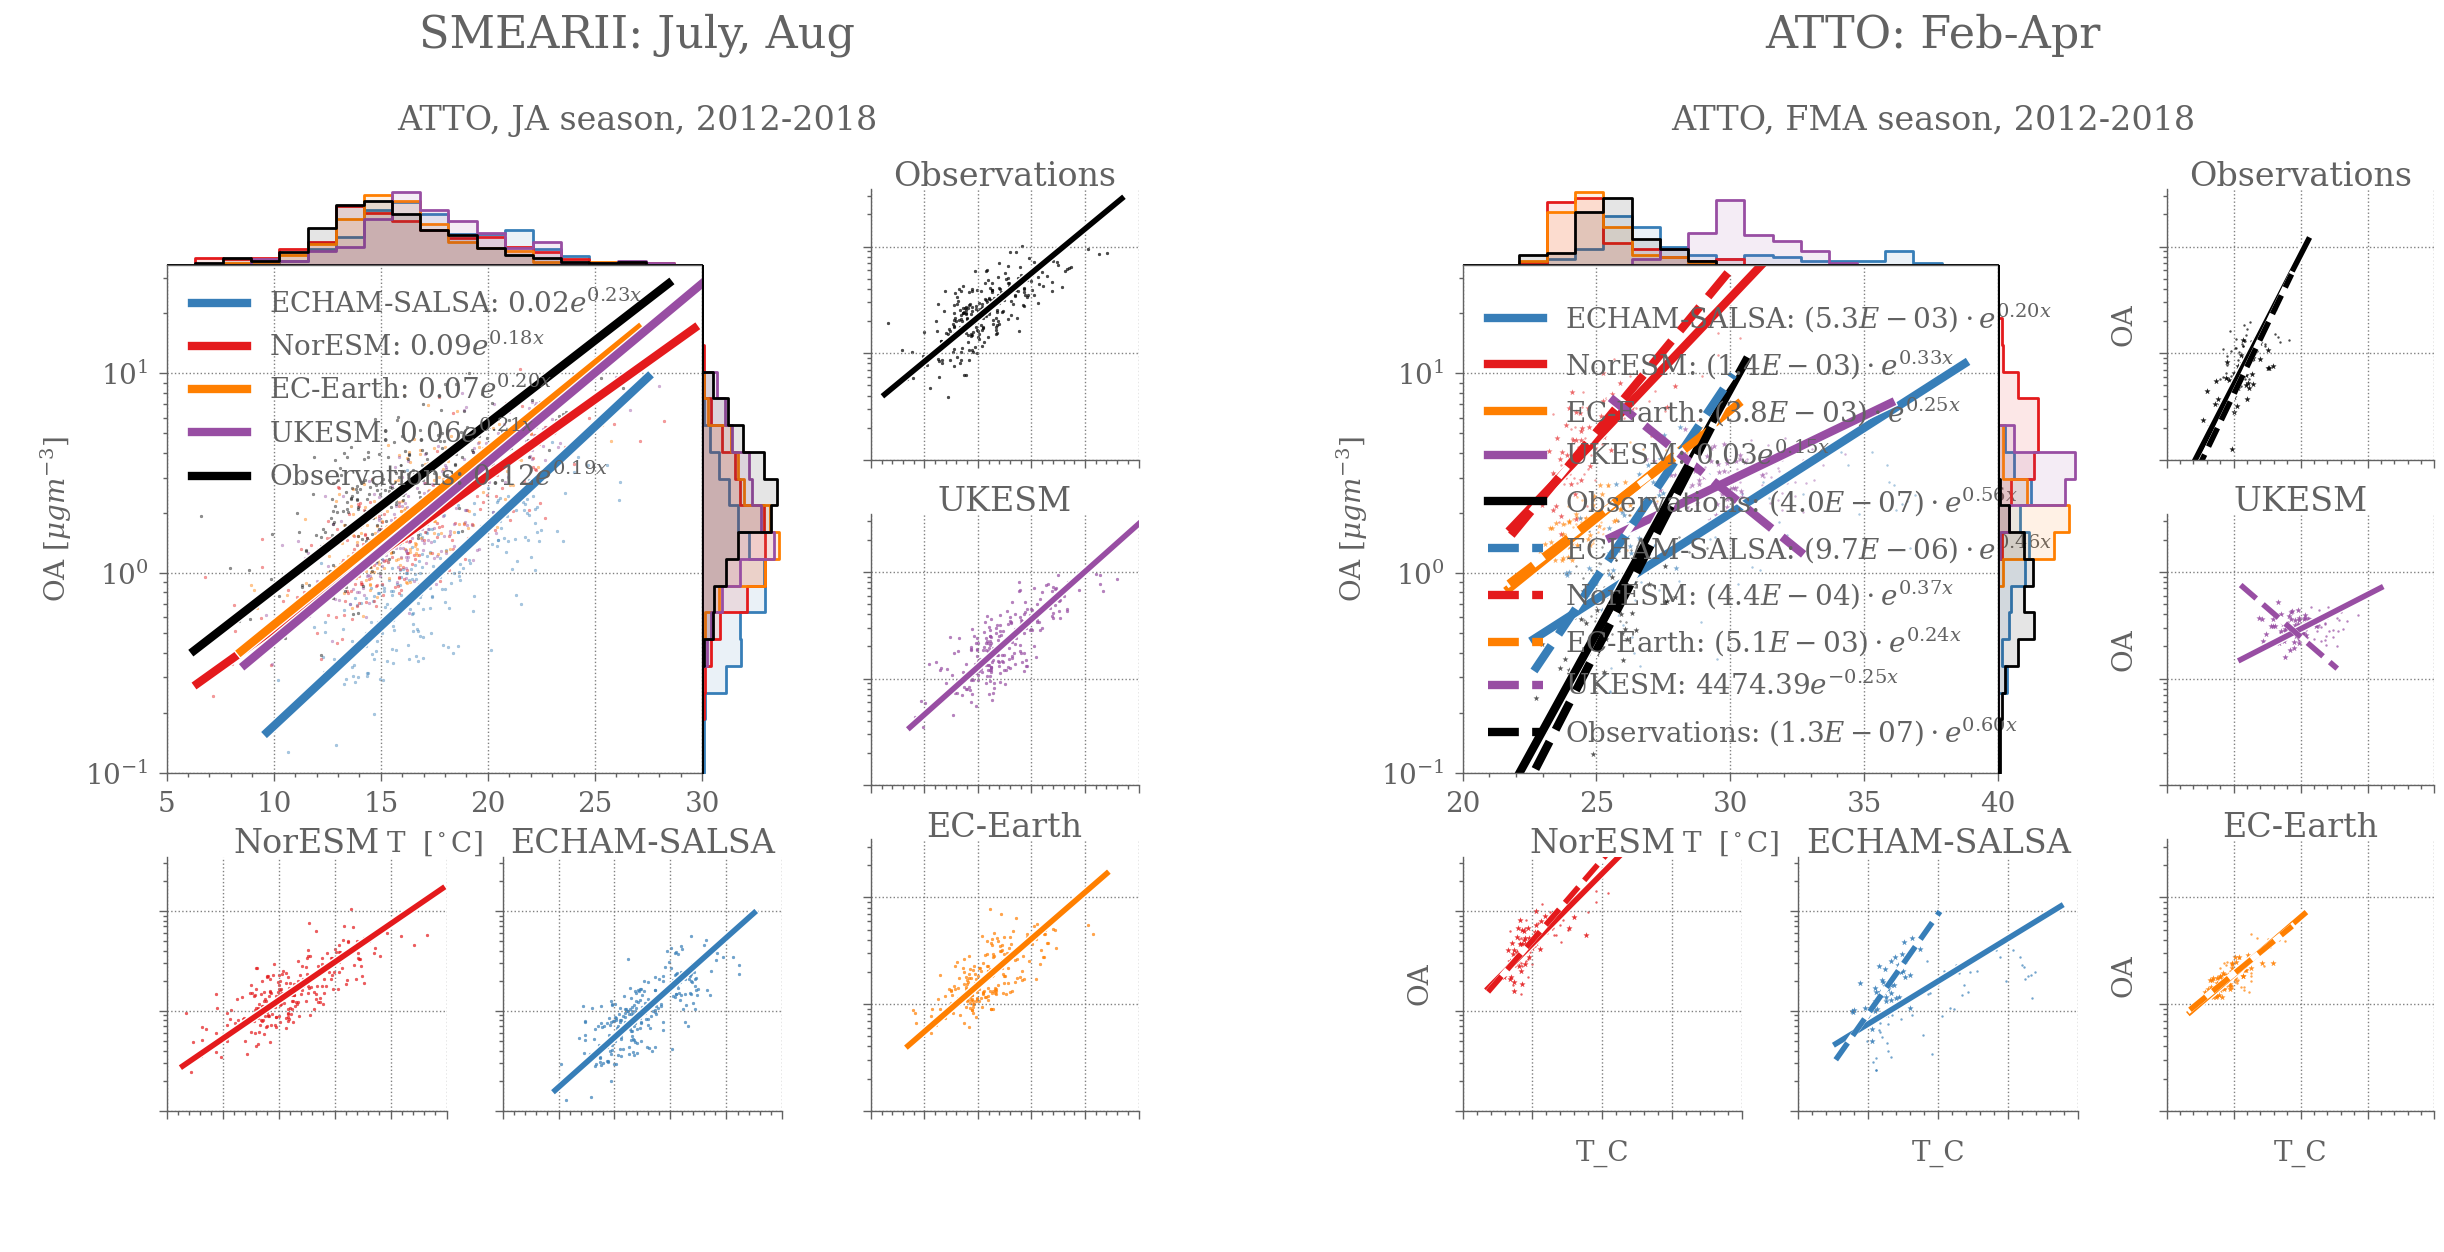

<Figure size 700x525 with 0 Axes>

<Figure size 700x525 with 0 Axes>

<Figure size 700x525 with 0 Axes>

<Figure size 700x525 with 0 Axes>

<Figure size 700x525 with 0 Axes>

<Figure size 700x525 with 0 Axes>

<Figure size 700x525 with 0 Axes>

<Figure size 700x525 with 0 Axes>

<Figure size 700x525 with 0 Axes>

<Figure size 700x525 with 0 Axes>

In [74]:
fx = .75
fig_main = plt.figure(constrained_layout=True,
                  figsize=[17*fx, 8.25*fx],
                 )
spec2 = gridspec.GridSpec( nrows=2,ncols=3, 
                          height_ratios=[1,30], 
                          width_ratios=[30,1,30], 
                          figure=fig_main)


markersize = 4

subfig_smr =  fig_main.add_subfigure(spec2[1, 0],frameon=True)
subfig_atto =  fig_main.add_subfigure(spec2[1, 2],frameon=True)
subfig_up_smr =  fig_main.add_subfigure(spec2[0, 0])
subfig_up_atto =  fig_main.add_subfigure(spec2[0, 2])



dic_fits = {}
dic_fits['SMR'] =dict()
dic_fits['ATTO'] =dict()



season_atto = 'FMA'
season_smr = 'JA'





fig, ax, daxs, axs_extra = make_cool_grid5(fig =subfig_smr )##ncols_extra=2, nrows_extra=2,)# w_ratio_sideplot=.5)

axs_extra = axs_extra.flatten()[::-1]








dic_df_med = dic_df_med_SMR
select_station = 'SMR'
dic_fits[select_station] = dict()
dic_fits[select_station][v_y] = dict()

## Settings
alpha_scatt = 0.6

xlab = r'T  [$^\circ$C]'
ylab = r'OA [$\mu g m^{-3}$]'


linewidth=2
xlims = [5,30]
ylims = [.1,35]


season=season_smr
v_x = 'T_C'
v_y = 'OA'
dic_fits[select_station][v_y] = dict()


make_plot(v_x, v_y, xlims, ylims, season, 
              xlab, ylab, .3, models_and_obs, fig, ax, daxs, axs_extra,
          yscale='log',
          dic_df_med = dic_df_med,
          markersize = markersize
         )


for mo, ax_ex in zip(models_and_obs, axs_extra[:]):
    print(f'******{mo}*********')
    df_s =  dic_df_med[mo]
    print(mo)
    mask_months = select_months(df_s, season=season)
    df_s = df_s[mask_months].copy()
    #popt, pov, label, func = get_least_square_fit_and_labs(df_s, v_x, v_y, fit_func = 'exp', return_func=True, beta0=[0.01,.12])
    #popt, pov, label, func = get_lin_log_fit(df_s, v_x, v_y, fit_func = 'exp', return_func=True, beta0=[0.01,.12])
    popt, pov, label, func,func_lin, popt_lin = get_lin_log_fit(df_s, v_x, v_y, fit_func = 'exp', return_func=True, beta0=[0.01,.12])

    dic_fits[select_station][v_y][mo] = dict()
    dic_fits[select_station][v_y][mo]['label'] = label
    dic_fits[select_station][v_y][mo]['popt'] = popt
    dic_fits[select_station][v_y][mo]['pcov'] = pov
    dic_fits[select_station][v_y][mo]['standard_error'] = np.sqrt(np.diag(dic_fits[select_station][v_y][mo]['pcov']))

    dic_fits[select_station][v_y][mo]['func'] = func
    dic_fits[select_station][v_y][mo]['R2'] = get_r2_logy(df_s,v_x,v_y, popt_lin, func_lin)
    dic_fits[select_station][v_y][mo]['corr'] = get_corr(df_s,v_x,v_y)
    print('R2*****')
    print(dic_fits[select_station][v_y][mo]['R2'])
    print(dic_fits[select_station][v_y][mo]['corr'])
    dic_fits[select_station][v_y][mo] = calc_table_se(dic_fits[select_station][v_y][mo])   

    
    
    _mi = df_s[v_x].min()
    _ma = df_s[v_x].max() 
    _xlim = [_mi*.95, _ma*1.05]
    x = np.linspace(*_xlim)
    
    ax.plot(x, func(x, *popt), c='w', linewidth=linewidth+2,label='__nolegend__')
    ax.plot(x, func(x, *popt), linewidth=linewidth+1, c=cdic_model[mo],label=f'{mo}: {label}')

    ax_ex.plot(x, func(x, *popt), c='w', linewidth=linewidth+1,label=f'{mo}: {label}',
             )
    ax_ex.plot(x, func(x, *popt), c=cdic_model[mo],label=f'{mo}: {label}',
               linewidth=linewidth,
              )
    ax_ex.set_yscale('log')
ax.set_yscale('log')
ax.grid(color='grey', linewidth=.5, linestyle=':', )
ax.set_xticks(np.arange(5,31,5))

for ax_ex in axs_extra:
    ax_ex.set_yticklabels([])
    ax_ex.set_xticks(np.arange(5,31,5))
    ax_ex.grid(color='grey', linewidth=.5, linestyle=':')
    ax_ex.set_ylim(ylims)
    ax_ex.set_xlim(xlims)

    
fn = make_fn_scat(f'exp1_{season}', v_x, v_y)
ax.legend(frameon=False)




## ATTO:
select_station = 'ATTO'
dic_fits[select_station] = dict()
dic_fits[select_station][v_y] = dict()


xlims = [20,40]



fig, ax, daxs, axs_extra = make_cool_grid5(fig =subfig_atto )##ncols_extra=2, nrows_extra=2,)# w_ratio_sideplot=.5)

axs_extra = axs_extra.flatten()[::-1]

dic_df_med = dic_df_med_ATTO

# Remove 2015 and 2016:
dic_df_med_adj = dict()

for k in dic_df_med.keys():
    _df  = dic_df_med[k].copy()
    _df = _df[~_df.index.year.isin([2015,2016])]
    dic_df_med_adj[k] = _df

## Settings
alpha_scatt = 0.6


linewidth=2
xlims = [20,40]


season = season_atto


make_plot(v_x, v_y, xlims, ylims, season, 
              xlab, ylab, .2, models_and_obs, fig, ax, daxs, axs_extra,
          yscale='log',
          dic_df_med = dic_df_med,
          markersize=markersize-2,
          marker='.',
         
         )
make_scatter_plot(v_x, v_y, xlims, ylims, season, 
              xlab, ylab, .2, models_and_obs, fig, ax, daxs, axs_extra,
          yscale='log',
          dic_df_med = dic_df_med_adj,
          markersize=markersize,
                  marker='*',
         
         )




for mo, ax_ex in zip(models_and_obs, axs_extra[:]):
    print(f'******{mo}********')
    df_s =  dic_df_med[mo]
    print(mo)
    mask_months = select_months(df_s, season=season)
    df_s = df_s[mask_months].copy()
    
    #popt, pov, label, func = get_least_square_fit_and_labs(df_s, v_x, v_y, fit_func = 'exp', return_func=True, beta0=[0.01,.12])
    #popt, pov, label, func = get_odr_fit_and_labs(df_s, v_x, v_y, fit_func = 'exp', return_func=True, beta0=[0.01,.12])
    popt, pov, label, func, func_lin, popt_lin = get_lin_log_fit(df_s, v_x, v_y, fit_func = 'exp', return_func=True, beta0=[0.01,.12])
        
    dic_fits[select_station][v_y][mo] = dict()
    dic_fits[select_station][v_y][mo]['label'] = label
    dic_fits[select_station][v_y][mo]['popt'] = popt
    dic_fits[select_station][v_y][mo]['pcov'] = pov
    dic_fits[select_station][v_y][mo]['standard_error'] = np.sqrt(np.diag(dic_fits[select_station][v_y][mo]['pcov']))

    dic_fits[select_station][v_y][mo]['func'] = func
    dic_fits[select_station][v_y][mo]['R2'] = get_r2_logy(df_s,v_x,v_y, popt_lin, func_lin)
    dic_fits[select_station][v_y][mo]['corr'] = get_corr(df_s,v_x,v_y)
    print('R2*****')
    print(dic_fits[select_station][v_y][mo]['R2'])
    print(dic_fits[select_station][v_y][mo]['corr'])
    
    dic_fits[select_station][v_y][mo] = calc_table_se(dic_fits[select_station][v_y][mo])   

    
    
    _mi = df_s[v_x].min()
    _ma = df_s[v_x].max() 
    _xlim = [_mi*.95, _ma*1.05]
    x = np.linspace(*_xlim)
    
    ax.plot(x, func(x, *popt), c='w', linewidth=linewidth+2,label='__nolegend__')
    ax.plot(x, func(x, *popt), linewidth=linewidth+1, c=cdic_model[mo],label=f'{mo}: {label}')

    ax_ex.plot(x, func(x, *popt), c='w', linewidth=linewidth+1,label=f'{mo}: {label}',
             )
    ax_ex.plot(x, func(x, *popt), c=cdic_model[mo],label=f'{mo}: {label}',
               linewidth=linewidth,
              )
    ax_ex.set_yscale('log')
    ax_ex.set_ylim(ylims)
    ax_ex.set_xlim(xlims)
    
#WITHOUT 2015-2016
for mo, ax_ex in zip(models_and_obs, axs_extra[:]):
    print(f'******{mo}********')
    df_s =  dic_df_med_adj[mo]
    print(mo)
    mask_months = select_months(df_s, season=season)
    df_s = df_s[mask_months].copy()
    
    #popt, pov, label, func = get_least_square_fit_and_labs(df_s, v_x, v_y, fit_func = 'exp', return_func=True, beta0=[0.01,.12])
    #popt, pov, label, func = get_odr_fit_and_labs(df_s, v_x, v_y, fit_func = 'exp', return_func=True, beta0=[0.01,.12])
    popt, pov, label, func, func_lin, popt_lin = get_lin_log_fit(df_s, v_x, v_y, fit_func = 'exp', return_func=True, beta0=[0.01,.12])
        
    dic_fits[select_station][v_y][mo] = dict()
    dic_fits[select_station][v_y][mo]['label'] = label
    dic_fits[select_station][v_y][mo]['popt'] = popt
    dic_fits[select_station][v_y][mo]['pcov'] = pov
    dic_fits[select_station][v_y][mo]['standard_error'] = np.sqrt(np.diag(dic_fits[select_station][v_y][mo]['pcov']))

    dic_fits[select_station][v_y][mo]['func'] = func
    dic_fits[select_station][v_y][mo]['R2'] = get_r2_logy(df_s,v_x,v_y, popt_lin, func_lin)
    dic_fits[select_station][v_y][mo]['corr'] = get_corr(df_s,v_x,v_y)
    print('R2*****')
    print(dic_fits[select_station][v_y][mo]['R2'])
    print(dic_fits[select_station][v_y][mo]['corr'])
    
    dic_fits[select_station][v_y][mo] = calc_table_se(dic_fits[select_station][v_y][mo])   

    
    
    _mi = df_s[v_x].min()
    _ma = df_s[v_x].max() 
    _xlim = [_mi*.95, _ma*1.05]
    x = np.linspace(*_xlim)
    
    ax.plot(x, func(x, *popt), c='w', linewidth=linewidth+.2,label='__nolegend__')
    ax.plot(x, func(x, *popt), linestyle= '--',linewidth=linewidth+1, c=cdic_model[mo],label=f'{mo}: {label}')

    ax_ex.plot(x, func(x, *popt), c='w', linewidth=linewidth+.1,label=f'{mo}: {label}',
             )
    ax_ex.plot(x, func(x, *popt),linestyle= '--', c=cdic_model[mo],label=f'{mo}: {label}',
               linewidth=linewidth,
              )
    ax_ex.set_yscale('log')
    ax_ex.set_ylim(ylims)
    ax_ex.set_xlim(xlims)
ax.set_yscale('log')
ax.grid(color='grey', linewidth=.5, linestyle=':')

ax.set_xticks(np.arange(20,41,5))

for ax_ex in axs_extra.flatten():
    ax_ex.set_yticklabels([])
    ax_ex.set_xticks(np.arange(20,41,5))
    ax_ex.grid(color='grey', linewidth=.5, linestyle=':')

    
ax.legend(frameon=False)











ax_up_smr = subfig_up_smr.subplots()
ax_up_smr.axis('off')
subfig_up_smr.suptitle('SMEARII: July, Aug',size=16,)
ax_up_atto = subfig_up_atto.subplots()
ax_up_atto.axis('off')
subfig_up_atto.suptitle(f'ATTO: {dic_season_nicename[season_atto]}',size=16,)

fn = make_fn_scat(f'together_{season_smr}_{season_atto}', v_x, v_y)
print(fn)
fig_main.savefig(fn.with_suffix('.pdf'), dpi=200)
fig_main.savefig(fn.with_suffix('.png'), dpi=200)
plt.show()

df = make_pd_of_dic(dic_fits)
df_OA = df
df.to_csv(fn.with_suffix('.csv'))


fx = .75
fig_main = plt.figure(constrained_layout=True,
                  figsize=[17*fx, 8.25*fx],
                 )
spec2 = gridspec.GridSpec( nrows=2,ncols=3, 
                          height_ratios=[1,30], 
                          width_ratios=[30,1,30], 
                          figure=fig_main)


markersize = 4

subfig_smr =  fig_main.add_subfigure(spec2[1, 0],frameon=True)
subfig_atto =  fig_main.add_subfigure(spec2[1, 2],frameon=True)
subfig_up_smr =  fig_main.add_subfigure(spec2[0, 0])
subfig_up_atto =  fig_main.add_subfigure(spec2[0, 2])



dic_fits = {}
dic_fits['SMR'] =dict()
dic_fits['ATTO'] =dict()



season_atto = 'FMA'
season_smr = 'JA'





fig, ax, daxs, axs_extra = make_cool_grid5(fig =subfig_smr )##ncols_extra=2, nrows_extra=2,)# w_ratio_sideplot=.5)

axs_extra = axs_extra.flatten()[::-1]








dic_df_med = dic_df_med_SMR
select_station = 'SMR'
dic_fits[select_station] = dict()
dic_fits[select_station][v_y] = dict()

## Settings
alpha_scatt = 0.6

xlab = r'T  [$^\circ$C]'
ylab = r'OA [$\mu g m^{-3}$]'


linewidth=2
xlims = [5,30]
ylims = [.1,35]


season=season_smr
v_x = 'T_C'
v_y = 'OA'
dic_fits[select_station][v_y] = dict()


make_plot(v_x, v_y, xlims, ylims, season, 
              xlab, ylab, .3, models_and_obs, fig, ax, daxs, axs_extra,
          yscale='log',
          dic_df_med = dic_df_med,
          markersize = markersize
         )


for mo, ax_ex in zip(models_and_obs, axs_extra[:]):
    print(f'******{mo}*********')
    df_s =  dic_df_med[mo]
    print(mo)
    mask_months = select_months(df_s, season=season)
    df_s = df_s[mask_months].copy()
    #popt, pov, label, func = get_least_square_fit_and_labs(df_s, v_x, v_y, fit_func = 'exp', return_func=True, beta0=[0.01,.12])
    #popt, pov, label, func = get_lin_log_fit(df_s, v_x, v_y, fit_func = 'exp', return_func=True, beta0=[0.01,.12])
    popt, pov, label, func,func_lin, popt_lin = get_lin_log_fit(df_s, v_x, v_y, fit_func = 'exp', return_func=True, beta0=[0.01,.12])

    dic_fits[select_station][v_y][mo] = dict()
    dic_fits[select_station][v_y][mo]['label'] = label
    dic_fits[select_station][v_y][mo]['popt'] = popt
    dic_fits[select_station][v_y][mo]['pcov'] = pov
    dic_fits[select_station][v_y][mo]['standard_error'] = np.sqrt(np.diag(dic_fits[select_station][v_y][mo]['pcov']))

    dic_fits[select_station][v_y][mo]['func'] = func
    dic_fits[select_station][v_y][mo]['R2'] = get_r2_logy(df_s,v_x,v_y, popt_lin, func_lin)
    dic_fits[select_station][v_y][mo]['corr'] = get_corr(df_s,v_x,v_y)
    print('R2*****')
    print(dic_fits[select_station][v_y][mo]['R2'])
    print(dic_fits[select_station][v_y][mo]['corr'])
    dic_fits[select_station][v_y][mo] = calc_table_se(dic_fits[select_station][v_y][mo])   

    
    
    _mi = df_s[v_x].min()
    _ma = df_s[v_x].max() 
    _xlim = [_mi*.95, _ma*1.05]
    x = np.linspace(*_xlim)
    
    ax.plot(x, func(x, *popt), c='w', linewidth=linewidth+2,label='__nolegend__')
    ax.plot(x, func(x, *popt), linewidth=linewidth+1, c=cdic_model[mo],label=f'{mo}: {label}')

    ax_ex.plot(x, func(x, *popt), c='w', linewidth=linewidth+1,label=f'{mo}: {label}',
             )
    ax_ex.plot(x, func(x, *popt), c=cdic_model[mo],label=f'{mo}: {label}',
               linewidth=linewidth,
              )
    ax_ex.set_yscale('log')
ax.set_yscale('log')
ax.grid(color='grey', linewidth=.5, linestyle=':', )
ax.set_xticks(np.arange(5,31,5))

for ax_ex in axs_extra:
    ax_ex.set_yticklabels([])
    ax_ex.set_xticks(np.arange(5,31,5))
    ax_ex.grid(color='grey', linewidth=.5, linestyle=':')
    ax_ex.set_ylim(ylims)
    ax_ex.set_xlim(xlims)

    
fn = make_fn_scat(f'exp1_{season}', v_x, v_y)
ax.legend(frameon=False)




## ATTO:
select_station = 'ATTO'
dic_fits[select_station] = dict()
dic_fits[select_station][v_y] = dict()


xlims = [20,40]



fig, ax, daxs, axs_extra = make_cool_grid5(fig =subfig_atto )##ncols_extra=2, nrows_extra=2,)# w_ratio_sideplot=.5)

axs_extra = axs_extra.flatten()[::-1]

dic_df_med = dic_df_med_ATTO


## Settings
alpha_scatt = 0.6


linewidth=2
xlims = [20,40]


season = season_atto


make_plot(v_x, v_y, xlims, ylims, season, 
              xlab, ylab, .3, models_and_obs, fig, ax, daxs, axs_extra,
          yscale='log',
          dic_df_med = dic_df_med,
          markersize=markersize,
         
         )


for mo, ax_ex in zip(models_and_obs, axs_extra[:]):
    print(f'******{mo}********')
    df_s =  dic_df_med[mo]
    print(mo)
    mask_months = select_months(df_s, season=season)
    df_s = df_s[mask_months].copy()
    
    #popt, pov, label, func = get_least_square_fit_and_labs(df_s, v_x, v_y, fit_func = 'exp', return_func=True, beta0=[0.01,.12])
    #popt, pov, label, func = get_odr_fit_and_labs(df_s, v_x, v_y, fit_func = 'exp', return_func=True, beta0=[0.01,.12])
    popt, pov, label, func, func_lin, popt_lin = get_lin_log_fit(df_s, v_x, v_y, fit_func = 'exp', return_func=True, beta0=[0.01,.12])
        
    dic_fits[select_station][v_y][mo] = dict()
    dic_fits[select_station][v_y][mo]['label'] = label
    dic_fits[select_station][v_y][mo]['popt'] = popt
    dic_fits[select_station][v_y][mo]['pcov'] = pov
    dic_fits[select_station][v_y][mo]['standard_error'] = np.sqrt(np.diag(dic_fits[select_station][v_y][mo]['pcov']))

    dic_fits[select_station][v_y][mo]['func'] = func
    dic_fits[select_station][v_y][mo]['R2'] = get_r2_logy(df_s,v_x,v_y, popt_lin, func_lin)
    dic_fits[select_station][v_y][mo]['corr'] = get_corr(df_s,v_x,v_y)
    print('R2*****')
    print(dic_fits[select_station][v_y][mo]['R2'])
    print(dic_fits[select_station][v_y][mo]['corr'])
    
    dic_fits[select_station][v_y][mo] = calc_table_se(dic_fits[select_station][v_y][mo])   

    
    
    _mi = df_s[v_x].min()
    _ma = df_s[v_x].max() 
    _xlim = [_mi*.95, _ma*1.05]
    x = np.linspace(*_xlim)
    
    ax.plot(x, func(x, *popt), c='w', linewidth=linewidth+2,label='__nolegend__')
    ax.plot(x, func(x, *popt), linewidth=linewidth+1, c=cdic_model[mo],label=f'{mo}: {label}')

    ax_ex.plot(x, func(x, *popt), c='w', linewidth=linewidth+1,label=f'{mo}: {label}',
             )
    ax_ex.plot(x, func(x, *popt), c=cdic_model[mo],label=f'{mo}: {label}',
               linewidth=linewidth,
              )
    ax_ex.set_yscale('log')
    ax_ex.set_ylim(ylims)
    ax_ex.set_xlim(xlims)
ax.set_yscale('log')
ax.grid(color='grey', linewidth=.5, linestyle=':')

ax.set_xticks(np.arange(20,41,5))

for ax_ex in axs_extra.flatten():
    ax_ex.set_yticklabels([])
    ax_ex.set_xticks(np.arange(20,41,5))
    ax_ex.grid(color='grey', linewidth=.5, linestyle=':')

    
ax.legend(frameon=False)











ax_up_smr = subfig_up_smr.subplots()
ax_up_smr.axis('off')
subfig_up_smr.suptitle('SMEARII: July, Aug',size=16,)
ax_up_atto = subfig_up_atto.subplots()
ax_up_atto.axis('off')
subfig_up_atto.suptitle(f'ATTO: {dic_season_nicename[season_atto]}',size=16,)

fn = make_fn_scat(f'together_{season_smr}_{season_atto}', v_x, v_y)
print(fn)
#fig_main.savefig(fn.with_suffix('.pdf'), dpi=200)
#fig_main.savefig(fn.with_suffix('.png'), dpi=200)
plt.show()

df = make_pd_of_dic(dic_fits)
df_OA = df
df.to_csv(fn.with_suffix('.csv'))


In [45]:
df_OA

Fit R$^2$  \
station variable data source                                        
SMR     OA       ECHAM-SALSA             $ 0.02 e^{ 0.23x}$  0.53   
                 NorESM                  $ 0.09 e^{ 0.18x}$  0.58   
                 EC-Earth                $ 0.07 e^{ 0.20x}$  0.43   
                 UKESM                   $ 0.06 e^{ 0.21x}$  0.58   
                 Observations            $ 0.12 e^{ 0.19x}$  0.45   
ATTO    OA       ECHAM-SALSA   ($5.3E-03) \cdot e^{ 0.20x}$ -0.06   
                 NorESM        ($1.4E-03) \cdot e^{ 0.33x}$  0.41   
                 EC-Earth      ($3.8E-03) \cdot e^{ 0.25x}$  0.39   
                 UKESM                   $ 0.03 e^{ 0.15x}$ -0.86   
                 Observations  ($4.0E-07) \cdot e^{ 0.56x}$  0.19   

                                                     a                b c  \
station variable data source                                                
SMR     OA       ECHAM-SALSA   1.71E-02 $\pm$ 2.22E-02  0.23 $\pm$ 0.39     
                 NorESM        8.97E-02 $\pm$ 1.69E-02  0.18 $\pm$ 0.28     
                 EC-Earth      7.41E-02 $\pm$ 2.04E-02  0.20 $\pm$ 0.33     
                 UKESM         5.86E-02 $\pm$ 1.97E-02  0.21 $\pm$ 0.35     
                 Observations          0.12 $\pm$ 0.02  0.19 $\pm$ 0.30     
ATTO    OA       ECHAM-SALSA   5.32E-03 $\pm$ 3.34E-02  0.20 $\pm$ 0.95     
                 NorESM        1.39E-03 $\pm$ 5.11E-02  0.33 $\pm$ 1.28     
                 EC-Earth      3.75E-03 $\pm$ 3.92E-02  0.25 $\pm$ 0.98     
                 UKESM         3.42E-02 $\pm$ 2.94E-02  0.15 $\pm$ 0.89     
                 Observations  3.96E-07 $\pm$ 9.18E-02  0.56 $\pm$ 2.35     

                              r$^2$  
station variable data source         
SMR     OA       ECHAM-SALSA   0.71  
                 NorESM        0.71  
                 EC-Earth      0.67  
                 UKESM         0.79  
                 Observations  0.73  
ATTO    OA       ECHAM-SALSA   0.46  
                 NorESM        0.77  
                 EC-Earth       0.7  
                 UKESM         0.06  
                 Observations  0.62

### Write all fits

In [46]:
df_all = pd.concat([df_log, df_linear, df_OA], axis=0)


df_all['full_fit'] = df_all['Fit'].copy()
df_all = df_all.reset_index()
for i in df_all.index:
    #print(i)
    #print(df_all.loc[i,'Fit'].values[0])
    if 'ln' in df_all.loc[i,'Fit']:
        df_all.loc[i,'Fit'] = '$a+b\ln{(c+x)}$'

    elif 'e^' in df_all.loc[i,'Fit']:
        df_all.loc[i,'Fit'] = '$a\cdot \exp{(bx)}$'
    else:
        df_all.loc[i,'Fit'] = '$ax +b$'
df_all = (df_all
          .sort_values(['station','variable','data source','Fit'], ascending=False)
          .set_index(['station','variable','data source','Fit'])        
         )
df_all.to_csv('Plots/Both_stations/all_fits.csv')

In [47]:
df_all_rn = df_all.rename({'N100-500':'N100','N50-500':'N50','N200-500':'N200',})

In [48]:
df_all_rn.loc['ATTO'].drop_duplicates()

R$^2$                        a  \
variable data source  Fit                                                  
OA       UKESM        $a\cdot \exp{(bx)}$ -0.86  3.42E-02 $\pm$ 2.94E-02   
         Observations $a\cdot \exp{(bx)}$  0.19  3.96E-07 $\pm$ 9.18E-02   
         NorESM       $a\cdot \exp{(bx)}$  0.41  1.39E-03 $\pm$ 5.11E-02   
         ECHAM-SALSA  $a\cdot \exp{(bx)}$ -0.06  5.32E-03 $\pm$ 3.34E-02   
         EC-Earth     $a\cdot \exp{(bx)}$  0.39  3.75E-03 $\pm$ 3.92E-02   
N50      UKESM        $ax +b$             -0.27         386.1 $\pm$ 67.9   
                      $ax +b$             -0.27         386.1 $\pm$ 67.9   
         Observations $ax +b$              0.32         274.7 $\pm$ 43.8   
         NorESM       $ax +b$              0.81         362.1 $\pm$ 53.8   
                      $ax +b$              0.81         362.1 $\pm$ 53.8   
         ECHAM-SALSA  $ax +b$              0.26         169.5 $\pm$ 27.3   
         EC-Earth     $ax +b$              0.46          83.0 $\pm$ 12.9   
N200     UKESM        $ax +b$              0.95         149.1 $\pm$ 21.8   
                      $ax +b$              0.95         149.1 $\pm$ 21.8   
         Observations $ax +b$              0.06          66.9 $\pm$ 11.1   
         NorESM       $ax +b$              0.93           28.0 $\pm$ 4.1   
                      $ax +b$              0.93           28.0 $\pm$ 4.1   
         ECHAM-SALSA  $ax +b$              0.88           25.0 $\pm$ 3.7   
         EC-Earth     $ax +b$              0.94           44.5 $\pm$ 6.5   
N100     UKESM        $ax +b$              0.38         264.1 $\pm$ 41.7   
                      $ax +b$              0.38         264.1 $\pm$ 41.7   
         Observations $ax +b$              0.36         182.0 $\pm$ 28.8   
         NorESM       $ax +b$              0.96         294.5 $\pm$ 42.9   
                      $ax +b$              0.96         294.5 $\pm$ 42.9   
         ECHAM-SALSA  $ax +b$              0.08         111.3 $\pm$ 18.4   
         EC-Earth     $ax +b$              0.81           64.9 $\pm$ 9.7   

                                                           b c r$^2$  \
variable data source  Fit                                              
OA       UKESM        $a\cdot \exp{(bx)}$    0.15 $\pm$ 0.89    0.06   
         Observations $a\cdot \exp{(bx)}$    0.56 $\pm$ 2.35    0.62   
         NorESM       $a\cdot \exp{(bx)}$    0.33 $\pm$ 1.28    0.77   
         ECHAM-SALSA  $a\cdot \exp{(bx)}$    0.20 $\pm$ 0.95    0.46   
         EC-Earth     $a\cdot \exp{(bx)}$    0.25 $\pm$ 0.98     0.7   
N50      UKESM        $ax +b$              122.6 $\pm$ 107.4    0.36   
                      $ax +b$              245.2 $\pm$ 214.8    0.36   
         Observations $ax +b$                68.7 $\pm$ 40.9    0.66   
         NorESM       $ax +b$               198.5 $\pm$ 40.7    0.91   
                      $ax +b$               396.9 $\pm$ 81.3    0.91   
         ECHAM-SALSA  $ax +b$               181.6 $\pm$ 55.3    0.63   
         EC-Earth     $ax +b$               167.4 $\pm$ 26.4    0.73   
N200     UKESM        $ax +b$               6.70 $\pm$ 34.69    0.98   
                      $ax +b$                13.4 $\pm$ 69.4    0.98   
         Observations $ax +b$              -6.67 $\pm$ 10.30    0.53   
         NorESM       $ax +b$               -7.15 $\pm$ 3.11    0.96   
                      $ax +b$                -14.3 $\pm$ 6.2    0.96   
         ECHAM-SALSA  $ax +b$               -9.69 $\pm$ 7.63    0.94   
         EC-Earth     $ax +b$               -13.3 $\pm$ 13.3    0.97   
N100     UKESM        $ax +b$               143.6 $\pm$ 66.2    0.69   
                      $ax +b$              287.2 $\pm$ 132.4    0.69   
         Observations $ax +b$                23.0 $\pm$ 27.0    0.68   
         NorESM       $ax +b$                34.2 $\pm$ 32.5    0.98   
                      $ax +b$                68.4 $\pm$ 65.1    0.98   
         ECHAM-SALSA  $ax +b$            

In [49]:
df_linear_rn = df_linear.rename({'N100-500':'N100','N50-500':'N50','N200-500':'N200',})
df_linear_rn
df_linear_rn['a_float']=df_linear_rn['a'].apply(lambda x: float(x.split(' ')[0]))
df_linear_rn['a_std_float']=df_linear_rn['a'].apply(lambda x: float(x.split(' ')[-1]))


In [50]:
_df = df_linear_rn[['a_float']].reset_index().drop_duplicates().set_index(['station','variable','data source'])


_df_smr = _df.reset_index().set_index(['station']).loc['SMR',:]
_df_atto = _df.reset_index().set_index(['station']).loc['ATTO',:]


_df1 = _df_smr.rename({'a_float':'a_smr'}, axis=1).reset_index().drop('station', axis=1)
_df2 = _df_atto.rename({'a_float':'a_atto'}, axis=1).reset_index().drop('station', axis=1)

_df_comb = pd.concat([_df1.set_index(['variable','data source']), _df2.set_index(['variable','data source'])], axis=1)

_df_comb

a_smr  a_atto
variable data source                
N50      Observations  274.8   274.7
         UKESM         331.5   386.1
         EC-Earth      141.2    83.0
         NorESM        703.5   362.1
         ECHAM-SALSA   325.2   169.5
N100     Observations  176.5   182.0
         UKESM         263.2   264.1
         EC-Earth       93.9    64.9
         NorESM        312.3   294.5
         ECHAM-SALSA   158.5   111.3
N200     Observations   53.6    66.9
         UKESM         132.4   149.1
         EC-Earth       42.3    44.5
         NorESM         29.6    28.0
         ECHAM-SALSA    35.5    25.0

In [51]:
_df = df_linear_rn[['a_std_float']].reset_index().drop_duplicates().set_index(['station','variable','data source'])


_df_smr_std = _df.reset_index().set_index(['station']).loc['SMR',:]
_df_atto_std = _df.reset_index().set_index(['station']).loc['ATTO',:]


_df1_std = _df_smr_std.rename({'a_std_float':'a_std_smr'}, axis=1).reset_index().drop('station', axis=1)
_df2_std = _df_atto_std.rename({'a_std_float':'a_std_atto'}, axis=1).reset_index().drop('station', axis=1)

_df_comb_std = pd.concat([_df1_std.set_index(['variable','data source']), _df2_std.set_index(['variable','data source'])], axis=1)

_df_comb_std

a_std_smr  a_std_atto
variable data source                        
N50      Observations       28.7        43.8
         UKESM              31.6        67.9
         EC-Earth           14.0        12.9
         NorESM             65.2        53.8
         ECHAM-SALSA        32.7        27.3
N100     Observations       16.6        28.8
         UKESM              24.8        41.7
         EC-Earth            9.0         9.7
         NorESM             28.5        42.9
         ECHAM-SALSA        14.8        18.4
N200     Observations        4.9        11.1
         UKESM              12.1        21.8
         EC-Earth            4.0         6.5
         NorESM              2.8         4.1
         ECHAM-SALSA         3.3         3.7

In [52]:
_df = df_linear_rn[['a_float']].reset_index().drop_duplicates().set_index(['station','variable','data source'])


_df_smr = _df.reset_index().set_index(['station']).loc['SMR',:]
_df_atto = _df.reset_index().set_index(['station']).loc['ATTO',:]


_df1 = _df_smr.rename({'a_float':'a_smr'}, axis=1).reset_index().drop('station', axis=1)
_df2 = _df_atto.rename({'a_float':'a_atto'}, axis=1).reset_index().drop('station', axis=1)

_df_comb = pd.concat([_df1.set_index(['variable','data source']), _df2.set_index(['variable','data source'])], axis=1)

_df_comb

a_smr  a_atto
variable data source                
N50      Observations  274.8   274.7
         UKESM         331.5   386.1
         EC-Earth      141.2    83.0
         NorESM        703.5   362.1
         ECHAM-SALSA   325.2   169.5
N100     Observations  176.5   182.0
         UKESM         263.2   264.1
         EC-Earth       93.9    64.9
         NorESM        312.3   294.5
         ECHAM-SALSA   158.5   111.3
N200     Observations   53.6    66.9
         UKESM         132.4   149.1
         EC-Earth       42.3    44.5
         NorESM         29.6    28.0
         ECHAM-SALSA    35.5    25.0

In [53]:
_df_comb = pd.concat([_df1.set_index(['variable','data source']), _df2.set_index(['variable','data source']),
                     _df1_std.set_index(['variable','data source']), _df2_std.set_index(['variable','data source'])], axis=1)


In [54]:
_df_comb

a_smr  a_atto  a_std_smr  a_std_atto
variable data source                                       
N50      Observations  274.8   274.7       28.7        43.8
         UKESM         331.5   386.1       31.6        67.9
         EC-Earth      141.2    83.0       14.0        12.9
         NorESM        703.5   362.1       65.2        53.8
         ECHAM-SALSA   325.2   169.5       32.7        27.3
N100     Observations  176.5   182.0       16.6        28.8
         UKESM         263.2   264.1       24.8        41.7
         EC-Earth       93.9    64.9        9.0         9.7
         NorESM        312.3   294.5       28.5        42.9
         ECHAM-SALSA   158.5   111.3       14.8        18.4
N200     Observations   53.6    66.9        4.9        11.1
         UKESM         132.4   149.1       12.1        21.8
         EC-Earth       42.3    44.5        4.0         6.5
         NorESM         29.6    28.0        2.8         4.1
         ECHAM-SALSA    35.5    25.0        3.3         3.7

In [55]:
_df_comb.reset_index()

variable   data source  a_smr  a_atto  a_std_smr  a_std_atto
0       N50  Observations  274.8   274.7       28.7        43.8
1       N50         UKESM  331.5   386.1       31.6        67.9
2       N50      EC-Earth  141.2    83.0       14.0        12.9
3       N50        NorESM  703.5   362.1       65.2        53.8
4       N50   ECHAM-SALSA  325.2   169.5       32.7        27.3
5      N100  Observations  176.5   182.0       16.6        28.8
6      N100         UKESM  263.2   264.1       24.8        41.7
7      N100      EC-Earth   93.9    64.9        9.0         9.7
8      N100        NorESM  312.3   294.5       28.5        42.9
9      N100   ECHAM-SALSA  158.5   111.3       14.8        18.4
10     N200  Observations   53.6    66.9        4.9        11.1
11     N200         UKESM  132.4   149.1       12.1        21.8
12     N200      EC-Earth   42.3    44.5        4.0         6.5
13     N200        NorESM   29.6    28.0        2.8         4.1
14     N200   ECHAM-SALSA   35.5    25.0        3.3         3.7

In [56]:
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
import matplotlib as mpl

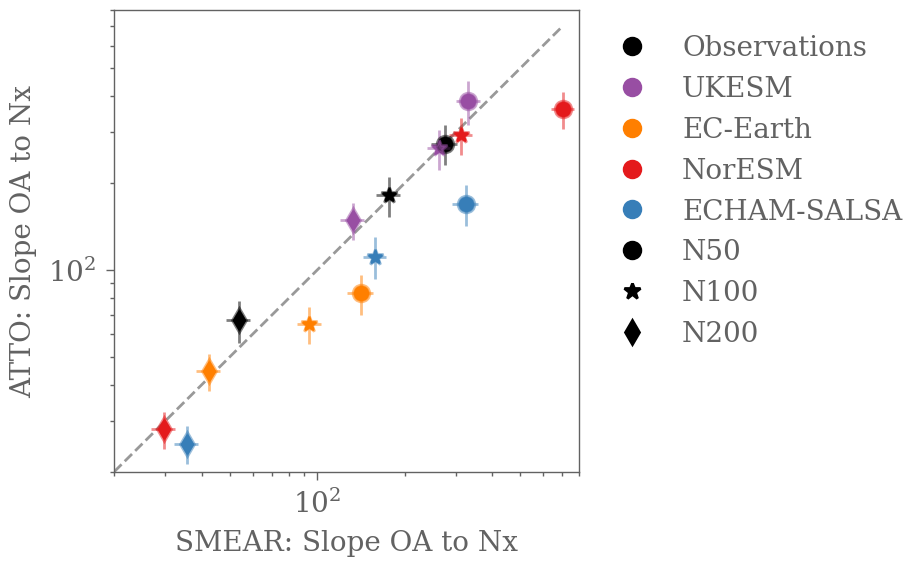

In [57]:
styles = ['o','*','d']
f, ax = plt.subplots(1, figsize=[3,3,])
_df_combr = _df_comb.reset_index()
for v,st in zip(_df_combr['variable'].unique(), styles):
    _df = _df_combr[_df_combr['variable']==v]
    for m in _df_combr['data source'].unique():
        _df2 = _df[_df['data source'] ==m]
        c = cdic_model[m]
        _df2.plot.scatter(x = 'a_smr', y='a_atto', c = c, ax = ax, marker=st)#, yerr = 'a_std_atto', xerr = 'a_std_smr', linewidth=.5)
        ax.errorbar(_df2['a_smr'], _df2['a_atto'], c = c, marker=st, yerr = _df2['a_std_atto'], xerr = _df2['a_std_smr'], linewidth=1, alpha=.5)
plt.plot([20,700],[20,700], c='k', linestyle='--', alpha=.4, zorder=-100)
plt.xlim([20,800])
plt.ylim([20,800])



plt.xlabel('SMEAR: Slope OA to Nx')
plt.ylabel('ATTO: Slope OA to Nx')

custom_lines =  []
custom_labels = []
for m in models_and_obs[::-1]:
    c = cdic_model[m]
    li = Line2D([0], [0], color=c, lw=0, marker='o')
    custom_lines.append(li)
    custom_labels.append(m)
for v,st in zip(_df_combr['variable'].unique(), styles):
    li = Line2D([0], [0], color='k', lw=0, marker=st)
    custom_lines.append(li)
    custom_labels.append(v)
    
ax.legend(custom_lines, custom_labels, bbox_to_anchor=(1,1,))

plt.yscale('log')
plt.xscale('log')

In [58]:
sns.relplot(x='a_smr', 
            y='a_atto', 
            hue='data source',
            style='variable',
            data = _df_comb.reset_index(),
            palette=pal,
            hue_order=hue_order,
            style_order=['OA','N50','N100','N200'],
            
            
           s=200)
plt.plot([0,700],[0,700], c='k', linestyle='--', alpha=.4, zorder=-100)
plt.xlim([10,800])
plt.ylim([10,800])
plt.xlabel('SMEAR: Slope OA to Nx')
plt.ylabel('ATTO: Slope OA to Nx')
plt.yscale('log')
plt.xscale('log')

NameError: name 'pal' is not defined

In [ ]:
_df = df_all_rn[['r$^2$']].reset_index().drop(['Fit'], axis=1).drop_duplicates().set_index(['station','variable','data source'])


_df_smr = _df.reset_index().set_index(['station']).loc['SMR',:]
_df_atto = _df.reset_index().set_index(['station']).loc['ATTO',:]


_df1 = _df_smr.rename({'r$^2$':'r2_smr'}, axis=1).reset_index().drop('station', axis=1)
_df2 = _df_atto.rename({'r$^2$':'r2_atto'}, axis=1).reset_index().drop('station', axis=1)

_df_comb = pd.concat([_df1.set_index(['variable','data source']), _df2.set_index(['variable','data source'])], axis=1)

_df_comb

In [ ]:
hue_order = models_and_obs[::-1]
pal = sns.color_palette([cdic_model[h] for h in hue_order])

In [ ]:
sns.relplot(x='r2_smr', 
            y='r2_atto', 
            hue='data source',
            style='variable',
            data = _df_comb.reset_index(),
            palette=pal,
            hue_order=hue_order,
            style_order=['OA','N50','N100','N200'],
            
           s=200)
plt.plot([0,1],[0,1], c='k', linestyle='--', alpha=.4, zorder=-100)
plt.xlim([0,1])
plt.ylim([0,1])

In [ ]:
sns.relplot(x='r2_smr', 
            y='r2_atto', 
            hue='data source',
            col='variable',
            data = _df_comb.reset_index(),
            palette=pal,
            hue_order=hue_order,
            col_order=['OA','N50','N100','N200'],
            
           s=200)

In [ ]:
select_station = 'SMR'

if select_station=='SMR':
    dic_df_med = dic_df_med_SMR
    xlims = [5,30]
    season = 'JA'

    
elif select_station=='ATTO':
    dic_df_med = dic_df_med_ATTO
    xlims = [20,40]
    season = 'FMA'
    
## Settings
alpha_scatt = 0.5

figsize=[7,10]
xlab = r'T  [$^\circ$C]'
ylab = r'$\Delta$OA [$\mu m^{-3}$]'


#ylims = [1,700]

# OBS: 
v_y = 'OA'
v_x = 'T_C'


xscale='linear'
yscale='linear'

fig, axs = plt.subplots(len(models_and_obs), sharex=True, sharey= False, figsize=figsize)

## Settings
alpha_scatt = 0.6


for mo, ax in zip(models_and_obs, axs):
    df_s =  dic_df_med[mo]
    print(mo)
    mask_months = select_months(df_s, season=season)
    df_s = df_s[mask_months].copy()
    
    #popt, pov, label, func, out = get_odr_fit_and_labs(df_s,v_x,v_y, fit_func='linear', return_func=True, return_out_obj=True)
    #popt, pov, label, func = get_log_fit_abc(df_s,v_x,v_y, return_func=True)
    #popt, pov, label, func = get_least_square_fit_and_labs(df_s, v_x, v_y, fit_func = 'exp', return_func=True)
    popt, pov, label, func, func_lin, popt_lin  = get_lin_log_fit(df_s, v_x, v_y, fit_func = 'exp', return_func=True, beta0=[0.01,.12])

    _mi = df_s[v_x].min()
    _ma = df_s[v_x].max() 
    ax.scatter(df_s[v_x],df_s[v_y]-func(df_s[v_x],*popt),
                                    color=cdic_model[mo], 
                #alpha=alpha_scatt, 
                #facecolor='none',
               alpha=alpha_scatt,
               
                edgecolor=cdic_model[mo],

                label=label
                   )
    _xlim = [_mi*.95, _ma*1.05]
    ax_ex.set_yscale(yscale)
    ax_ex.set_xscale(xscale)


    ax.hlines(0, xmin=xlims[0],xmax=xlims[1], color='k', linewidth=1)
    ax.legend(frameon=False)
    ax.set_ylabel(ylab)
    ax.set_title(mo, y=.93)
    ax.set_xlim(xlims)

        
#fig.suptitle('Observations')
axs[-1].set_xlabel(xlab)
fig.suptitle(r'Residuals fits')

sns.despine(fig)    
    
fn = make_fn_scat(f'residual_exp_{season}_{select_station}', v_x, v_y)
ax.legend(frameon=False)
fig.savefig(fn, dpi=150)
fig.savefig(fn.with_suffix('.pdf'), dpi=150)
print(fn)

In [ ]:
select_station = 'ATTO'

if select_station=='SMR':
    dic_df_med = dic_df_med_SMR
    xlims = [5,30]
    season = 'JA'

    
elif select_station=='ATTO':
    dic_df_med = dic_df_med_ATTO
    xlims = [20,40]
    season = 'FMA'
    
## Settings
alpha_scatt = 0.5

figsize=[7,10]
xlab = r'T  [$^\circ$C]'
ylab = r'$\Delta$OA [$\mu m^{-3}$]'


#ylims = [1,700]

# OBS: 
v_y = 'OA'
v_x = 'T_C'


xscale='linear'
yscale='linear'

fig, axs = plt.subplots(len(models_and_obs), sharex=True, sharey= False, figsize=figsize)

## Settings
alpha_scatt = 0.6


for mo, ax in zip(models_and_obs, axs):
    df_s =  dic_df_med[mo]
    print(mo)
    mask_months = select_months(df_s, season=season)
    df_s = df_s[mask_months].copy()
    
    #popt, pov, label, func, out = get_odr_fit_and_labs(df_s,v_x,v_y, fit_func='linear', return_func=True, return_out_obj=True)
    #popt, pov, label, func = get_log_fit_abc(df_s,v_x,v_y, return_func=True)
    #popt, pov, label, func = get_least_square_fit_and_labs(df_s, v_x, v_y, fit_func = 'exp', return_func=True)
    popt, pov, label, func  , func_lin, popt_lin = get_lin_log_fit(df_s, v_x, v_y, fit_func = 'exp', return_func=True, beta0=[0.01,.12])

    _mi = df_s[v_x].min()
    _ma = df_s[v_x].max() 
    ax.scatter(df_s[v_x],df_s[v_y]-func(df_s[v_x],*popt),
                                    color=cdic_model[mo], 
                #alpha=alpha_scatt, 
                #facecolor='none',
               alpha=alpha_scatt,
               
                edgecolor=cdic_model[mo],

                label=label
                   )
    _xlim = [_mi*.95, _ma*1.05]
    ax_ex.set_yscale(yscale)
    ax_ex.set_xscale(xscale)


    ax.hlines(0, xmin=xlims[0],xmax=xlims[1], color='k', linewidth=1)
    ax.legend(frameon=False)
    ax.set_ylabel(ylab)
    ax.set_title(mo, y=.93)
    ax.set_xlim(xlims)

        
#fig.suptitle('Observations')
axs[-1].set_xlabel(xlab)
fig.suptitle(r'Residuals fits')

sns.despine(fig)    
    
fn = make_fn_scat(f'residual_exp_{season}_{select_station}', v_x, v_y)
ax.legend(frameon=False)
fig.savefig(fn, dpi=150)
fig.savefig(fn.with_suffix('.pdf'), dpi=150)
print(fn)

## JFMAM

In [ ]:
fig_main = plt.figure(constrained_layout=True,
                  figsize=[17, 8.25],
                 )
spec2 = gridspec.GridSpec( nrows=2,ncols=3, 
                          height_ratios=[1,30], 
                          width_ratios=[30,1,30], 
                          figure=fig_main)

subfig_smr =  fig_main.add_subfigure(spec2[1, 0],frameon=True)
subfig_atto =  fig_main.add_subfigure(spec2[1, 2],frameon=True)
subfig_up_smr =  fig_main.add_subfigure(spec2[0, 0])
subfig_up_atto =  fig_main.add_subfigure(spec2[0, 2])



dic_fits = {}
dic_fits['SMR'] =dict()
dic_fits['ATTO'] =dict()



season_atto = 'JFMAM'
season_smr = 'JA'
markersize = 4





fig, ax, daxs, axs_extra = make_cool_grid5(fig =subfig_smr )##ncols_extra=2, nrows_extra=2,)# w_ratio_sideplot=.5)

axs_extra = axs_extra.flatten()[::-1]








dic_df_med = dic_df_med_SMR
select_station = 'SMR'
dic_fits[select_station] = dict()
dic_fits[select_station][v_y] = dict()

## Settings
alpha_scatt = 0.6

xlab = r'T  [$^\circ$C]'
ylab = r'OA [$\mu g m^{-3}$]'


linewidth=2
xlims = [5,30]
ylims = [.1,35]


season=season_smr
v_x = 'T_C'
v_y = 'OA'
dic_fits[select_station][v_y] = dict()


make_plot(v_x, v_y, xlims, ylims, season, 
              xlab, ylab, .3, models_and_obs, fig, ax, daxs, axs_extra,
          yscale='log',
          dic_df_med = dic_df_med,
          markersize=markersize

         )


for mo, ax_ex in zip(models_and_obs, axs_extra[:]):
    print(f'******{mo}*********')
    df_s =  dic_df_med[mo]
    print(mo)
    mask_months = select_months(df_s, season=season)
    df_s = df_s[mask_months].copy()
    #popt, pov, label, func = get_least_square_fit_and_labs(df_s, v_x, v_y, fit_func = 'exp', return_func=True, beta0=[0.01,.12])
    #popt, pov, label, func = get_lin_log_fit(df_s, v_x, v_y, fit_func = 'exp', return_func=True, beta0=[0.01,.12])
    popt, pov, label, func,func_lin, popt_lin = get_lin_log_fit(df_s, v_x, v_y, fit_func = 'exp', return_func=True, beta0=[0.01,.12])

    dic_fits[select_station][v_y][mo] = dict()
    dic_fits[select_station][v_y][mo]['label'] = label
    dic_fits[select_station][v_y][mo]['popt'] = popt
    dic_fits[select_station][v_y][mo]['pcov'] = pov
    dic_fits[select_station][v_y][mo]['standard_error'] = np.sqrt(np.diag(dic_fits[select_station][v_y][mo]['pcov']))

    dic_fits[select_station][v_y][mo]['func'] = func
    dic_fits[select_station][v_y][mo]['R2'] = get_r2_logy(df_s,v_x,v_y, popt_lin, func_lin)
    dic_fits[select_station][v_y][mo]['corr'] = get_corr(df_s,v_x,v_y)
    print('R2*****')
    print(dic_fits[select_station][v_y][mo]['R2'])
    print(dic_fits[select_station][v_y][mo]['corr'])
    dic_fits[select_station][v_y][mo] = calc_table_se(dic_fits[select_station][v_y][mo])   

    
    
    _mi = df_s[v_x].min()
    _ma = df_s[v_x].max() 
    _xlim = [_mi*.95, _ma*1.05]
    x = np.linspace(*_xlim)
    
    ax.plot(x, func(x, *popt), c='w', linewidth=linewidth+2,label='__nolegend__')
    ax.plot(x, func(x, *popt), linewidth=linewidth+1, c=cdic_model[mo],label=f'{mo}: {label}')

    ax_ex.plot(x, func(x, *popt), c='w', linewidth=linewidth+1,label=f'{mo}: {label}',
             )
    ax_ex.plot(x, func(x, *popt), c=cdic_model[mo],label=f'{mo}: {label}',
               linewidth=linewidth,
              )
    ax_ex.set_yscale('log')
ax.set_yscale('log')
ax.grid(color='grey', linewidth=.5, linestyle=':')

for ax_ex in axs_extra:
    ax_ex.set_yticklabels([])
    ax_ex.grid(color='grey', linewidth=.5, linestyle=':')
    ax_ex.set_ylim(ylims)
    ax_ex.set_xlim(xlims)

    
fn = make_fn_scat(f'exp1_{season}', v_x, v_y)
ax.legend(frameon=False)




## ATTO:
select_station = 'ATTO'
dic_fits[select_station] = dict()
dic_fits[select_station][v_y] = dict()


xlims = [20,40]



fig, ax, daxs, axs_extra = make_cool_grid5(fig =subfig_atto )##ncols_extra=2, nrows_extra=2,)# w_ratio_sideplot=.5)

axs_extra = axs_extra.flatten()[::-1]

dic_df_med = dic_df_med_ATTO


## Settings
alpha_scatt = 0.6


linewidth=2
xlims = [20,40]


season = season_atto


make_plot(v_x, v_y, xlims, ylims, season, 
              xlab, ylab, .3, models_and_obs, fig, ax, daxs, axs_extra,
          yscale='log',
          dic_df_med = dic_df_med,
          markersize=markersize
         
         )


for mo, ax_ex in zip(models_and_obs, axs_extra[:]):
    print(f'******{mo}********')
    df_s =  dic_df_med[mo]
    print(mo)
    mask_months = select_months(df_s, season=season)
    df_s = df_s[mask_months].copy()
    
    #popt, pov, label, func = get_least_square_fit_and_labs(df_s, v_x, v_y, fit_func = 'exp', return_func=True, beta0=[0.01,.12])
    #popt, pov, label, func = get_odr_fit_and_labs(df_s, v_x, v_y, fit_func = 'exp', return_func=True, beta0=[0.01,.12])
    popt, pov, label, func, func_lin, popt_lin = get_lin_log_fit(df_s, v_x, v_y, fit_func = 'exp', return_func=True, beta0=[0.01,.12])
        
    dic_fits[select_station][v_y][mo] = dict()
    dic_fits[select_station][v_y][mo]['label'] = label
    dic_fits[select_station][v_y][mo]['popt'] = popt
    dic_fits[select_station][v_y][mo]['pcov'] = pov
    dic_fits[select_station][v_y][mo]['standard_error'] = np.sqrt(np.diag(dic_fits[select_station][v_y][mo]['pcov']))

    dic_fits[select_station][v_y][mo]['func'] = func
    dic_fits[select_station][v_y][mo]['R2'] = get_r2_logy(df_s,v_x,v_y, popt_lin, func_lin)
    dic_fits[select_station][v_y][mo]['corr'] = get_corr(df_s,v_x,v_y)
    print('R2*****')
    print(dic_fits[select_station][v_y][mo]['R2'])
    print(dic_fits[select_station][v_y][mo]['corr'])
    
    dic_fits[select_station][v_y][mo] = calc_table_se(dic_fits[select_station][v_y][mo])   

    
    
    _mi = df_s[v_x].min()
    _ma = df_s[v_x].max() 
    _xlim = [_mi*.95, _ma*1.05]
    x = np.linspace(*_xlim)
    
    ax.plot(x, func(x, *popt), c='w', linewidth=linewidth+2,label='__nolegend__')
    ax.plot(x, func(x, *popt), linewidth=linewidth+1, c=cdic_model[mo],label=f'{mo}: {label}')

    ax_ex.plot(x, func(x, *popt), c='w', linewidth=linewidth+1,label=f'{mo}: {label}',
             )
    ax_ex.plot(x, func(x, *popt), c=cdic_model[mo],label=f'{mo}: {label}',
               linewidth=linewidth,
              )
    ax_ex.set_yscale('log')
    ax_ex.set_ylim(ylims)
    ax_ex.set_xlim(xlims)
ax.set_yscale('log')

ax.grid(color='grey', linewidth=.5, linestyle=':')

ax.set_xticks(np.arange(20,41,5))

for ax_ex in axs_extra.flatten():
    ax_ex.set_yticklabels([])
    ax_ex.set_xticks(np.arange(20,41,5))
    ax_ex.grid(color='grey', linewidth=.5, linestyle=':')

ax.legend(frameon=False)











ax_up_smr = subfig_up_smr.subplots()
ax_up_smr.axis('off')
subfig_up_smr.suptitle('SMEARII: July, Aug',size=16,)
ax_up_atto = subfig_up_atto.subplots()
ax_up_atto.axis('off')
#subfig_up_atto.suptitle('ATTO: Feb, Mar, Apr, May',size=16,)
subfig_up_atto.suptitle(f'ATTO: {dic_season_nicename[season_atto]}',size=16,)

fn = make_fn_scat(f'together_{season_smr}_{season_atto}', v_x, v_y)
print(fn)
fig_main.savefig(fn.with_suffix('.pdf'), dpi=200)
fig_main.savefig(fn.with_suffix('.png'), dpi=200)
plt.show()

df = make_pd_of_dic(dic_fits)
df.to_csv(fn.with_suffix('.csv'))


## JFM

In [ ]:
fig_main = plt.figure(constrained_layout=True,
                  figsize=[17, 8.25],
                 )
spec2 = gridspec.GridSpec( nrows=2,ncols=3, 
                          height_ratios=[1,30], 
                          width_ratios=[30,1,30], 
                          figure=fig_main)

subfig_smr =  fig_main.add_subfigure(spec2[1, 0],frameon=True)
subfig_atto =  fig_main.add_subfigure(spec2[1, 2],frameon=True)
subfig_up_smr =  fig_main.add_subfigure(spec2[0, 0])
subfig_up_atto =  fig_main.add_subfigure(spec2[0, 2])



dic_fits = {}
dic_fits['SMR'] =dict()
dic_fits['ATTO'] =dict()



season_atto = 'JFM'
season_smr = 'JA'





fig, ax, daxs, axs_extra = make_cool_grid5(fig =subfig_smr )##ncols_extra=2, nrows_extra=2,)# w_ratio_sideplot=.5)

axs_extra = axs_extra.flatten()[::-1]








dic_df_med = dic_df_med_SMR
select_station = 'SMR'
dic_fits[select_station] = dict()
dic_fits[select_station][v_y] = dict()

## Settings
alpha_scatt = 0.6

xlab = r'T  [$^\circ$C]'
ylab = r'OA [$\mu g m^{-3}$]'


linewidth=2
xlims = [5,30]
ylims = [.1,35]


season=season_smr
v_x = 'T_C'
v_y = 'OA'
dic_fits[select_station][v_y] = dict()


make_plot(v_x, v_y, xlims, ylims, season, 
              xlab, ylab, .3, models_and_obs, fig, ax, daxs, axs_extra,
          yscale='log',
          dic_df_med = dic_df_med ,
          markersize=markersize
          
         )


for mo, ax_ex in zip(models_and_obs, axs_extra[:]):
    print(f'******{mo}*********')
    df_s =  dic_df_med[mo]
    print(mo)
    mask_months = select_months(df_s, season=season)
    df_s = df_s[mask_months].copy()
    #popt, pov, label, func = get_least_square_fit_and_labs(df_s, v_x, v_y, fit_func = 'exp', return_func=True, beta0=[0.01,.12])
    #popt, pov, label, func = get_lin_log_fit(df_s, v_x, v_y, fit_func = 'exp', return_func=True, beta0=[0.01,.12])
    popt, pov, label, func,func_lin, popt_lin = get_lin_log_fit(df_s, v_x, v_y, fit_func = 'exp', return_func=True, beta0=[0.01,.12])

    dic_fits[select_station][v_y][mo] = dict()
    dic_fits[select_station][v_y][mo]['label'] = label
    dic_fits[select_station][v_y][mo]['popt'] = popt
    dic_fits[select_station][v_y][mo]['pcov'] = pov
    dic_fits[select_station][v_y][mo]['standard_error'] = np.sqrt(np.diag(dic_fits[select_station][v_y][mo]['pcov']))

    dic_fits[select_station][v_y][mo]['func'] = func
    dic_fits[select_station][v_y][mo]['R2'] = get_r2_logy(df_s,v_x,v_y, popt_lin, func_lin)
    dic_fits[select_station][v_y][mo]['corr'] = get_corr(df_s,v_x,v_y)
    print('R2*****')
    print(dic_fits[select_station][v_y][mo]['corr'])
    dic_fits[select_station][v_y][mo] = calc_table_se(dic_fits[select_station][v_y][mo])   

    
    
    _mi = df_s[v_x].min()
    _ma = df_s[v_x].max() 
    _xlim = [_mi*.95, _ma*1.05]
    x = np.linspace(*_xlim)
    
    ax.plot(x, func(x, *popt), c='w', linewidth=linewidth+2,label='__nolegend__')
    ax.plot(x, func(x, *popt), linewidth=linewidth+1, c=cdic_model[mo],label=f'{mo}: {label}')

    ax_ex.plot(x, func(x, *popt), c='w', linewidth=linewidth+1,label=f'{mo}: {label}',
             )
    ax_ex.plot(x, func(x, *popt), c=cdic_model[mo],label=f'{mo}: {label}',
               linewidth=linewidth,
              )
    ax_ex.set_yscale('log')
ax.set_yscale('log')
ax.grid(color='grey', linewidth=.5, linestyle=':')

for ax_ex in axs_extra:
    ax_ex.set_yticklabels([])
    ax_ex.grid(color='grey', linewidth=.5, linestyle=':')
    ax_ex.set_ylim(ylims)
    ax_ex.set_xlim(xlims)

    
fn = make_fn_scat(f'exp1_{season}', v_x, v_y)
ax.legend(frameon=False)




## ATTO:
select_station = 'ATTO'
dic_fits[select_station] = dict()
dic_fits[select_station][v_y] = dict()


xlims = [20,40]



fig, ax, daxs, axs_extra = make_cool_grid5(fig =subfig_atto )##ncols_extra=2, nrows_extra=2,)# w_ratio_sideplot=.5)

axs_extra = axs_extra.flatten()[::-1]

dic_df_med = dic_df_med_ATTO


## Settings
alpha_scatt = 0.6


linewidth=2
xlims = [20,40]


season = season_atto


make_plot(v_x, v_y, xlims, ylims, season, 
              xlab, ylab, .3, models_and_obs, fig, ax, daxs, axs_extra,
          yscale='log',
          dic_df_med = dic_df_med,
          markersize=markersize
          
         
         )


for mo, ax_ex in zip(models_and_obs, axs_extra[:]):
    print(f'******{mo}********')
    df_s =  dic_df_med[mo]
    print(mo)
    mask_months = select_months(df_s, season=season)
    df_s = df_s[mask_months].copy()
    
    #popt, pov, label, func = get_least_square_fit_and_labs(df_s, v_x, v_y, fit_func = 'exp', return_func=True, beta0=[0.01,.12])
    #popt, pov, label, func = get_odr_fit_and_labs(df_s, v_x, v_y, fit_func = 'exp', return_func=True, beta0=[0.01,.12])
    popt, pov, label, func, func_lin, popt_lin = get_lin_log_fit(df_s, v_x, v_y, fit_func = 'exp', return_func=True, beta0=[0.01,.12])
        
    dic_fits[select_station][v_y][mo] = dict()
    dic_fits[select_station][v_y][mo]['label'] = label
    dic_fits[select_station][v_y][mo]['popt'] = popt
    dic_fits[select_station][v_y][mo]['pcov'] = pov
    dic_fits[select_station][v_y][mo]['standard_error'] = np.sqrt(np.diag(dic_fits[select_station][v_y][mo]['pcov']))

    dic_fits[select_station][v_y][mo]['func'] = func
    dic_fits[select_station][v_y][mo]['R2'] = get_r2_logy(df_s,v_x,v_y, popt_lin, func_lin)
    dic_fits[select_station][v_y][mo]['corr'] = get_corr(df_s,v_x,v_y)
    print('R2*****')
    print(dic_fits[select_station][v_y][mo]['R2'])
    print(dic_fits[select_station][v_y][mo]['corr'])
    
    dic_fits[select_station][v_y][mo] = calc_table_se(dic_fits[select_station][v_y][mo])   

    
    
    _mi = df_s[v_x].min()
    _ma = df_s[v_x].max() 
    _xlim = [_mi*.95, _ma*1.05]
    x = np.linspace(*_xlim)
    
    ax.plot(x, func(x, *popt), c='w', linewidth=linewidth+2,label='__nolegend__')
    ax.plot(x, func(x, *popt), linewidth=linewidth+1, c=cdic_model[mo],label=f'{mo}: {label}')

    ax_ex.plot(x, func(x, *popt), c='w', linewidth=linewidth+1,label=f'{mo}: {label}',
             )
    ax_ex.plot(x, func(x, *popt), c=cdic_model[mo],label=f'{mo}: {label}',
               linewidth=linewidth,
              )
    ax_ex.set_yscale('log')
    ax_ex.set_ylim(ylims)
    ax_ex.set_xlim(xlims)
ax.set_yscale('log')
ax.grid(color='grey', linewidth=.5, linestyle=':')

ax.set_xticks(np.arange(20,41,5))

for ax_ex in axs_extra.flatten():
    ax_ex.set_yticklabels([])
    ax_ex.set_xticks(np.arange(20,41,5))
    ax_ex.grid(color='grey', linewidth=.5, linestyle=':')

    
ax.legend(frameon=False)











ax_up_smr = subfig_up_smr.subplots()
ax_up_smr.axis('off')
subfig_up_smr.suptitle('SMEARII: July, Aug',size=16,)
ax_up_atto = subfig_up_atto.subplots()
ax_up_atto.axis('off')
#subfig_up_atto.suptitle('ATTO: Feb, Mar, Apr, May',size=16,)
subfig_up_atto.suptitle(f'ATTO: {dic_season_nicename[season_atto]}',size=16,)

fn = make_fn_scat(f'together_{season_smr}_{season_atto}', v_x, v_y)
print(fn)
fig_main.savefig(fn.with_suffix('.pdf'), dpi=200)
fig_main.savefig(fn.with_suffix('.png'), dpi=200)
plt.show()

df = make_pd_of_dic(dic_fits)
df.to_csv(fn.with_suffix('.csv'))


## MAM

In [ ]:
fig_main = plt.figure(constrained_layout=True,
                  figsize=[17, 8.25],
                 )
spec2 = gridspec.GridSpec( nrows=2,ncols=3, 
                          height_ratios=[1,30], 
                          width_ratios=[30,1,30], 
                          figure=fig_main)

subfig_smr =  fig_main.add_subfigure(spec2[1, 0],frameon=True)
subfig_atto =  fig_main.add_subfigure(spec2[1, 2],frameon=True)
subfig_up_smr =  fig_main.add_subfigure(spec2[0, 0])
subfig_up_atto =  fig_main.add_subfigure(spec2[0, 2])



dic_fits = {}
dic_fits['SMR'] =dict()
dic_fits['ATTO'] =dict()



season_atto = 'MAM'
season_smr = 'JA'





fig, ax, daxs, axs_extra = make_cool_grid5(fig =subfig_smr )##ncols_extra=2, nrows_extra=2,)# w_ratio_sideplot=.5)

axs_extra = axs_extra.flatten()[::-1]








dic_df_med = dic_df_med_SMR
select_station = 'SMR'
dic_fits[select_station] = dict()
dic_fits[select_station][v_y] = dict()

## Settings
alpha_scatt = 0.6

xlab = r'T  [$^\circ$C]'
ylab = r'OA [$\mu g m^{-3}$]'


linewidth=2
xlims = [5,30]
ylims = [.1,35]


season=season_smr
v_x = 'T_C'
v_y = 'OA'
dic_fits[select_station][v_y] = dict()


make_plot(v_x, v_y, xlims, ylims, season, 
              xlab, ylab, .3, models_and_obs, fig, ax, daxs, axs_extra,
          yscale='log',
          dic_df_med = dic_df_med         ,
          markersize = markersize,
         )


for mo, ax_ex in zip(models_and_obs, axs_extra[:]):
    print(f'******{mo}*********')
    df_s =  dic_df_med[mo]
    print(mo)
    mask_months = select_months(df_s, season=season)
    df_s = df_s[mask_months].copy()
    #popt, pov, label, func = get_least_square_fit_and_labs(df_s, v_x, v_y, fit_func = 'exp', return_func=True, beta0=[0.01,.12])
    #popt, pov, label, func = get_lin_log_fit(df_s, v_x, v_y, fit_func = 'exp', return_func=True, beta0=[0.01,.12])
    popt, pov, label, func,func_lin, popt_lin = get_lin_log_fit(df_s, v_x, v_y, fit_func = 'exp', return_func=True, beta0=[0.01,.12])

    dic_fits[select_station][v_y][mo] = dict()
    dic_fits[select_station][v_y][mo]['label'] = label
    dic_fits[select_station][v_y][mo]['popt'] = popt
    dic_fits[select_station][v_y][mo]['pcov'] = pov
    dic_fits[select_station][v_y][mo]['standard_error'] = np.sqrt(np.diag(dic_fits[select_station][v_y][mo]['pcov']))

    dic_fits[select_station][v_y][mo]['func'] = func
    dic_fits[select_station][v_y][mo]['R2'] = get_r2_logy(df_s,v_x,v_y, popt_lin, func_lin)
    dic_fits[select_station][v_y][mo]['corr'] = get_corr(df_s,v_x,v_y)
    print('R2*****')
    print(dic_fits[select_station][v_y][mo]['R2'])
    print(dic_fits[select_station][v_y][mo]['corr'])
    dic_fits[select_station][v_y][mo] = calc_table_se(dic_fits[select_station][v_y][mo])   

    
    
    _mi = df_s[v_x].min()
    _ma = df_s[v_x].max() 
    _xlim = [_mi*.95, _ma*1.05]
    x = np.linspace(*_xlim)
    
    ax.plot(x, func(x, *popt), c='w', linewidth=linewidth+2,label='__nolegend__')
    ax.plot(x, func(x, *popt), linewidth=linewidth+1, c=cdic_model[mo],label=f'{mo}: {label}')

    ax_ex.plot(x, func(x, *popt), c='w', linewidth=linewidth+1,label=f'{mo}: {label}',
             )
    ax_ex.plot(x, func(x, *popt), c=cdic_model[mo],label=f'{mo}: {label}',
               linewidth=linewidth,
              )
    ax_ex.set_yscale('log')
ax.set_yscale('log')
ax.grid(color='grey', linewidth=.5, linestyle=':')

for ax_ex in axs_extra:
    ax_ex.set_yticklabels([])
    ax_ex.grid(color='grey', linewidth=.5, linestyle=':')
    ax_ex.set_ylim(ylims)
    ax_ex.set_xlim(xlims)

    
fn = make_fn_scat(f'exp1_{season}', v_x, v_y)
ax.legend(frameon=False)




## ATTO:
select_station = 'ATTO'
dic_fits[select_station] = dict()
dic_fits[select_station][v_y] = dict()


xlims = [20,40]



fig, ax, daxs, axs_extra = make_cool_grid5(fig =subfig_atto )##ncols_extra=2, nrows_extra=2,)# w_ratio_sideplot=.5)

axs_extra = axs_extra.flatten()[::-1]

dic_df_med = dic_df_med_ATTO


## Settings
alpha_scatt = 0.6


linewidth=2
xlims = [20,40]


season = season_atto


make_plot(v_x, v_y, xlims, ylims, season, 
              xlab, ylab, .3, models_and_obs, fig, ax, daxs, axs_extra,
          yscale='log',
          dic_df_med = dic_df_med,
          markersize=markersize,
         
         )


for mo, ax_ex in zip(models_and_obs, axs_extra[:]):
    print(f'******{mo}********')
    df_s =  dic_df_med[mo]
    print(mo)
    mask_months = select_months(df_s, season=season)
    df_s = df_s[mask_months].copy()
    
    #popt, pov, label, func = get_least_square_fit_and_labs(df_s, v_x, v_y, fit_func = 'exp', return_func=True, beta0=[0.01,.12])
    #popt, pov, label, func = get_odr_fit_and_labs(df_s, v_x, v_y, fit_func = 'exp', return_func=True, beta0=[0.01,.12])
    popt, pov, label, func, func_lin, popt_lin = get_lin_log_fit(df_s, v_x, v_y, fit_func = 'exp', return_func=True, beta0=[0.01,.12])
        
    dic_fits[select_station][v_y][mo] = dict()
    dic_fits[select_station][v_y][mo]['label'] = label
    dic_fits[select_station][v_y][mo]['popt'] = popt
    dic_fits[select_station][v_y][mo]['pcov'] = pov
    dic_fits[select_station][v_y][mo]['standard_error'] = np.sqrt(np.diag(dic_fits[select_station][v_y][mo]['pcov']))

    dic_fits[select_station][v_y][mo]['func'] = func
    dic_fits[select_station][v_y][mo]['R2'] = get_r2_logy(df_s,v_x,v_y, popt_lin, func_lin)
    dic_fits[select_station][v_y][mo]['corr'] = get_corr(df_s,v_x,v_y)
    print('R2*****')
    print(dic_fits[select_station][v_y][mo]['R2'])
    print(dic_fits[select_station][v_y][mo]['corr'])
    
    dic_fits[select_station][v_y][mo] = calc_table_se(dic_fits[select_station][v_y][mo])   

    
    
    _mi = df_s[v_x].min()
    _ma = df_s[v_x].max() 
    _xlim = [_mi*.95, _ma*1.05]
    x = np.linspace(*_xlim)
    
    ax.plot(x, func(x, *popt), c='w', linewidth=linewidth+2,label='__nolegend__')
    ax.plot(x, func(x, *popt), linewidth=linewidth+1, c=cdic_model[mo],label=f'{mo}: {label}')

    ax_ex.plot(x, func(x, *popt), c='w', linewidth=linewidth+1,label=f'{mo}: {label}',
             )
    ax_ex.plot(x, func(x, *popt), c=cdic_model[mo],label=f'{mo}: {label}',
               linewidth=linewidth,
              )
    ax_ex.set_yscale('log')
    ax_ex.set_ylim(ylims)
    ax_ex.set_xlim(xlims)
ax.set_yscale('log')
ax.grid(color='grey', linewidth=.5, linestyle=':')

ax.set_xticks(np.arange(20,41,5))

for ax_ex in axs_extra.flatten():
    ax_ex.set_yticklabels([])
    ax_ex.set_xticks(np.arange(20,41,5))
    ax_ex.grid(color='grey', linewidth=.5, linestyle=':')

    
ax.legend(frameon=False)











ax_up_smr = subfig_up_smr.subplots()
ax_up_smr.axis('off')
subfig_up_smr.suptitle('SMEARII: July, Aug',size=16,)
ax_up_atto = subfig_up_atto.subplots()
ax_up_atto.axis('off')
#subfig_up_atto.suptitle('ATTO: Feb, Mar, Apr, May',size=16,)
subfig_up_atto.suptitle(f'ATTO: {dic_season_nicename[season_atto]}',size=16,)

fn = make_fn_scat(f'together_{season_smr}_{season_atto}', v_x, v_y)
print(fn)
fig_main.savefig(fn.with_suffix('.pdf'), dpi=200)
fig_main.savefig(fn.with_suffix('.png'), dpi=200)
plt.show()

df = make_pd_of_dic(dic_fits)
df.to_csv(fn.with_suffix('.csv'))


In [ ]:
fig = plt.figure(constrained_layout=True, figsize=(10, 4),)
subfigs = fig.subfigures(1, 3, width_ratios=[4,1,4], wspace=0.07)


f1 = subfigs[0]
f1.subplots(3,5, sharex=True, sharey='row')
subfigs[2].subplots(3,5, sharex=True, sharey='row')
subfigs[1].subplots(3,1, sharex=True, sharey='row')
subfigs[0].set_facecolor('#e5f8f8')
subfigs[-1].set_facecolor('#fff4ea')
subfigs[0].suptitle('SMEARII, Jul & Aug')
subfigs[-1].suptitle('ATTO, JFM')
#subfigs[1].suptitle('Fits')
#fig.set_constrained_layout_pads(h_pad=1, w_pad = 1)
#fig.tight_layout()
plt.show()


In [ ]:
fig, axs_all = plt.subplots(3,11,figsize=[20,10], sharey='row', sharex='col')

for ax in axs_all[:,:5].flatten():
    ax.set(facecolor = "#fff4ea",)#a4c8d6")
    #ax.patch.set_facecolor('orange')
for ax in axs_all[:,6:].flatten():
    ax.set(facecolor = "#e5f8f8",)#a4c8d6")
    #ax.patch.set_facecolor('orange')


In [ ]:
fig, axs_all = plt.subplots(3,11,figsize=[20,10], sharey='row', sharex='col')

for ax in axs_all[:,:5].flatten():
    ax.set(facecolor = "#d0d6c4",)#a4c8d6")
    #ax.patch.set_facecolor('orange')
for ax in axs_all[:,6:].flatten():
    ax.set(facecolor = "#f1f8e3",)#a4c8d6")
    #ax.patch.set_facecolor('orange')


In [ ]:
fig, axs_all = plt.subplots(3,6,figsize=[10,10], sharey='row', sharex='col')
